In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import xgboost as xgb
import sklearn.metrics as mtr
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import dataframe_image as dfi
import pytz
import matplotlib.dates as mdates

# Exploração e Tratamento dos dados

In [2]:
df = pd.read_csv('dados_floripa.csv')
df

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\2996573664.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dados_floripa.csv')


DataIni   HoraIni     DataFim   HoraFim Sentido Linha NoVeículo  \
0        2019-04-14  02:29:00  2019-04-14  02:30:00     Ida   100       271   
1        2019-04-14  03:30:00  2019-04-14  03:30:00     Ida   100       271   
2        2019-04-13  01:28:00  2019-04-13  01:28:00     Ida   100       276   
3        2019-04-12  03:28:00  2019-04-12  03:28:00     Ida   100       279   
4        2019-04-07  00:31:00  2019-04-07  00:31:00     Ida   100       273   
...             ...       ...         ...       ...     ...   ...       ...   
2694355  2019-10-01  04:00:00  2019-10-01  04:34:00   Volta   477     50404   
2694356  2019-10-01  04:29:00  2019-10-01  05:12:00   Volta   477     50359   
2694357  2019-10-01  05:15:00  2019-10-01  05:47:00   Volta   477     50404   
2694358  2019-10-01  05:47:00  2019-10-01  05:47:00   Volta   477     50404   
2694359  2019-10-01  09:56:00  2019-10-01  10:32:00   Volta   477     50404   

        DuraçãoViagem  TotalGiros  KmPerc  
0            00:01:00           0   0.000  
1            00:00:00           0   0.000  
2            00:00:00           0   0.000  
3            00:00:00           0   0.000  
4            00:00:00           0   0.000  
...               ...         ...     ...  
2694355      00:34:00           5  17.294  
2694356      00:43:00           7  17.294  
2694357      00:32:00           7  17.294  
2694358      00:00:00           0  17.294  
2694359      00:36:00          11  17.294  

[2694360 rows x 10 columns]

In [3]:
# Checar o tipos dos dados
df.dtypes

DataIni           object
HoraIni           object
DataFim           object
HoraFim           object
Sentido           object
Linha             object
NoVeículo         object
DuraçãoViagem     object
TotalGiros         int64
KmPerc           float64
dtype: object

In [4]:
# Checkup geral das colunas
# Podemos ver num primeiro momento que:
# Sentido está de certa forma balanceado no geral, verificar se para todas as rotas também está próximo
# Existem 229 linhas que podem ser trabalhadas (objeto do estudo)
# Existem 1295 veículos, pode existir alguma relação do veículo com a eficiência/velocidade da rota, porém como não sabemos quem dirige o ônibus ou informações do mesmo como estado de manutenção e etc, provavelmente será um dado descartado
# Algumas rotas estão com KmPerc zerados, podem ser falhas de medição e serão descartados
# Algumas rotas estão com o tempo de viagem zerados, podem ser falhas de medição e serão descartados
# TotalGiros são o número de pessoas que passaram pela roleta podem influenciar na DuraçãoViagem das rotas, algumas estão zeradas podendo ser falha de medição
for colum in df:
    print(f'{df[colum].describe()}\n--------------------------')

count        2694360
unique           366
top       2019-10-25
freq            9276
Name: DataIni, dtype: object
--------------------------
count      2694360
unique        1440
top       07:00:00
freq          4366
Name: HoraIni, dtype: object
--------------------------
count        2694360
unique           366
top       2019-10-25
freq            9275
Name: DataFim, dtype: object
--------------------------
count      2694360
unique        1440
top       07:15:00
freq          3969
Name: HoraFim, dtype: object
--------------------------
count     2694360
unique          2
top         Volta
freq      1394073
Name: Sentido, dtype: object
--------------------------
count     2694360
unique        230
top           410
freq        68613
Name: Linha, dtype: object
--------------------------
count     2694360
unique       1301
top         11637
freq         8487
Name: NoVeículo, dtype: int64
--------------------------
count      2694360
unique         454
top       00:21:00
freq         819

In [5]:
# Id do veículos consideramos que é um informação desnecessária, visto que não temos dados dos veículos em si como modelo, motor e etc. Assim acreditamos ser um dados desnecessário para a predição
df.drop(columns='NoVeículo',inplace=True)

In [6]:
# Unindo data e hora e removendo as antigas (Visto que as datas e horas atuais estão em colunas separadas e são objetos, queremos elas como datetimes)
df['Ini'] = pd.to_datetime(df['DataIni'] + ' ' + df['HoraIni'])
df['Fim'] = pd.to_datetime(df['DataFim'] + ' ' + df['HoraFim'])
df.drop(columns=['DataIni','HoraIni','DataFim','HoraFim'],inplace=True)

In [7]:
# Transformando a DuraçãoViagem em segundos, visto que é um objeto também
def time_to_seconds(time_str):
    hours, minutes, seconds = map(int, time_str.split(':'))
    total_seconds = (hours * 3600) + (minutes * 60) + seconds
    return total_seconds
df['DuraçãoViagem'] = df['DuraçãoViagem'].apply(time_to_seconds)
df

Sentido Linha  DuraçãoViagem  TotalGiros  KmPerc                 Ini  \
0           Ida   100             60           0   0.000 2019-04-14 02:29:00   
1           Ida   100              0           0   0.000 2019-04-14 03:30:00   
2           Ida   100              0           0   0.000 2019-04-13 01:28:00   
3           Ida   100              0           0   0.000 2019-04-12 03:28:00   
4           Ida   100              0           0   0.000 2019-04-07 00:31:00   
...         ...   ...            ...         ...     ...                 ...   
2694355   Volta   477           2040           5  17.294 2019-10-01 04:00:00   
2694356   Volta   477           2580           7  17.294 2019-10-01 04:29:00   
2694357   Volta   477           1920           7  17.294 2019-10-01 05:15:00   
2694358   Volta   477              0           0  17.294 2019-10-01 05:47:00   
2694359   Volta   477           2160          11  17.294 2019-10-01 09:56:00   

                        Fim  
0       2019-04-14 02:30:00  
1       2019-04-14 03:30:00  
2       2019-04-13 01:28:00  
3       2019-04-12 03:28:00  
4       2019-04-07 00:31:00  
...                     ...  
2694355 2019-10-01 04:34:00  
2694356 2019-10-01 05:12:00  
2694357 2019-10-01 05:47:00  
2694358 2019-10-01 05:47:00  
2694359 2019-10-01 10:32:00  

[2694360 rows x 7 columns]

In [8]:
# Removendo linhas com Duração e Distância percorridas iguais a 0
df = df.loc[(df['DuraçãoViagem'] != 0) & (df['KmPerc'] != 0)]

In [9]:
# Criando uma coluna de Velocidade para identificar outliers
df['Km/H'] = df['KmPerc']/(df['DuraçãoViagem']/3600)
# Removendo valores muito baixos e altos de velocidade
df = df.loc[(df['Km/H'] > 3) & (df['Km/H'] < 80)]
df.drop(columns='Km/H', inplace=True)
df

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\629631639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Km/H'] = df['KmPerc']/(df['DuraçãoViagem']/3600)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\629631639.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns='Km/H', inplace=True)


Sentido Linha  DuraçãoViagem  TotalGiros  KmPerc                 Ini  \
6         Volta   100           3780           3  16.308 2019-05-01 00:31:00   
7         Volta   100           3660          10  16.308 2019-05-01 01:35:00   
8         Volta   100           1800           8  16.308 2019-05-01 02:36:00   
9         Volta   100           3600           7  16.308 2019-05-01 03:30:00   
10        Volta   100           1680           7  16.308 2019-05-01 04:30:00   
...         ...   ...            ...         ...     ...                 ...   
2694352   Volta   477           1500           1  17.294 2019-10-01 03:30:00   
2694355   Volta   477           2040           5  17.294 2019-10-01 04:00:00   
2694356   Volta   477           2580           7  17.294 2019-10-01 04:29:00   
2694357   Volta   477           1920           7  17.294 2019-10-01 05:15:00   
2694359   Volta   477           2160          11  17.294 2019-10-01 09:56:00   

                        Fim  
6       2019-05-01 01:34:00  
7       2019-05-01 02:36:00  
8       2019-05-01 03:06:00  
9       2019-05-01 04:30:00  
10      2019-05-01 04:58:00  
...                     ...  
2694352 2019-10-01 03:55:00  
2694355 2019-10-01 04:34:00  
2694356 2019-10-01 05:12:00  
2694357 2019-10-01 05:47:00  
2694359 2019-10-01 10:32:00  

[2596654 rows x 7 columns]

In [10]:
# Criando novos atributos a partir da data
df['dia_semana'] = df['Ini'].dt.dayofweek + 1
df['hora_dia'] = df['Ini'].dt.hour
df['dia_ano'] = df['Ini'].dt.dayofyear
df['mes_ano'] = df['Ini'].dt.month
df['turno_dia'] = df['hora_dia'].apply(lambda x: 1 if x < 6 else 4 if x > 17 else 2 if (x > 5 & x < 12) else 3 if (x > 11 & x < 18) else None)

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\3472968728.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dia_semana'] = df['Ini'].dt.dayofweek + 1
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\3472968728.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hora_dia'] = df['Ini'].dt.hour
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\3472968728.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [11]:
# Analisando e removendo Linhas que não tem observações nos 12 meses do ano
meses_linha = df.groupby('Linha')['mes_ano'].unique().reset_index(name='meses')
meses_linha['contagem'] = meses_linha['meses'].apply(lambda x: len(x))
linhas_com_12_meses = meses_linha.loc[meses_linha['contagem']==12]['Linha'].values
df = df.loc[df['Linha'].isin(linhas_com_12_meses)]
df

Sentido Linha  DuraçãoViagem  TotalGiros  KmPerc                 Ini  \
6         Volta   100           3780           3  16.308 2019-05-01 00:31:00   
7         Volta   100           3660          10  16.308 2019-05-01 01:35:00   
8         Volta   100           1800           8  16.308 2019-05-01 02:36:00   
9         Volta   100           3600           7  16.308 2019-05-01 03:30:00   
10        Volta   100           1680           7  16.308 2019-05-01 04:30:00   
...         ...   ...            ...         ...     ...                 ...   
2694235   Volta  M940            780           0   8.622 2019-09-01 17:47:00   
2694236   Volta  M940            660           0   8.622 2019-09-01 18:32:00   
2694237   Volta  M940            660           2   8.622 2019-09-01 21:20:00   
2694238   Volta  M940            660           0   8.622 2019-09-01 22:15:00   
2694239   Volta  M940            660           0   8.622 2019-09-01 23:28:00   

                        Fim  dia_semana  hora_dia  dia_ano  mes_ano  turno_dia  
6       2019-05-01 01:34:00           3         0      121        5          1  
7       2019-05-01 02:36:00           3         1      121        5          1  
8       2019-05-01 03:06:00           3         2      121        5          1  
9       2019-05-01 04:30:00           3         3      121        5          1  
10      2019-05-01 04:58:00           3         4      121        5          1  
...                     ...         ...       ...      ...      ...        ...  
2694235 2019-09-01 18:00:00           7        17      244        9          2  
2694236 2019-09-01 18:43:00           7        18      244        9          4  
2694237 2019-09-01 21:31:00           7        21      244        9          4  
2694238 2019-09-01 22:26:00           7        22      244        9          4  
2694239 2019-09-01 23:39:00           7        23      244        9          4  

[2561977 rows x 12 columns]

In [12]:
# Analisando se alguma rota tem uma discrepancia muito grande entre as observações em cada Mês. Resolvemos remover apenas os dois maiores desvio e a media abaixo de 20
dias_mes_linha = df.groupby(['Linha','mes_ano'])['dia_ano'].unique().reset_index(name='dias')
dias_mes_linha['contagem'] = dias_mes_linha['dias'].apply(lambda x: len(x))
dias_mes_linha_std = dias_mes_linha.groupby('Linha')['contagem'].agg(media='mean',desvio='std').reset_index()

In [13]:
# Analisando na mão os resultados acima. Resolvemos remover apenas os dois maiores desvio e a media abaixo de 20
dias_mes_linha_std.sort_values(by='desvio')

Linha      media    desvio
0     100  30.416667  0.900337
34    164  30.416667  0.900337
35    165  30.416667  0.900337
37    168  30.416667  0.900337
77    270  30.416667  0.900337
..    ...        ...       ...
8    1120  26.166667  2.124889
10   1122  26.333333  2.188122
9    1121  26.333333  2.188122
134  601V  20.000000  3.567530
90    296  18.833333  6.307763

[188 rows x 3 columns]

In [14]:
# Analisando na mão os resultados acima. Resolvemos remover apenas os dois maiores desvio e a media abaixo de 20
dias_mes_linha.loc[dias_mes_linha['Linha']=='601V']

Linha  mes_ano                                               dias  \
1608  601V        1  [31, 30, 29, 28, 25, 24, 23, 22, 21, 18, 17, 1...   
1609  601V        2  [59, 58, 57, 56, 53, 52, 51, 50, 49, 46, 45, 4...   
1610  601V        3           [88, 87, 86, 85, 84, 67, 66, 65, 63, 60]   
1611  601V        4  [120, 119, 116, 115, 114, 113, 112, 108, 107, ...   
1612  601V        5  [151, 150, 149, 148, 147, 144, 143, 142, 141, ...   
1613  601V        6  [179, 178, 177, 176, 175, 172, 170, 169, 168, ...   
1614  601V        7  [212, 211, 210, 207, 206, 205, 204, 203, 200, ...   
1615  601V        8  [242, 241, 240, 239, 238, 235, 234, 233, 232, ...   
1616  601V        9  [273, 270, 269, 268, 267, 266, 263, 262, 261, ...   
1617  601V       10  [304, 303, 302, 301, 298, 297, 296, 295, 294, ...   
1618  601V       11  [334, 333, 332, 331, 330, 327, 326, 325, 324, ...   
1619  601V       12  [362, 361, 360, 355, 354, 353, 352, 351, 348, ...   

      contagem  
1608        22  
1609        20  
1610        10  
1611        21  
1612        22  
1613        18  
1614        23  
1615        22  
1616        21  
1617        23  
1618        20  
1619        18

In [15]:
# Removendo as linhas com maior desvio padrão entre os meses
df = df.loc[~df['Linha'].isin(['601V','296','500V'])]
df

Sentido Linha  DuraçãoViagem  TotalGiros  KmPerc                 Ini  \
6         Volta   100           3780           3  16.308 2019-05-01 00:31:00   
7         Volta   100           3660          10  16.308 2019-05-01 01:35:00   
8         Volta   100           1800           8  16.308 2019-05-01 02:36:00   
9         Volta   100           3600           7  16.308 2019-05-01 03:30:00   
10        Volta   100           1680           7  16.308 2019-05-01 04:30:00   
...         ...   ...            ...         ...     ...                 ...   
2694235   Volta  M940            780           0   8.622 2019-09-01 17:47:00   
2694236   Volta  M940            660           0   8.622 2019-09-01 18:32:00   
2694237   Volta  M940            660           2   8.622 2019-09-01 21:20:00   
2694238   Volta  M940            660           0   8.622 2019-09-01 22:15:00   
2694239   Volta  M940            660           0   8.622 2019-09-01 23:28:00   

                        Fim  dia_semana  hora_dia  dia_ano  mes_ano  turno_dia  
6       2019-05-01 01:34:00           3         0      121        5          1  
7       2019-05-01 02:36:00           3         1      121        5          1  
8       2019-05-01 03:06:00           3         2      121        5          1  
9       2019-05-01 04:30:00           3         3      121        5          1  
10      2019-05-01 04:58:00           3         4      121        5          1  
...                     ...         ...       ...      ...      ...        ...  
2694235 2019-09-01 18:00:00           7        17      244        9          2  
2694236 2019-09-01 18:43:00           7        18      244        9          4  
2694237 2019-09-01 21:31:00           7        21      244        9          4  
2694238 2019-09-01 22:26:00           7        22      244        9          4  
2694239 2019-09-01 23:39:00           7        23      244        9          4  

[2560255 rows x 12 columns]

count      185.000000
mean     13839.216216
std      13599.364304
min        247.000000
25%       3990.000000
50%      10699.000000
75%      16809.000000
max      67327.000000
Name: Sentido, dtype: float64


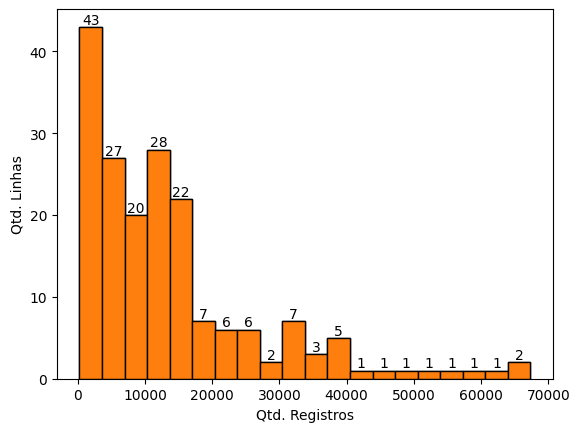

In [16]:
# Verificando a quantidade de rotas em cada Linha para removermos linhas com poucas observações ou muitas observações
qtd_rotas_p_linha = pd.DataFrame(df.groupby('Linha')['Sentido'].count())
print(qtd_rotas_p_linha['Sentido'].describe())
# Plotar o histograma
plt.hist(qtd_rotas_p_linha['Sentido'], bins=20, edgecolor='black')  # 'data' são os dados, 'bins' é o número de intervalos
# Adicionar rótulos com o número de itens em cada bin
hist, bins, _ = plt.hist(qtd_rotas_p_linha['Sentido'], bins=20, edgecolor='black')
for i in range(len(hist)):
    plt.text(bins[i] + (bins[i + 1] - bins[i]) / 2, hist[i], str(int(hist[i])),ha='center', va='bottom')
plt.xlabel('Qtd. Registros')  # Rótulo do eixo x
plt.ylabel('Qtd. Linhas')  # Rótulo do eixo y
# Exibir o histograma
plt.savefig("Results/histograma_registros_p_rota.svg")
# plt.show()

In [17]:
# Removendo as linhas com quantidade de rotas fora do primeiro e terceiro quartil
rotas_entre_primeiro_terceiro_qaurtil = qtd_rotas_p_linha.loc[(qtd_rotas_p_linha['Sentido'] > 3900)&(qtd_rotas_p_linha['Sentido']<16900)].index.values
df = df.loc[df['Linha'].isin(rotas_entre_primeiro_terceiro_qaurtil)]
df

Sentido Linha  DuraçãoViagem  TotalGiros  KmPerc                 Ini  \
179       Volta   101           1320           2   5.418 2019-04-30 06:30:00   
180       Volta   101           1200          12   5.418 2019-04-30 07:10:00   
181       Volta   101           1200           4   5.418 2019-04-30 07:50:00   
182       Volta   101           2340          10   5.418 2019-04-30 08:25:00   
183       Volta   101           1440           3   5.418 2019-04-30 09:30:00   
...         ...   ...            ...         ...     ...                 ...   
2694235   Volta  M940            780           0   8.622 2019-09-01 17:47:00   
2694236   Volta  M940            660           0   8.622 2019-09-01 18:32:00   
2694237   Volta  M940            660           2   8.622 2019-09-01 21:20:00   
2694238   Volta  M940            660           0   8.622 2019-09-01 22:15:00   
2694239   Volta  M940            660           0   8.622 2019-09-01 23:28:00   

                        Fim  dia_semana  hora_dia  dia_ano  mes_ano  turno_dia  
179     2019-04-30 06:52:00           2         6      120        4          2  
180     2019-04-30 07:30:00           2         7      120        4          2  
181     2019-04-30 08:10:00           2         7      120        4          2  
182     2019-04-30 09:04:00           2         8      120        4          2  
183     2019-04-30 09:54:00           2         9      120        4          2  
...                     ...         ...       ...      ...      ...        ...  
2694235 2019-09-01 18:00:00           7        17      244        9          2  
2694236 2019-09-01 18:43:00           7        18      244        9          4  
2694237 2019-09-01 21:31:00           7        21      244        9          4  
2694238 2019-09-01 22:26:00           7        22      244        9          4  
2694239 2019-09-01 23:39:00           7        23      244        9          4  

[973610 rows x 12 columns]

In [18]:
# Analisando se a quantidade de idas e voltas de cada linha está Ok. Concluimos que está ok e não removemos nenhum linha
ida_voltas_linhas = df.groupby('Linha')['Sentido'].value_counts().unstack(fill_value=0)
ida_voltas_linhas['Diferenca'] = ida_voltas_linhas['Ida'] - ida_voltas_linhas['Volta']
ida_voltas_linhas.sort_values(by='Diferenca')

Sentido   Ida  Volta  Diferenca
Linha                          
138         0  16346     -16346
136         0  16296     -16296
137         0  15949     -15949
135         0  15936     -15936
772         0  10950     -10950
...       ...    ...        ...
274      2790   2202        588
281      8657   7953        704
330V     6235   5511        724
1129     6954   6226        728
605      3916      0       3916

[95 rows x 3 columns]

In [19]:
# Fazendo um encoding da coluna Sentido, pois o modelo XGB não aceita informações categoricas.
df['Sentido'] = df['Sentido'].map({'Ida': 0, 'Volta': 1})

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\2206277558.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentido'] = df['Sentido'].map({'Ida': 0, 'Volta': 1})


In [20]:
# Analisando número de Giros por linhas. Tem valores estranhos e que não fazem sentido, porém de decidimos deixar para rodar nos modelos, retimos apenas a linha 110 que estava toda zerada
df.groupby(['Linha'])['TotalGiros'].mean().reset_index().sort_values(by='TotalGiros')

Linha  TotalGiros
2    110    0.003722
58   362    4.119939
40   180    4.325447
38   178    5.977037
91   943    6.096262
..   ...         ...
17   136   44.577320
54   294   46.153422
19   138   48.245626
16   135   50.508471
86   840   56.329857

[95 rows x 2 columns]

In [21]:
df_mean = df.copy()
df_mean["data"] = df_mean["Ini"].dt.date
df_mean = df_mean.groupby(["Linha", "data", "hora_dia"], as_index=False).agg({"TotalGiros": "mean"}).reset_index(drop=True)
df_mean.rename({"TotalGiros": "TotalGirosMean"}, axis=1, inplace=True)
df_mean

Linha        data  hora_dia  TotalGirosMean
0        101  2018-11-01         6             5.0
1        101  2018-11-01         7             7.0
2        101  2018-11-01         8             6.0
3        101  2018-11-01         9             7.0
4        101  2018-11-01        10             1.0
...      ...         ...       ...             ...
440175  M940  2019-10-31        19             8.0
440176  M940  2019-10-31        20             4.5
440177  M940  2019-10-31        21             2.5
440178  M940  2019-10-31        22             4.0
440179  M940  2019-10-31        23             2.5

[440180 rows x 4 columns]

In [22]:
df["d-1"] = df["Ini"].dt.date - pd.Timedelta(days=1)
df = pd.merge(left=df, right=df_mean, left_on=["Linha", "d-1", "hora_dia"], right_on=["Linha", "data", "hora_dia"])
df.drop(["d-1", "data"], axis=1, inplace=True)
df

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\4244930809.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["d-1"] = df["Ini"].dt.date - pd.Timedelta(days=1)


Sentido Linha  DuraçãoViagem  TotalGiros  KmPerc                 Ini  \
0             1   101           1320           2   5.418 2019-04-30 06:30:00   
1             1   101           1200          12   5.418 2019-04-30 07:10:00   
2             1   101           1200           4   5.418 2019-04-30 07:50:00   
3             1   101           2340          10   5.418 2019-04-30 08:25:00   
4             1   101           1440           3   5.418 2019-04-30 09:30:00   
...         ...   ...            ...         ...     ...                 ...   
835345        1  M940           2280          10   8.622 2019-09-29 05:24:00   
835346        1  M940           1020           0   8.622 2019-09-28 10:59:00   
835347        1  M940           1080           2   8.622 2019-09-22 16:59:00   
835348        1  M940           2700          18   8.622 2019-09-16 13:17:00   
835349        1  M940            960           1   8.622 2019-09-14 10:59:00   

                       Fim  dia_semana  hora_dia  dia_ano  mes_ano  turno_dia  \
0      2019-04-30 06:52:00           2         6      120        4          2   
1      2019-04-30 07:30:00           2         7      120        4          2   
2      2019-04-30 08:10:00           2         7      120        4          2   
3      2019-04-30 09:04:00           2         8      120        4          2   
4      2019-04-30 09:54:00           2         9      120        4          2   
...                    ...         ...       ...      ...      ...        ...   
835345 2019-09-29 06:02:00           7         5      272        9          1   
835346 2019-09-28 11:16:00           6        10      271        9          2   
835347 2019-09-22 17:17:00           7        16      265        9          2   
835348 2019-09-16 14:02:00           1        13      259        9          2   
835349 2019-09-14 11:15:00           6        10      257        9          2   

        TotalGirosMean  
0             3.000000  
1             7.000000  
2             7.000000  
3             7.000000  
4             7.000000  
...                ...  
835345       12.000000  
835346       12.000000  
835347        3.666667  
835348        4.000000  
835349       13.000000  

[835350 rows x 13 columns]

In [23]:
# Olhando na mão linha a linha
df.loc[df['Linha']=='110']#.groupby('turno_dia').size()

Sentido Linha  DuraçãoViagem  TotalGiros  KmPerc                 Ini  \
710           0   110           1140           0   7.629 2019-04-30 08:34:00   
711           0   110           1680           0   7.629 2019-04-30 08:04:00   
712           1   110           1080           0   7.713 2019-04-30 08:16:00   
713           1   110           1080           0   7.713 2019-04-30 08:32:00   
714           0   110           1200           0   7.629 2019-04-30 12:25:00   
...         ...   ...            ...         ...     ...                 ...   
768798        1   110           2040           0   7.713 2019-09-05 19:13:00   
768799        1   110            900           0   7.713 2019-09-04 19:08:00   
768800        1   110           1740           0   7.713 2019-09-04 19:12:00   
768801        1   110           1020           0   7.713 2019-09-03 19:04:00   
768802        1   110           2340           0   7.713 2019-09-03 19:13:00   

                       Fim  dia_semana  hora_dia  dia_ano  mes_ano  turno_dia  \
710    2019-04-30 08:53:00           2         8      120        4          2   
711    2019-04-30 08:32:00           2         8      120        4          2   
712    2019-04-30 08:34:00           2         8      120        4          2   
713    2019-04-30 08:50:00           2         8      120        4          2   
714    2019-04-30 12:45:00           2        12      120        4          2   
...                    ...         ...       ...      ...      ...        ...   
768798 2019-09-05 19:47:00           4        19      248        9          4   
768799 2019-09-04 19:23:00           3        19      247        9          4   
768800 2019-09-04 19:41:00           3        19      247        9          4   
768801 2019-09-03 19:21:00           2        19      246        9          4   
768802 2019-09-03 19:52:00           2        19      246        9          4   

        TotalGirosMean  
710                0.0  
711                0.0  
712                0.0  
713                0.0  
714                0.0  
...                ...  
768798             0.0  
768799             0.0  
768800             0.0  
768801             0.0  
768802             0.0  

[12025 rows x 13 columns]

In [24]:
# Remoção da linha 110
df = df.loc[df['Linha'] != '110']
df

Sentido Linha  DuraçãoViagem  TotalGiros  KmPerc                 Ini  \
0             1   101           1320           2   5.418 2019-04-30 06:30:00   
1             1   101           1200          12   5.418 2019-04-30 07:10:00   
2             1   101           1200           4   5.418 2019-04-30 07:50:00   
3             1   101           2340          10   5.418 2019-04-30 08:25:00   
4             1   101           1440           3   5.418 2019-04-30 09:30:00   
...         ...   ...            ...         ...     ...                 ...   
835345        1  M940           2280          10   8.622 2019-09-29 05:24:00   
835346        1  M940           1020           0   8.622 2019-09-28 10:59:00   
835347        1  M940           1080           2   8.622 2019-09-22 16:59:00   
835348        1  M940           2700          18   8.622 2019-09-16 13:17:00   
835349        1  M940            960           1   8.622 2019-09-14 10:59:00   

                       Fim  dia_semana  hora_dia  dia_ano  mes_ano  turno_dia  \
0      2019-04-30 06:52:00           2         6      120        4          2   
1      2019-04-30 07:30:00           2         7      120        4          2   
2      2019-04-30 08:10:00           2         7      120        4          2   
3      2019-04-30 09:04:00           2         8      120        4          2   
4      2019-04-30 09:54:00           2         9      120        4          2   
...                    ...         ...       ...      ...      ...        ...   
835345 2019-09-29 06:02:00           7         5      272        9          1   
835346 2019-09-28 11:16:00           6        10      271        9          2   
835347 2019-09-22 17:17:00           7        16      265        9          2   
835348 2019-09-16 14:02:00           1        13      259        9          2   
835349 2019-09-14 11:15:00           6        10      257        9          2   

        TotalGirosMean  
0             3.000000  
1             7.000000  
2             7.000000  
3             7.000000  
4             7.000000  
...                ...  
835345       12.000000  
835346       12.000000  
835347        3.666667  
835348        4.000000  
835349       13.000000  

[823325 rows x 13 columns]

   Linha  DuraçãoViagem
51   282     296.364647
83   769     299.876240
25   162     306.562234
57   362     315.378457
80   762     324.562481
..   ...            ...
7   1122     997.593026
16   136    1031.680272
18   138    1054.397896
85   840    1113.281266
41  2120    1121.693846

[94 rows x 2 columns]


Text(0.5, 1.0, 'Série Temporal')

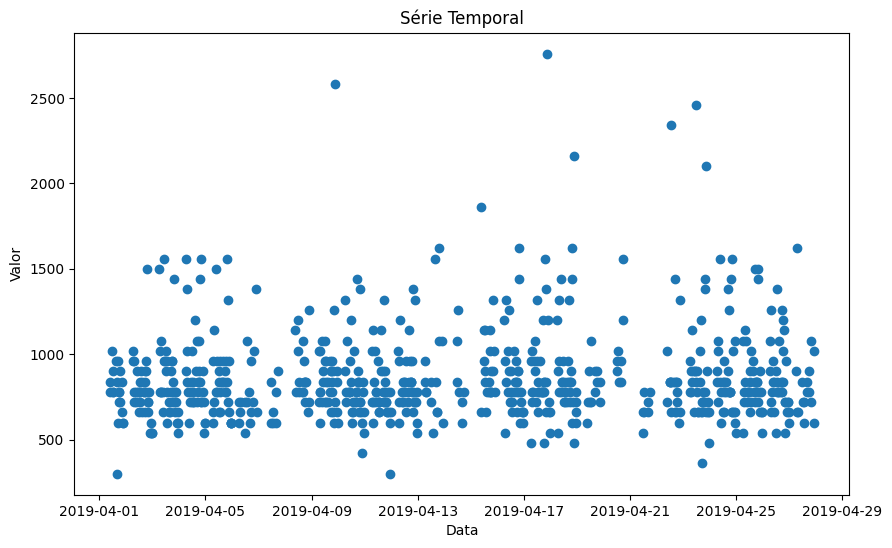

In [25]:
# Analisando o desvio padrão das durações de viagem de cada rota e plotando os valores de uma no gáfico
print(df.groupby('Linha')['DuraçãoViagem'].std().reset_index().sort_values(by='DuraçãoViagem'))
df_plot = df.loc[df['Linha'] == '362'][['Ini','DuraçãoViagem']].sort_values(by='Ini')
df_plot = df_plot[(df_plot["Ini"] > "2019-04-01") & (df_plot["Ini"] < "2019-04-28")]
df_plot.set_index('Ini', inplace=True)

plt.figure(figsize=(10, 6))
plt.scatter(df_plot.index, df_plot['DuraçãoViagem'])
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Série Temporal')
# plt.show()

In [26]:
#Remoção dos outliers de cada Linha
# IQR Method (Interquartile Range):
def remove_outlier(valores):
    Q1 = np.percentile(valores,25)
    Q3 = np.percentile(valores,75)
    intervalo = Q3-Q1
    limite_superior = Q3+intervalo*1.5
    limite_inferior = Q1-intervalo*1.5
    return limite_superior,limite_inferior

linhas = df['Linha'].unique()
outliers_indexs = []
for linha in linhas:
    aux = df.loc[df['Linha'] == linha]['DuraçãoViagem']
    limite_superior,limite_inferior = remove_outlier(aux)
    aux = aux.loc[(aux.values > limite_superior) | (aux.values < limite_inferior)]
    outliers_indexs.extend(aux.index)
df.drop(outliers_indexs,inplace=True)
df.reset_index(drop=True,inplace=True)
df

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\2474428967.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(outliers_indexs,inplace=True)


Sentido Linha  DuraçãoViagem  TotalGiros  KmPerc                 Ini  \
0             1   101           1320           2   5.418 2019-04-30 06:30:00   
1             1   101           1200          12   5.418 2019-04-30 07:10:00   
2             1   101           1200           4   5.418 2019-04-30 07:50:00   
3             1   101           2340          10   5.418 2019-04-30 08:25:00   
4             1   101           1440           3   5.418 2019-04-30 09:30:00   
...         ...   ...            ...         ...     ...                 ...   
797202        1  M940           2280          10   8.622 2019-09-29 05:24:00   
797203        1  M940           1020           0   8.622 2019-09-28 10:59:00   
797204        1  M940           1080           2   8.622 2019-09-22 16:59:00   
797205        1  M940           2700          18   8.622 2019-09-16 13:17:00   
797206        1  M940            960           1   8.622 2019-09-14 10:59:00   

                       Fim  dia_semana  hora_dia  dia_ano  mes_ano  turno_dia  \
0      2019-04-30 06:52:00           2         6      120        4          2   
1      2019-04-30 07:30:00           2         7      120        4          2   
2      2019-04-30 08:10:00           2         7      120        4          2   
3      2019-04-30 09:04:00           2         8      120        4          2   
4      2019-04-30 09:54:00           2         9      120        4          2   
...                    ...         ...       ...      ...      ...        ...   
797202 2019-09-29 06:02:00           7         5      272        9          1   
797203 2019-09-28 11:16:00           6        10      271        9          2   
797204 2019-09-22 17:17:00           7        16      265        9          2   
797205 2019-09-16 14:02:00           1        13      259        9          2   
797206 2019-09-14 11:15:00           6        10      257        9          2   

        TotalGirosMean  
0             3.000000  
1             7.000000  
2             7.000000  
3             7.000000  
4             7.000000  
...                ...  
797202       12.000000  
797203       12.000000  
797204        3.666667  
797205        4.000000  
797206       13.000000  

[797207 rows x 13 columns]

   Linha  DuraçãoViagem
0    362     178.799001
1    162     200.062211
2    271     200.500940
3    169     203.888001
4    168     211.184265
..   ...            ...
89   136     768.143369
90   135     788.268836
91   138     808.558630
92   235     848.243518
93  4122     864.089809

[94 rows x 2 columns]


Text(0.5, 1.0, 'Série Temporal')

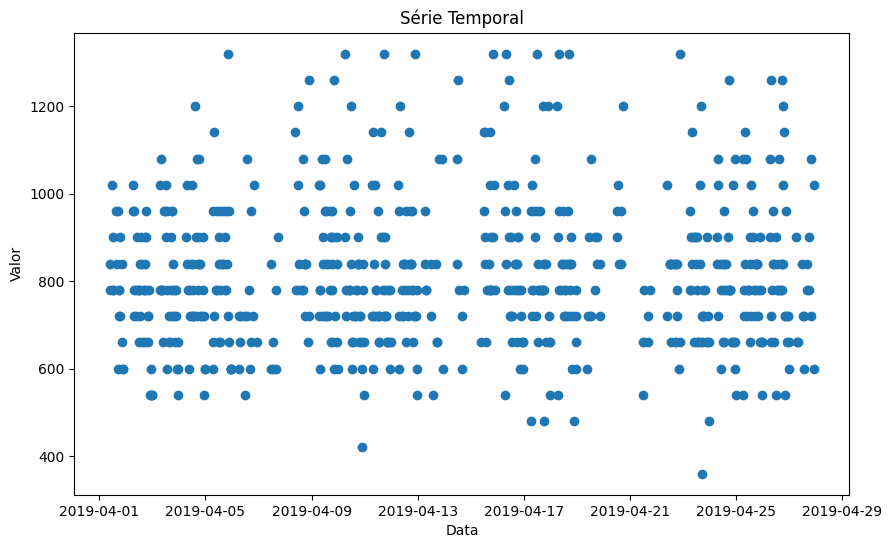

In [27]:
# Voltando a analisar o desvio padrão das durações de viagem de cada rota e plotando os valores de uma no gáfico após a remoçao dos outliers
a = df.groupby('Linha')['DuraçãoViagem'].std().reset_index().sort_values(by='DuraçãoViagem').reset_index(drop=True)
print(a)
df_plot = df.loc[df['Linha'] == '362'][['Ini','DuraçãoViagem']].sort_values(by='Ini')
df_plot = df_plot[(df_plot["Ini"] > "2019-04-01") & (df_plot["Ini"] < "2019-04-28")]
df_plot.set_index('Ini', inplace=True)

plt.figure(figsize=(10, 6))
plt.scatter(df_plot.index, df_plot['DuraçãoViagem'])
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Série Temporal')
# plt.show()

In [28]:
#Selecionando as rotas que serão usadas nos teste
a.iloc[[0,1,64,65,92,93]]

Linha  DuraçãoViagem
0    362     178.799001
1    162     200.062211
64   605     518.593351
65  1123     530.362203
92   235     848.243518
93  4122     864.089809

In [29]:
# Deixando o dataframe apenas com as rotas que serão utilizadas
df = df.loc[df['Linha'].isin(['362','271','605','1120','235','4122'])].reset_index(drop=True).sort_values(by=['Linha','Ini'],ascending=[True,True])
df

Sentido Linha  DuraçãoViagem  TotalGiros  KmPerc                 Ini  \
29315        0  1120           3420          21  31.218 2018-11-06 06:10:00   
29316        0  1120           4560          26  31.218 2018-11-06 06:44:00   
29394        1  1120           3720           6  30.640 2018-11-06 07:08:00   
29317        0  1120           4320          30  31.218 2018-11-06 08:10:00   
29318        1  1120           3060           4  30.640 2018-11-06 08:14:00   
...        ...   ...            ...         ...     ...                 ...   
35277        0   605           3900          16  19.437 2019-10-31 12:51:00   
35278        0   605           3780          10  19.437 2019-10-31 13:39:00   
35279        0   605           3780          18  19.437 2019-10-31 15:57:00   
35280        0   605           4440          26  19.437 2019-10-31 16:58:00   
35281        0   605           2580           2  19.437 2019-10-31 19:54:00   

                      Fim  dia_semana  hora_dia  dia_ano  mes_ano  turno_dia  \
29315 2018-11-06 07:07:00           2         6      310       11          2   
29316 2018-11-06 08:00:00           2         6      310       11          2   
29394 2018-11-06 08:10:00           2         7      310       11          2   
29317 2018-11-06 09:22:00           2         8      310       11          2   
29318 2018-11-06 09:05:00           2         8      310       11          2   
...                   ...         ...       ...      ...      ...        ...   
35277 2019-10-31 13:56:00           4        12      304       10          2   
35278 2019-10-31 14:42:00           4        13      304       10          2   
35279 2019-10-31 17:00:00           4        15      304       10          2   
35280 2019-10-31 18:12:00           4        16      304       10          2   
35281 2019-10-31 20:37:00           4        19      304       10          4   

       TotalGirosMean  
29315            22.0  
29316            22.0  
29394             8.0  
29317            11.0  
29318            11.0  
...               ...  
35277            17.0  
35278             5.0  
35279            10.5  
35280            27.0  
35281             3.0  

[38726 rows x 13 columns]

In [30]:
# Dados gerais das rotas usadas
df.groupby('Linha').agg({'KmPerc':'max', 'Sentido':'count'})

KmPerc  Sentido
Linha                 
1120   31.218     4582
235    24.110     4673
271    13.903    14001
362     4.240     8565
4122   25.244     4041
605    19.437     2864

In [31]:
print(df.shape)
len(df['Linha'].unique())

(38726, 13)


6

In [32]:
# Exportando o Dataframe
df.to_csv('dados_floripa_tratado.csv',index=False)

# Criação dos Modelos e Testes

## Teste Inicial

### Função que cria os 3 modelos e salva seus resultados

In [33]:
predictions = []
metrics = []

# Hyperparâmetros do XGBoosting
params_xgb = {
         "n_estimators": list(range(100, 1100, 100)), #Number of gradient boosted trees. Equivalent to number of boosting rounds
         "max_depth": list(range(2, 15)),#Maximum tree depth for base learners.
         "min_child_weight": list(range(1, 11)),#Minimum sum of instance weight(hessian) needed in a child.
         "learning_rate": [0.3, 0.2, 0.1, 0.05, 0.01, 0.005],#Boosting learning rate (xgb’s “eta”)
         "gamma": np.arange(0, 0.7, 0.1)#Minimum loss reduction required to make a further partition on a leaf node of the tree.
        }

# Hyperparâmetros do Random Forest
params_rf = {
         "n_estimators": list(range(100, 1100, 100)),#The number of trees in the forest.
         "bootstrap": [True, False],#Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.
         "max_depth": list(range(2, 15)),#The maximum depth of the tree.
         "max_features": [1.0, "sqrt", "log2"],#The number of features to consider when looking for the best split:
         "min_samples_leaf": list(range(1, 11)),#The minimum number of samples required to split an internal node
         "min_samples_split": list(range(2, 11)),#The minimum number of samples required to be at a leaf node.
        }

def cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome, randomizedSearch = False):

    #Treino do Modelo XGB e salvamento do tempo
    inicio_tempo_treino_xgb = datetime.now()
    modelo_xgb = xgb.XGBRegressor()

    if not randomizedSearch:
        modelo_xgb.fit(x_treino, y_treino, eval_set = [(x_treino, y_treino)])
    else:
        xgb_rand_search = RandomizedSearchCV(modelo_xgb, params_xgb, scoring="neg_mean_squared_error", n_iter=40, verbose=True, cv=10, n_jobs=-1, random_state=123)
        xgb_rand_search.fit(x_treino, y_treino)
        modelo_xgb = xgb_rand_search.best_estimator_

        modelo_xgb.fit(x_treino, y_treino, eval_set = [(x_treino, y_treino)])

    fim_tempo_treino_xgb = datetime.now()
    tempo_treino_xgb = fim_tempo_treino_xgb - inicio_tempo_treino_xgb
    tempo_treino_xgb = float(f"{str(tempo_treino_xgb.seconds)}.{str(tempo_treino_xgb.microseconds)}")

    #Treino do Modelo RF e salvamento do tempo
    inicio_tempo_treino_rf = datetime.now()
    modelo_rf = RandomForestRegressor()

    if not randomizedSearch:
        modelo_rf.fit(x_treino, y_treino)
    else:
        rf_rand_search = RandomizedSearchCV(modelo_rf, params_rf, scoring="neg_mean_squared_error", n_iter=40, verbose=True, cv=10, n_jobs=-1, random_state=123)
        rf_rand_search.fit(x_treino, y_treino)
        modelo_rf = rf_rand_search.best_estimator_

        modelo_rf.fit(x_treino, y_treino)

    fim_tempo_treino_rf = datetime.now()
    tempo_treino_rf = fim_tempo_treino_rf - inicio_tempo_treino_rf
    tempo_treino_rf = float(f"{str(tempo_treino_rf.seconds)}.{str(tempo_treino_rf.microseconds)}")

    #Treino do Modelo LR e salvamento do tempo
    inicio_tempo_treino_lr = datetime.now()
    modelo_lr = LinearRegression()
    modelo_lr.fit(x_treino, y_treino)

    fim_tempo_treino_lr = datetime.now()
    tempo_treino_lr = fim_tempo_treino_lr - inicio_tempo_treino_lr
    tempo_treino_lr = float(f"{str(tempo_treino_lr.seconds)}.{str(tempo_treino_lr.microseconds)}")

    #Nomeando a coluna que receberá as previsões
    TesteNomeXGB = f"XGB - {teste_nome}"
    TesteNomeRF = f"RF - {teste_nome}"
    TesteNomeLR = f"LR - {teste_nome}"

    #Predição do XGB e salvamento do tempo
    inicio_tempo_previsao_xgb = datetime.now()
    df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
    fim_tempo_previsao_xgb = datetime.now()
    tempo_previsao_xgb = fim_tempo_previsao_xgb - inicio_tempo_previsao_xgb
    tempo_previsao_xgb = float(f"{str(tempo_previsao_xgb.seconds)}.{str(tempo_previsao_xgb.microseconds)}")

    #Predição do RF e salvamento do tempo
    inicio_tempo_previsao_rf = datetime.now()
    df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
    fim_tempo_previsao_rf = datetime.now()
    tempo_previsao_rf = fim_tempo_previsao_rf - inicio_tempo_previsao_rf
    tempo_previsao_rf = float(f"{str(tempo_previsao_rf.seconds)}.{str(tempo_previsao_rf.microseconds)}")

    #Predição do LR e salvamento do tempo
    inicio_tempo_previsao_lr = datetime.now()
    df_teste[f'{TesteNomeLR}'] = modelo_lr.predict(x_teste)
    fim_tempo_previsao_lr = datetime.now()
    tempo_previsao_lr = fim_tempo_previsao_lr - inicio_tempo_previsao_lr
    tempo_previsao_lr = float(f"{str(tempo_previsao_lr.seconds)}.{str(tempo_previsao_lr.microseconds)}")

    #Métricas do XGB
    RMSE_xgb = np.sqrt(mtr.mean_squared_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeXGB}"]))
    MAPE_xgb = mtr.mean_absolute_percentage_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeXGB}"])

    #Métricas do RF
    RMSE_rf = np.sqrt(mtr.mean_squared_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeRF}"]))
    MAPE_rf = mtr.mean_absolute_percentage_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeRF}"])

    #Métricas do LR
    RMSE_lr = np.sqrt(mtr.mean_squared_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeLR}"]))
    MAPE_lr = mtr.mean_absolute_percentage_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeLR}"])

    #Salvando as métricas num DataFrame Bonitinho
    metrics.append([f'{teste_nome}', rota,'XGBoost','RMSE',RMSE_xgb, tempo_treino_xgb, tempo_previsao_xgb])
    metrics.append([f'{teste_nome}', rota,'XGBoost','MAPE',MAPE_xgb, tempo_treino_xgb, tempo_previsao_xgb])
    metrics.append([f'{teste_nome}', rota,'Random Forest','RMSE',RMSE_rf, tempo_treino_rf, tempo_previsao_rf])
    metrics.append([f'{teste_nome}', rota,'Random Forest','MAPE',MAPE_rf, tempo_treino_rf, tempo_previsao_rf])
    metrics.append([f'{teste_nome}', rota,'Linear Regression','RMSE',RMSE_lr, tempo_treino_lr, tempo_previsao_lr])
    metrics.append([f'{teste_nome}', rota,'Linear Regression','MAPE',MAPE_lr, tempo_treino_lr, tempo_previsao_lr])

    #Salvando as predições num DataFrame Bonitinho
    for i in range(df_teste.shape[0]):
        predictions.append([f'{teste_nome}', df_teste['Ini'].iloc[i], rota,'XGBoost',df_teste[f"{TesteNomeXGB}"].iloc[i]])
        predictions.append([f'{teste_nome}', df_teste['Ini'].iloc[i], rota,'Random Forest',df_teste[f"{TesteNomeRF}"].iloc[i]])
        predictions.append([f'{teste_nome}', df_teste['Ini'].iloc[i], rota,'Linear Regression',df_teste[f"{TesteNomeLR}"].iloc[i]])
        predictions.append([f'{teste_nome}', df_teste['Ini'].iloc[i], rota,'Tempo real',df_teste["DuraçãoViagem"].iloc[i]])


    fi_xgb = pd.DataFrame(data=modelo_xgb.feature_importances_, index=modelo_xgb.feature_names_in_, columns=["importance"])
    fi_xgb["Teste"] = teste_nome
    fi_xgb = fi_xgb.reset_index().pivot(index="Teste", columns="index", values="importance")

    
    fi_rf = pd.DataFrame(data=modelo_rf.feature_importances_, index=x_treino.columns, columns=["importance"])
    fi_rf["Teste"] = teste_nome
    fi_rf = fi_rf.reset_index().pivot(index="Teste", columns="index", values="importance")

    return fi_xgb, fi_rf

### Execuções por rotas

In [34]:
Colunas = [
    ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']
]
TestesNome = [
    "0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']"

]
importance = pd.DataFrame(columns=["KmPerc", "Sentido", "dia_ano", "dia_semana", "hora_dia", "mes_ano", "turno_dia", "TotalGirosMean"])

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    shape = int(df_modelo.shape[0] * 0.3)
    df_teste = df_modelo[:shape]
    df_treino = df_modelo[shape:]
    for i in range(len(TestesNome)):
        teste_nome = TestesNome[i]
        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[Colunas[i]]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[Colunas[i]]
        y_treino = df_treino["DuraçãoViagem"]

        fi_xgb, fi_rf = cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)
        fi_xgb["rota"], fi_rf["rota"] = rota, rota
        fi_xgb["modelo"], fi_rf["modelo"] = "XGB", "RF"

        importance = pd.concat([importance, fi_xgb, fi_rf])


[0]	validation_0-rmse:2761.67779
[1]	validation_0-rmse:1958.67208
[2]	validation_0-rmse:1403.68083
[3]	validation_0-rmse:1024.18370
[4]	validation_0-rmse:768.71614
[5]	validation_0-rmse:601.40748
[6]	validation_0-rmse:496.68425
[7]	validation_0-rmse:432.87627
[8]	validation_0-rmse:394.61285
[9]	validation_0-rmse:370.44435
[10]	validation_0-rmse:357.12341
[11]	validation_0-rmse:347.86716
[12]	validation_0-rmse:342.78816
[13]	validation_0-rmse:339.77326
[14]	validation_0-rmse:336.65660
[15]	validation_0-rmse:334.14750
[16]	validation_0-rmse:331.30526
[17]	validation_0-rmse:329.13079
[18]	validation_0-rmse:323.01812
[19]	validation_0-rmse:320.56431
[20]	validation_0-rmse:319.20777
[21]	validation_0-rmse:317.28602
[22]	validation_0-rmse:315.55828
[23]	validation_0-rmse:312.62790
[24]	validation_0-rmse:311.91820
[25]	validation_0-rmse:310.79285
[26]	validation_0-rmse:306.81700
[27]	validation_0-rmse:303.73995
[28]	validation_0-rmse:302.14782
[29]	validation_0-rmse:300.27992
[30]	validation_

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1940.63217
[1]	validation_0-rmse:1387.73944
[2]	validation_0-rmse:1006.96975
[3]	validation_0-rmse:750.47421
[4]	validation_0-rmse:577.09250
[5]	validation_0-rmse:468.71314
[6]	validation_0-rmse:402.60223
[7]	validation_0-rmse:364.23219
[8]	validation_0-rmse:337.27774
[9]	validation_0-rmse:318.88808
[10]	validation_0-rmse:307.86984
[11]	validation_0-rmse:300.54854
[12]	validation_0-rmse:295.19055
[13]	validation_0-rmse:289.79707
[14]	validation_0-rmse:285.18907
[15]	validation_0-rmse:280.60777
[16]	validation_0-rmse:278.47147
[17]	validation_0-rmse:274.46901
[18]	validation_0-rmse:273.22146
[19]	validation_0-rmse:272.20484
[20]	validation_0-rmse:269.17100
[21]	validation_0-rmse:267.96191
[22]	validation_0-rmse:264.34986
[23]	validation_0-rmse:263.56489
[24]	validation_0-rmse:261.36051
[25]	validation_0-rmse:260.15530
[26]	validation_0-rmse:258.20973
[27]	validation_0-rmse:255.75595
[28]	validation_0-rmse:254.30276
[29]	validation_0-rmse:253.83325
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1014.32796
[1]	validation_0-rmse:721.30449
[2]	validation_0-rmse:520.01768
[3]	validation_0-rmse:383.69737
[4]	validation_0-rmse:292.86982
[5]	validation_0-rmse:236.04899
[6]	validation_0-rmse:201.69334
[7]	validation_0-rmse:182.51564
[8]	validation_0-rmse:172.02823
[9]	validation_0-rmse:166.16801
[10]	validation_0-rmse:162.40734
[11]	validation_0-rmse:159.53501
[12]	validation_0-rmse:156.98306
[13]	validation_0-rmse:155.81482
[14]	validation_0-rmse:155.24720
[15]	validation_0-rmse:154.82973
[16]	validation_0-rmse:153.41932
[17]	validation_0-rmse:152.18165
[18]	validation_0-rmse:151.68424
[19]	validation_0-rmse:150.75104
[20]	validation_0-rmse:149.33459
[21]	validation_0-rmse:149.06063
[22]	validation_0-rmse:148.05673
[23]	validation_0-rmse:147.59353
[24]	validation_0-rmse:147.12460
[25]	validation_0-rmse:146.06885
[26]	validation_0-rmse:145.88036
[27]	validation_0-rmse:145.33102
[28]	validation_0-rmse:144.44346
[29]	validation_0-rmse:144.33721
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:603.73921
[1]	validation_0-rmse:437.18497
[2]	validation_0-rmse:324.56813
[3]	validation_0-rmse:250.55170
[4]	validation_0-rmse:204.05507
[5]	validation_0-rmse:175.79365
[6]	validation_0-rmse:159.27288
[7]	validation_0-rmse:150.01033
[8]	validation_0-rmse:144.55710
[9]	validation_0-rmse:141.47444
[10]	validation_0-rmse:138.69459
[11]	validation_0-rmse:136.18277
[12]	validation_0-rmse:135.43487
[13]	validation_0-rmse:135.00958
[14]	validation_0-rmse:134.21333
[15]	validation_0-rmse:133.11017
[16]	validation_0-rmse:131.95821
[17]	validation_0-rmse:131.64292
[18]	validation_0-rmse:131.37758
[19]	validation_0-rmse:130.90655
[20]	validation_0-rmse:130.16379
[21]	validation_0-rmse:129.20634
[22]	validation_0-rmse:128.52396
[23]	validation_0-rmse:128.25757
[24]	validation_0-rmse:127.44741
[25]	validation_0-rmse:126.95012
[26]	validation_0-rmse:126.43814
[27]	validation_0-rmse:125.70047
[28]	validation_0-rmse:125.47579
[29]	validation_0-rmse:124.92169
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2259.62983
[1]	validation_0-rmse:1621.20862
[2]	validation_0-rmse:1183.72499
[3]	validation_0-rmse:888.87951
[4]	validation_0-rmse:695.56787
[5]	validation_0-rmse:570.77886
[6]	validation_0-rmse:496.75807
[7]	validation_0-rmse:450.73670
[8]	validation_0-rmse:425.68055
[9]	validation_0-rmse:407.03411
[10]	validation_0-rmse:398.12362
[11]	validation_0-rmse:389.65748
[12]	validation_0-rmse:385.42991
[13]	validation_0-rmse:381.35636
[14]	validation_0-rmse:376.21088
[15]	validation_0-rmse:372.62739
[16]	validation_0-rmse:369.29024
[17]	validation_0-rmse:363.55499
[18]	validation_0-rmse:360.84073
[19]	validation_0-rmse:360.13643
[20]	validation_0-rmse:357.42087
[21]	validation_0-rmse:353.83128
[22]	validation_0-rmse:352.84695
[23]	validation_0-rmse:350.25943
[24]	validation_0-rmse:346.22833
[25]	validation_0-rmse:345.75525
[26]	validation_0-rmse:342.05751
[27]	validation_0-rmse:339.23835
[28]	validation_0-rmse:335.75313
[29]	validation_0-rmse:333.27042
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2346.25283
[1]	validation_0-rmse:1665.20358
[2]	validation_0-rmse:1194.39764
[3]	validation_0-rmse:872.83237
[4]	validation_0-rmse:657.28979
[5]	validation_0-rmse:516.80842
[6]	validation_0-rmse:424.87663
[7]	validation_0-rmse:368.89580
[8]	validation_0-rmse:335.72714
[9]	validation_0-rmse:316.42870
[10]	validation_0-rmse:306.99668
[11]	validation_0-rmse:297.89105
[12]	validation_0-rmse:291.29342
[13]	validation_0-rmse:289.20639
[14]	validation_0-rmse:288.11829
[15]	validation_0-rmse:287.17685
[16]	validation_0-rmse:282.05776
[17]	validation_0-rmse:276.67583
[18]	validation_0-rmse:274.20855
[19]	validation_0-rmse:270.60730
[20]	validation_0-rmse:268.34374
[21]	validation_0-rmse:265.90007
[22]	validation_0-rmse:265.01493
[23]	validation_0-rmse:264.71525
[24]	validation_0-rmse:261.66999
[25]	validation_0-rmse:261.12028
[26]	validation_0-rmse:257.62880
[27]	validation_0-rmse:256.85554
[28]	validation_0-rmse:254.49427
[29]	validation_0-rmse:254.25428
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [35]:
importance

KmPerc   Sentido  \
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.000000  0.231423   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.049021  0.049763   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.936995  0.004383   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.633114  0.006942   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.000000  0.234568   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.032829  0.033061   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.000000  0.289704   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.041069  0.035593   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.000000  0.599654   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.174398  0.148532   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.000000  0.000000   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.000000  0.000000   

                                                     dia_ano  dia_semana  \
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.114384    0.318466   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.260536    0.161396   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.009428    0.003337   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.106688    0.015871   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.168082    0.156913   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.311777    0.112842   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.206855    0.149461   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.387869    0.102233   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.055685    0.026251   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.159922    0.032678   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.121085    0.242612   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.215005    0.157750   

                                                    hora_dia   mes_ano  \
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.252745  0.000000   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.282685  0.029450   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.041605  0.000000   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.166201  0.007783   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.319955  0.000000   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.263530  0.031260   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.231474  0.000000   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.219333  0.041267   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.281177  0.000000   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.215091  0.021737   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.418829  0.000000   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...  0.342467  0.029755   

                                                    turno_dia  TotalGirosMean  \
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...   0.000000        0.082982   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...   0.009028        0.158121   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...   0.000000        0.004253   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...   0.002909        0.060493   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...   0.000000        0.120482   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...   0.007587        0.207114   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...   0.000000        0.122506   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...   0.005852        0.166784   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...   0.000000        0.037233   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...   0.163177        0.084464   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...   0.000000        0.217475   
0 Teste de Colunas - ['Sentido','KmPerc','dia_s...   0.000455        0.254568   

                                                    rota modelo  
0 Teste de Colunas 

In [36]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[a['Métrica'] == 'MAPE'].sort_values(by='Valor')

Teste  Rota  \
3   0 Teste de Colunas - ['Sentido','KmPerc','dia_...  1120   
1   0 Teste de Colunas - ['Sentido','KmPerc','dia_...  1120   
17  0 Teste de Colunas - ['Sentido','KmPerc','dia_...   271   
13  0 Teste de Colunas - ['Sentido','KmPerc','dia_...   271   
15  0 Teste de Colunas - ['Sentido','KmPerc','dia_...   271   
5   0 Teste de Colunas - ['Sentido','KmPerc','dia_...  1120   
35  0 Teste de Colunas - ['Sentido','KmPerc','dia_...   605   
31  0 Teste de Colunas - ['Sentido','KmPerc','dia_...   605   
33  0 Teste de Colunas - ['Sentido','KmPerc','dia_...   605   
7   0 Teste de Colunas - ['Sentido','KmPerc','dia_...   235   
11  0 Teste de Colunas - ['Sentido','KmPerc','dia_...   235   
9   0 Teste de Colunas - ['Sentido','KmPerc','dia_...   235   
23  0 Teste de Colunas - ['Sentido','KmPerc','dia_...   362   
21  0 Teste de Colunas - ['Sentido','KmPerc','dia_...   362   
19  0 Teste de Colunas - ['Sentido','KmPerc','dia_...   362   
27  0 Teste de Colunas - ['Sentido','KmPerc','dia_...  4122   
25  0 Teste de Colunas - ['Sentido','KmPerc','dia_...  4122   
29  0 Teste de Colunas - ['Sentido','KmPerc','dia_...  4122   

               Modelo Métrica     Valor  Tempo de treino  Tempo de previsão  
3       Random Forest    MAPE  0.081295         0.662340            0.28102  
1             XGBoost    MAPE  0.086519         0.188889            0.34300  
17  Linear Regression    MAPE  0.095755         0.396700            0.20030  
13            XGBoost    MAPE  0.097957         0.253631            0.41770  
15      Random Forest    MAPE  0.100363         1.891651            0.69211  
5   Linear Regression    MAPE  0.102608         0.326100            0.10010  
35  Linear Regression    MAPE  0.104231         0.200100            0.10010  
31            XGBoost    MAPE  0.106932         0.152536            0.29970  
33      Random Forest    MAPE  0.107161         0.418785            0.20145  
7             XGBoost    MAPE  0.123449         0.178511            0.29550  
11  Linear Regression    MAPE  0.129988         0.301500            0.20010  
9       Random Forest    MAPE  0.142742         0.573663            0.19759  
23  Linear Regression    MAPE  0.158572         0.233400            0.20000  
21      Random Forest    MAPE  0.167319         1.158823            0.44223  
19            XGBoost    MAPE  0.168303         0.201236            0.39690  
27      Random Forest    MAPE  0.171129         0.563755            0.21999  
25            XGBoost    MAPE  0.194014         0.152637            0.33380  
29  Linear Regression    MAPE  0.216080         0.197200            0.21090

In [37]:
corr = df.corr()
corr

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\2438084875.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


Sentido  DuraçãoViagem  TotalGiros    KmPerc  dia_semana  \
Sentido         1.000000      -0.038344   -0.130788 -0.078349   -0.004656   
DuraçãoViagem  -0.038344       1.000000    0.378288  0.859106   -0.004924   
TotalGiros     -0.130788       0.378288    1.000000  0.328887   -0.055781   
KmPerc         -0.078349       0.859106    0.328887  1.000000    0.020420   
dia_semana     -0.004656      -0.004924   -0.055781  0.020420    1.000000   
hora_dia        0.071973      -0.104892    0.061999 -0.072912   -0.015228   
dia_ano        -0.000195      -0.043986   -0.012069 -0.037748   -0.006944   
mes_ano        -0.000030      -0.044402   -0.011626 -0.038264   -0.006878   
turno_dia       0.066639      -0.140044   -0.046107 -0.078560   -0.007397   
TotalGirosMean  0.012892       0.391133    0.554278  0.450928    0.010385   

                hora_dia   dia_ano   mes_ano  turno_dia  TotalGirosMean  
Sentido         0.071973 -0.000195 -0.000030   0.066639        0.012892  
DuraçãoViagem  -0.104892 -0.043986 -0.044402  -0.140044        0.391133  
TotalGiros      0.061999 -0.012069 -0.011626  -0.046107        0.554278  
KmPerc         -0.072912 -0.037748 -0.038264  -0.078560        0.450928  
dia_semana     -0.015228 -0.006944 -0.006878  -0.007397        0.010385  
hora_dia        1.000000  0.002601  0.002476   0.727504        0.079882  
dia_ano         0.002601  1.000000  0.996500   0.003367       -0.020454  
mes_ano         0.002476  0.996500  1.000000   0.003486       -0.019513  
turno_dia       0.727504  0.003367  0.003486   1.000000       -0.057598  
TotalGirosMean  0.079882 -0.020454 -0.019513  -0.057598        1.000000

In [38]:
# a.to_excel("Teste0.xlsx", index=False)
# importance.to_excel("Results/Teste_0_importance.xlsx")
# corr.to_excel("Results/Correlacao_Atributos.xlsx")

  Linha  DuraçãoViagem
0   362     178.799001
1   271     200.500940
2   605     518.593351
3  1120     538.178775
4   235     848.243518
5  4122     864.089809


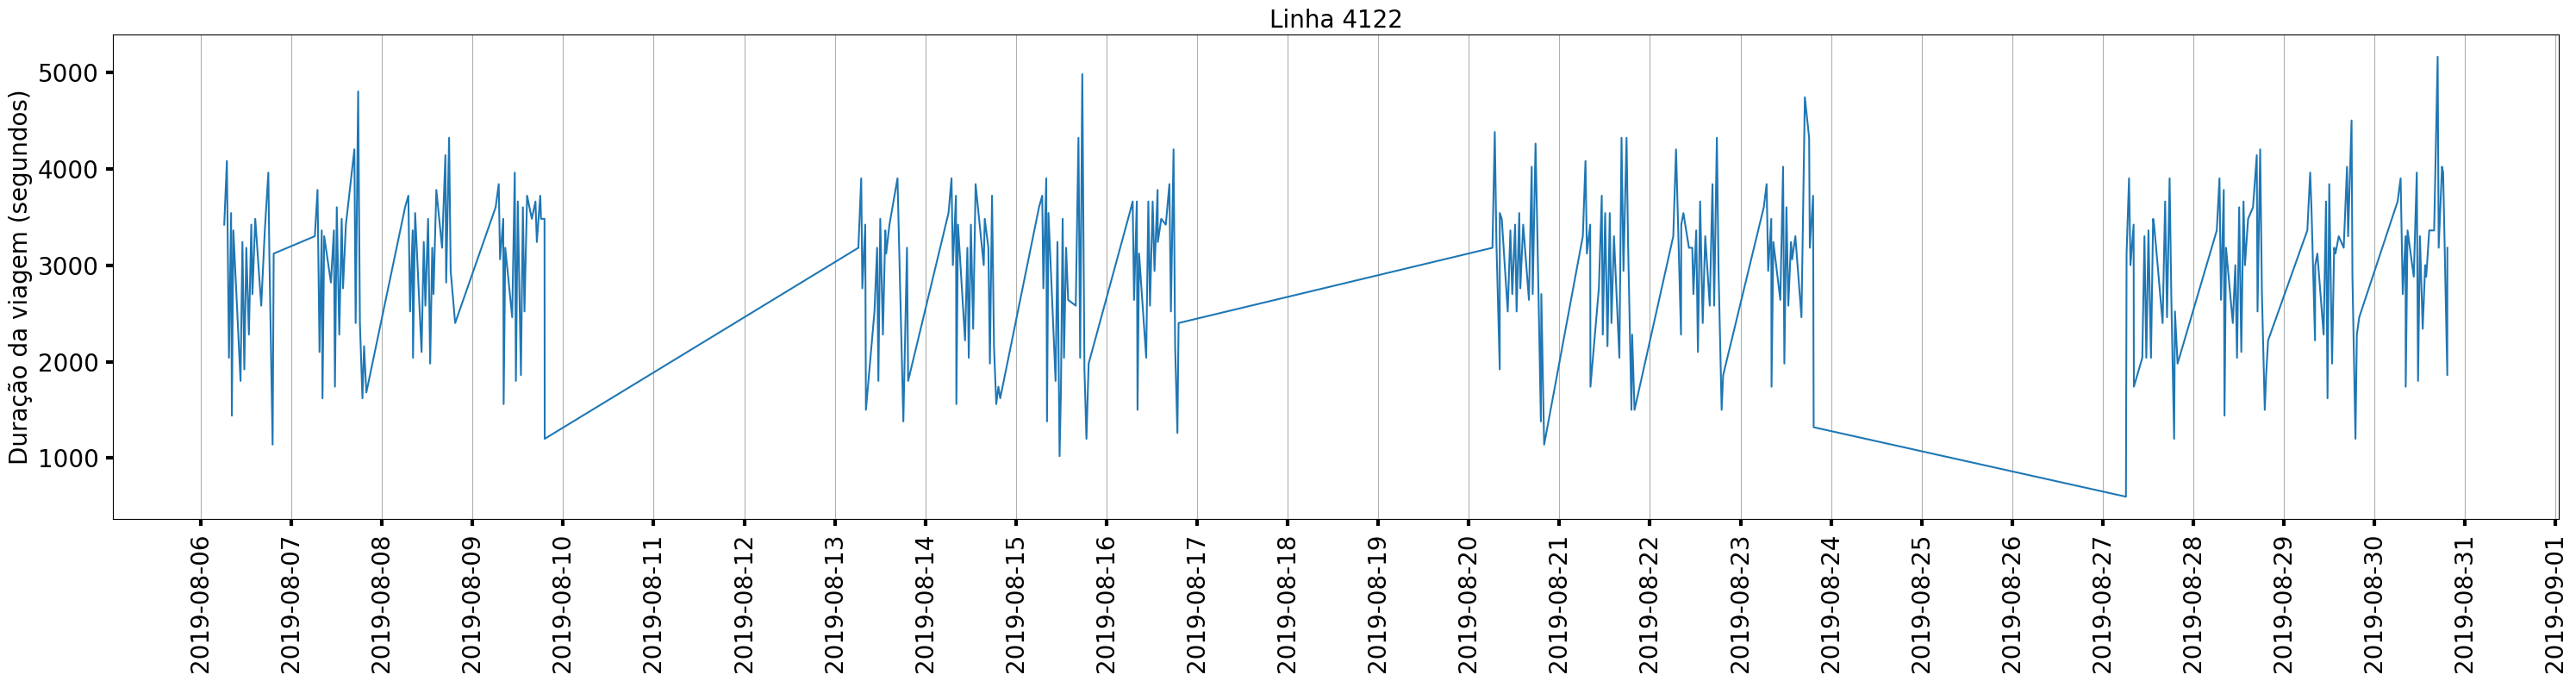

In [39]:
rota = "4122"

a = df.groupby('Linha')['DuraçãoViagem'].std().reset_index().sort_values(by='DuraçãoViagem').reset_index(drop=True)
print(a)
df_plot = df.loc[df['Linha'] == rota][['Ini','DuraçãoViagem']].sort_values(by='Ini')
df_plot = df_plot[(df_plot["Ini"] > "2019-08-04") & (df_plot["Ini"] < "2019-08-31")]
df_plot.set_index('Ini', inplace=True)


plt.figure(figsize=(30, 8))
plt.plot(df_plot.index, df_plot['DuraçãoViagem'])
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.ylabel('Duração da viagem (segundos)', fontsize=20)
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=20)
plt.tick_params(axis='both', which='both', width=3, length=6, pad=6)
plt.grid(axis="x")
plt.title(f'Linha {rota}', fontsize=20)
plt.tight_layout()
plt.savefig(f"Images/rota_{rota}.svg")
# plt.show()


In [40]:
b = pd.DataFrame(predictions, columns=['Teste','Data','Rota','Modelo','Valor'])
b

Teste                Data  \
0      0 Teste de Colunas - ['Sentido','KmPerc','dia_... 2019-10-31 19:44:00   
1      0 Teste de Colunas - ['Sentido','KmPerc','dia_... 2019-10-31 19:44:00   
2      0 Teste de Colunas - ['Sentido','KmPerc','dia_... 2019-10-31 19:44:00   
3      0 Teste de Colunas - ['Sentido','KmPerc','dia_... 2019-10-31 19:44:00   
4      0 Teste de Colunas - ['Sentido','KmPerc','dia_... 2019-10-31 18:26:00   
...                                                  ...                 ...   
46455  0 Teste de Colunas - ['Sentido','KmPerc','dia_... 2019-07-18 17:02:00   
46456  0 Teste de Colunas - ['Sentido','KmPerc','dia_... 2019-07-18 16:08:00   
46457  0 Teste de Colunas - ['Sentido','KmPerc','dia_... 2019-07-18 16:08:00   
46458  0 Teste de Colunas - ['Sentido','KmPerc','dia_... 2019-07-18 16:08:00   
46459  0 Teste de Colunas - ['Sentido','KmPerc','dia_... 2019-07-18 16:08:00   

       Rota             Modelo        Valor  
0      1120            XGBoost  4184.473145  
1      1120      Random Forest  4074.600000  
2      1120  Linear Regression  4011.229328  
3      1120         Tempo real  3600.000000  
4      1120            XGBoost  4471.656250  
...     ...                ...          ...  
46455   605         Tempo real  2880.000000  
46456   605            XGBoost  3677.500244  
46457   605      Random Forest  3516.030000  
46458   605  Linear Regression  3311.376363  
46459   605         Tempo real  3960.000000  

[46460 rows x 5 columns]

In [41]:
df_plot

DuraçãoViagem
Ini                               
2019-08-06 06:13:00           3420
2019-08-06 06:55:00           4080
2019-08-06 07:28:00           2040
2019-08-06 08:02:00           3540
2019-08-06 08:14:00           1440
...                            ...
2019-08-30 17:00:00           3180
2019-08-30 17:53:00           4020
2019-08-30 18:11:00           3960
2019-08-30 19:17:00           1860
2019-08-30 19:18:00           3180

[335 rows x 1 columns]

In [42]:
df.corr()

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


Sentido  DuraçãoViagem  TotalGiros    KmPerc  dia_semana  \
Sentido         1.000000      -0.038344   -0.130788 -0.078349   -0.004656   
DuraçãoViagem  -0.038344       1.000000    0.378288  0.859106   -0.004924   
TotalGiros     -0.130788       0.378288    1.000000  0.328887   -0.055781   
KmPerc         -0.078349       0.859106    0.328887  1.000000    0.020420   
dia_semana     -0.004656      -0.004924   -0.055781  0.020420    1.000000   
hora_dia        0.071973      -0.104892    0.061999 -0.072912   -0.015228   
dia_ano        -0.000195      -0.043986   -0.012069 -0.037748   -0.006944   
mes_ano        -0.000030      -0.044402   -0.011626 -0.038264   -0.006878   
turno_dia       0.066639      -0.140044   -0.046107 -0.078560   -0.007397   
TotalGirosMean  0.012892       0.391133    0.554278  0.450928    0.010385   

                hora_dia   dia_ano   mes_ano  turno_dia  TotalGirosMean  
Sentido         0.071973 -0.000195 -0.000030   0.066639        0.012892  
DuraçãoViagem  -0.104892 -0.043986 -0.044402  -0.140044        0.391133  
TotalGiros      0.061999 -0.012069 -0.011626  -0.046107        0.554278  
KmPerc         -0.072912 -0.037748 -0.038264  -0.078560        0.450928  
dia_semana     -0.015228 -0.006944 -0.006878  -0.007397        0.010385  
hora_dia        1.000000  0.002601  0.002476   0.727504        0.079882  
dia_ano         0.002601  1.000000  0.996500   0.003367       -0.020454  
mes_ano         0.002476  0.996500  1.000000   0.003486       -0.019513  
turno_dia       0.727504  0.003367  0.003486   1.000000       -0.057598  
TotalGirosMean  0.079882 -0.020454 -0.019513  -0.057598        1.000000

# Permuta

In [43]:
Colunas = [
        ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano'],
        ['Sentido','dia_semana','hora_dia','dia_ano'],
        ['TotalGirosMean','dia_semana','hora_dia','dia_ano'],
        ['dia_semana','hora_dia','dia_ano']
]
TestesNome = [
        "1 Teste de Colunas - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano']",
        "1 Teste de Colunas - ['Sentido','dia_semana','hora_dia','dia_ano']",
        "1 Teste de Colunas - ['TotalGirosMean','dia_semana','hora_dia','dia_ano']",
        "1 Teste de Colunas - ['dia_semana','hora_dia','dia_ano']"
]


# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    shape = int(df_modelo.shape[0] * 0.3)
    df_teste = df_modelo[:shape]
    df_treino = df_modelo[shape:]

    for i in range(len(TestesNome)):
        teste_nome = TestesNome[i]
        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[Colunas[i]]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[Colunas[i]]
        y_treino = df_treino["DuraçãoViagem"]

        fi_xgb, fi_rf = cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)
        fi_xgb["rota"], fi_rf["rota"] = rota, rota
        fi_xgb["modelo"], fi_rf["modelo"] = "XGB", "RF"

        importance = pd.concat([importance, fi_xgb, fi_rf])

[0]	validation_0-rmse:2761.67779
[1]	validation_0-rmse:1958.67208
[2]	validation_0-rmse:1403.68083
[3]	validation_0-rmse:1024.18370
[4]	validation_0-rmse:768.71614
[5]	validation_0-rmse:601.40748
[6]	validation_0-rmse:496.68425
[7]	validation_0-rmse:432.87627
[8]	validation_0-rmse:394.61285
[9]	validation_0-rmse:370.44435
[10]	validation_0-rmse:357.12341
[11]	validation_0-rmse:347.86716
[12]	validation_0-rmse:342.78816
[13]	validation_0-rmse:339.77326
[14]	validation_0-rmse:336.65660
[15]	validation_0-rmse:334.14750
[16]	validation_0-rmse:331.30526
[17]	validation_0-rmse:329.13079
[18]	validation_0-rmse:323.01812
[19]	validation_0-rmse:320.56431
[20]	validation_0-rmse:319.20777
[21]	validation_0-rmse:317.28602
[22]	validation_0-rmse:315.55828
[23]	validation_0-rmse:312.62790
[24]	validation_0-rmse:311.91820
[25]	validation_0-rmse:310.79285
[26]	validation_0-rmse:306.81700
[27]	validation_0-rmse:303.73995
[28]	validation_0-rmse:302.14782
[29]	validation_0-rmse:300.27992
[30]	validation_

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2761.67779
[1]	validation_0-rmse:1958.67208
[2]	validation_0-rmse:1403.70822
[3]	validation_0-rmse:1024.25842
[4]	validation_0-rmse:769.27525
[5]	validation_0-rmse:601.62521
[6]	validation_0-rmse:495.74784
[7]	validation_0-rmse:431.10795
[8]	validation_0-rmse:393.28974
[9]	validation_0-rmse:368.93159
[10]	validation_0-rmse:355.94972
[11]	validation_0-rmse:348.26118
[12]	validation_0-rmse:340.75395
[13]	validation_0-rmse:336.83992
[14]	validation_0-rmse:331.77629
[15]	validation_0-rmse:329.56415
[16]	validation_0-rmse:324.70476
[17]	validation_0-rmse:320.66385
[18]	validation_0-rmse:318.85474
[19]	validation_0-rmse:315.97978
[20]	validation_0-rmse:313.64703
[21]	validation_0-rmse:311.57236
[22]	validation_0-rmse:310.12285
[23]	validation_0-rmse:307.25160
[24]	validation_0-rmse:305.74644
[25]	validation_0-rmse:304.62724
[26]	validation_0-rmse:302.78519
[27]	validation_0-rmse:300.15243
[28]	validation_0-rmse:297.91988
[29]	validation_0-rmse:295.91563
[30]	validation_

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[7]	validation_0-rmse:489.83772
[8]	validation_0-rmse:457.32275
[9]	validation_0-rmse:439.15274
[10]	validation_0-rmse:426.94171
[11]	validation_0-rmse:420.58301
[12]	validation_0-rmse:416.09126
[13]	validation_0-rmse:411.70555
[14]	validation_0-rmse:407.93010
[15]	validation_0-rmse:406.50272
[16]	validation_0-rmse:404.50448
[17]	validation_0-rmse:402.49981
[18]	validation_0-rmse:401.04070
[19]	validation_0-rmse:399.18226
[20]	validation_0-rmse:398.65726
[21]	validation_0-rmse:396.39256
[22]	validation_0-rmse:395.15294
[23]	validation_0-rmse:393.81133
[24]	validation_0-rmse:392.86418
[25]	validation_0-rmse:390.48672
[26]	validation_0-rmse:389.35260
[27]	validation_0-rmse:388.44079
[28]	validation_0-rmse:388.20665
[29]	validation_0-rmse:386.56746
[30]	validation_0-rmse:384.79779
[31]	validation_0-rmse:383.46330
[32]	validation_0-rmse:382.13986
[33]	validation_0-rmse:380.79793
[34]	validation_0-rmse:379.40677
[35]	validation_0-rmse:378.79972
[36]	validation_0-rmse:377.61001
[37]	validati

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2765.35389
[1]	validation_0-rmse:1967.62953
[2]	validation_0-rmse:1420.07491
[3]	validation_0-rmse:1046.59038
[4]	validation_0-rmse:801.32759
[5]	validation_0-rmse:645.18656
[6]	validation_0-rmse:547.94268
[7]	validation_0-rmse:491.35011
[8]	validation_0-rmse:460.11258
[9]	validation_0-rmse:441.06926
[10]	validation_0-rmse:430.48681
[11]	validation_0-rmse:423.55475
[12]	validation_0-rmse:419.10157
[13]	validation_0-rmse:417.40549
[14]	validation_0-rmse:414.30434
[15]	validation_0-rmse:411.68147
[16]	validation_0-rmse:408.52617
[17]	validation_0-rmse:405.80027
[18]	validation_0-rmse:404.89515
[19]	validation_0-rmse:402.31800
[20]	validation_0-rmse:401.32609
[21]	validation_0-rmse:399.92857
[22]	validation_0-rmse:399.16675
[23]	validation_0-rmse:397.50690
[24]	validation_0-rmse:396.82299
[25]	validation_0-rmse:395.40515
[26]	validation_0-rmse:394.56919
[27]	validation_0-rmse:393.18978
[28]	validation_0-rmse:390.52023
[29]	validation_0-rmse:389.13833
[30]	validation_

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1940.62331
[1]	validation_0-rmse:1387.92089
[2]	validation_0-rmse:1007.22562
[3]	validation_0-rmse:748.85870
[4]	validation_0-rmse:574.14905
[5]	validation_0-rmse:462.33104
[6]	validation_0-rmse:393.35703
[7]	validation_0-rmse:353.16455
[8]	validation_0-rmse:327.90987
[9]	validation_0-rmse:311.49236
[10]	validation_0-rmse:300.47711
[11]	validation_0-rmse:295.09310
[12]	validation_0-rmse:289.83082
[13]	validation_0-rmse:285.71574
[14]	validation_0-rmse:281.68704
[15]	validation_0-rmse:279.32180
[16]	validation_0-rmse:276.46162
[17]	validation_0-rmse:274.60451
[18]	validation_0-rmse:272.54790
[19]	validation_0-rmse:270.96056
[20]	validation_0-rmse:269.04897
[21]	validation_0-rmse:266.25871
[22]	validation_0-rmse:265.05888
[23]	validation_0-rmse:263.83921
[24]	validation_0-rmse:263.03021
[25]	validation_0-rmse:261.66532
[26]	validation_0-rmse:259.85632
[27]	validation_0-rmse:258.64231
[28]	validation_0-rmse:257.56088
[29]	validation_0-rmse:256.98769
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1940.55651
[1]	validation_0-rmse:1386.59793
[2]	validation_0-rmse:1006.76111
[3]	validation_0-rmse:750.32720
[4]	validation_0-rmse:579.66985
[5]	validation_0-rmse:473.09113
[6]	validation_0-rmse:403.68452
[7]	validation_0-rmse:363.20617
[8]	validation_0-rmse:338.34727
[9]	validation_0-rmse:321.77823
[10]	validation_0-rmse:312.33654
[11]	validation_0-rmse:305.89420
[12]	validation_0-rmse:300.28425
[13]	validation_0-rmse:296.59024
[14]	validation_0-rmse:293.66058
[15]	validation_0-rmse:291.37031
[16]	validation_0-rmse:288.28671
[17]	validation_0-rmse:287.24047
[18]	validation_0-rmse:285.59877
[19]	validation_0-rmse:282.80931
[20]	validation_0-rmse:282.07023
[21]	validation_0-rmse:278.33268
[22]	validation_0-rmse:275.45560
[23]	validation_0-rmse:272.23720
[24]	validation_0-rmse:270.90730
[25]	validation_0-rmse:270.31656
[26]	validation_0-rmse:269.81228
[27]	validation_0-rmse:268.26540
[28]	validation_0-rmse:266.10246
[29]	validation_0-rmse:264.82648
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1989.85359
[1]	validation_0-rmse:1488.24339
[2]	validation_0-rmse:1163.88906
[3]	validation_0-rmse:963.41479
[4]	validation_0-rmse:845.82361
[5]	validation_0-rmse:780.34992
[6]	validation_0-rmse:744.47761
[7]	validation_0-rmse:724.11228
[8]	validation_0-rmse:713.05771
[9]	validation_0-rmse:705.91330
[10]	validation_0-rmse:702.34303
[11]	validation_0-rmse:700.19109
[12]	validation_0-rmse:698.18395
[13]	validation_0-rmse:697.13111
[14]	validation_0-rmse:695.65354
[15]	validation_0-rmse:694.42094
[16]	validation_0-rmse:693.68565
[17]	validation_0-rmse:692.79872
[18]	validation_0-rmse:692.52827
[19]	validation_0-rmse:691.99902
[20]	validation_0-rmse:691.57399
[21]	validation_0-rmse:691.20474
[22]	validation_0-rmse:690.86079
[23]	validation_0-rmse:690.57233
[24]	validation_0-rmse:690.18522
[25]	validation_0-rmse:689.75919
[26]	validation_0-rmse:688.87229
[27]	validation_0-rmse:688.50388
[28]	validation_0-rmse:688.31300
[29]	validation_0-rmse:688.17790
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1989.40297
[1]	validation_0-rmse:1487.84254
[2]	validation_0-rmse:1163.79515
[3]	validation_0-rmse:963.22230
[4]	validation_0-rmse:846.23172
[5]	validation_0-rmse:779.65430
[6]	validation_0-rmse:743.81047
[7]	validation_0-rmse:725.06489
[8]	validation_0-rmse:714.27222
[9]	validation_0-rmse:708.19343
[10]	validation_0-rmse:704.38229
[11]	validation_0-rmse:702.28078
[12]	validation_0-rmse:699.32789
[13]	validation_0-rmse:697.95665
[14]	validation_0-rmse:697.29901
[15]	validation_0-rmse:696.24558
[16]	validation_0-rmse:695.66714
[17]	validation_0-rmse:695.13479
[18]	validation_0-rmse:694.55942
[19]	validation_0-rmse:694.21864
[20]	validation_0-rmse:693.51041
[21]	validation_0-rmse:692.96513
[22]	validation_0-rmse:692.50374
[23]	validation_0-rmse:691.99631
[24]	validation_0-rmse:691.92355
[25]	validation_0-rmse:691.57954
[26]	validation_0-rmse:691.12779
[27]	validation_0-rmse:690.52662
[28]	validation_0-rmse:690.30718
[29]	validation_0-rmse:690.00033
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[6]	validation_0-rmse:201.69334
[7]	validation_0-rmse:182.51564
[8]	validation_0-rmse:172.02823
[9]	validation_0-rmse:166.16801
[10]	validation_0-rmse:162.40734
[11]	validation_0-rmse:159.53501
[12]	validation_0-rmse:156.98306
[13]	validation_0-rmse:155.81482
[14]	validation_0-rmse:155.24720
[15]	validation_0-rmse:154.82973
[16]	validation_0-rmse:153.41932
[17]	validation_0-rmse:152.18165
[18]	validation_0-rmse:151.68424
[19]	validation_0-rmse:150.75104
[20]	validation_0-rmse:149.33459
[21]	validation_0-rmse:149.06063
[22]	validation_0-rmse:148.05673
[23]	validation_0-rmse:147.59353
[24]	validation_0-rmse:147.12460
[25]	validation_0-rmse:146.06885
[26]	validation_0-rmse:145.88036
[27]	validation_0-rmse:145.33102
[28]	validation_0-rmse:144.44346
[29]	validation_0-rmse:144.33721
[30]	validation_0-rmse:143.90877
[31]	validation_0-rmse:143.32211
[32]	validation_0-rmse:142.33479
[33]	validation_0-rmse:141.59280
[34]	validation_0-rmse:141.00491
[35]	validation_0-rmse:140.41122
[36]	validatio

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1014.32796
[1]	validation_0-rmse:721.16421
[2]	validation_0-rmse:519.28682
[3]	validation_0-rmse:382.41437
[4]	validation_0-rmse:291.55778
[5]	validation_0-rmse:233.80337
[6]	validation_0-rmse:199.33397
[7]	validation_0-rmse:178.61533
[8]	validation_0-rmse:167.88672
[9]	validation_0-rmse:161.28809
[10]	validation_0-rmse:157.82883
[11]	validation_0-rmse:155.88967
[12]	validation_0-rmse:154.78114
[13]	validation_0-rmse:154.11768
[14]	validation_0-rmse:152.76028
[15]	validation_0-rmse:152.35427
[16]	validation_0-rmse:151.92464
[17]	validation_0-rmse:150.43409
[18]	validation_0-rmse:149.67140
[19]	validation_0-rmse:149.46836
[20]	validation_0-rmse:148.51480
[21]	validation_0-rmse:148.11635
[22]	validation_0-rmse:147.50787
[23]	validation_0-rmse:146.12927
[24]	validation_0-rmse:145.67500
[25]	validation_0-rmse:144.90317
[26]	validation_0-rmse:144.32824
[27]	validation_0-rmse:143.46554
[28]	validation_0-rmse:142.79620
[29]	validation_0-rmse:142.35678
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1015.52213
[1]	validation_0-rmse:723.69595
[2]	validation_0-rmse:523.99652
[3]	validation_0-rmse:389.91880
[4]	validation_0-rmse:302.56013
[5]	validation_0-rmse:248.02547
[6]	validation_0-rmse:215.03565
[7]	validation_0-rmse:196.60533
[8]	validation_0-rmse:186.98859
[9]	validation_0-rmse:181.20154
[10]	validation_0-rmse:178.39108
[11]	validation_0-rmse:175.77540
[12]	validation_0-rmse:174.42738
[13]	validation_0-rmse:173.55140
[14]	validation_0-rmse:172.89770
[15]	validation_0-rmse:172.31379
[16]	validation_0-rmse:172.00711
[17]	validation_0-rmse:171.37668
[18]	validation_0-rmse:170.85147
[19]	validation_0-rmse:170.72030
[20]	validation_0-rmse:170.19850
[21]	validation_0-rmse:169.59694
[22]	validation_0-rmse:168.94915
[23]	validation_0-rmse:168.84800
[24]	validation_0-rmse:168.45009
[25]	validation_0-rmse:168.32315
[26]	validation_0-rmse:167.80210
[27]	validation_0-rmse:167.62681
[28]	validation_0-rmse:167.34214
[29]	validation_0-rmse:167.04988
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1015.50283
[1]	validation_0-rmse:723.55308
[2]	validation_0-rmse:523.48205
[3]	validation_0-rmse:389.04094
[4]	validation_0-rmse:301.37043
[5]	validation_0-rmse:246.75793
[6]	validation_0-rmse:214.68727
[7]	validation_0-rmse:197.05245
[8]	validation_0-rmse:187.05245
[9]	validation_0-rmse:181.61492
[10]	validation_0-rmse:178.56048
[11]	validation_0-rmse:176.10488
[12]	validation_0-rmse:175.26623
[13]	validation_0-rmse:174.32670
[14]	validation_0-rmse:173.65759
[15]	validation_0-rmse:172.90858
[16]	validation_0-rmse:172.03663
[17]	validation_0-rmse:171.56820
[18]	validation_0-rmse:171.35962
[19]	validation_0-rmse:170.63070
[20]	validation_0-rmse:170.27794
[21]	validation_0-rmse:169.69107
[22]	validation_0-rmse:169.46605
[23]	validation_0-rmse:168.88606
[24]	validation_0-rmse:168.79116
[25]	validation_0-rmse:168.62989
[26]	validation_0-rmse:168.31456
[27]	validation_0-rmse:168.04886
[28]	validation_0-rmse:167.60865
[29]	validation_0-rmse:166.99935
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:603.73921
[1]	validation_0-rmse:437.18497
[2]	validation_0-rmse:324.56813
[3]	validation_0-rmse:250.55170
[4]	validation_0-rmse:204.05507
[5]	validation_0-rmse:175.79365
[6]	validation_0-rmse:159.27288
[7]	validation_0-rmse:150.01033
[8]	validation_0-rmse:144.55710
[9]	validation_0-rmse:141.47444
[10]	validation_0-rmse:138.69459
[11]	validation_0-rmse:136.18277
[12]	validation_0-rmse:135.43487
[13]	validation_0-rmse:135.00958
[14]	validation_0-rmse:134.21333
[15]	validation_0-rmse:133.11017
[16]	validation_0-rmse:131.95821
[17]	validation_0-rmse:131.64292
[18]	validation_0-rmse:131.37758
[19]	validation_0-rmse:130.90655
[20]	validation_0-rmse:130.16379
[21]	validation_0-rmse:129.20634
[22]	validation_0-rmse:128.52396
[23]	validation_0-rmse:128.25757
[24]	validation_0-rmse:127.44741
[25]	validation_0-rmse:126.95012
[26]	validation_0-rmse:126.43814
[27]	validation_0-rmse:125.70047
[28]	validation_0-rmse:125.47579
[29]	validation_0-rmse:124.92169
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:603.74450
[1]	validation_0-rmse:437.19848
[2]	validation_0-rmse:324.83050
[3]	validation_0-rmse:250.75008
[4]	validation_0-rmse:204.39606
[5]	validation_0-rmse:176.22571
[6]	validation_0-rmse:159.71031
[7]	validation_0-rmse:150.81722
[8]	validation_0-rmse:145.73327
[9]	validation_0-rmse:142.57521
[10]	validation_0-rmse:140.77934
[11]	validation_0-rmse:139.52371
[12]	validation_0-rmse:137.91941
[13]	validation_0-rmse:136.10696
[14]	validation_0-rmse:135.32478
[15]	validation_0-rmse:134.62542
[16]	validation_0-rmse:133.49382
[17]	validation_0-rmse:132.43161
[18]	validation_0-rmse:132.10315
[19]	validation_0-rmse:131.33572
[20]	validation_0-rmse:130.94089
[21]	validation_0-rmse:130.19724
[22]	validation_0-rmse:129.78588
[23]	validation_0-rmse:129.50608
[24]	validation_0-rmse:128.66098
[25]	validation_0-rmse:128.18759
[26]	validation_0-rmse:127.51231
[27]	validation_0-rmse:126.92444
[28]	validation_0-rmse:126.13194
[29]	validation_0-rmse:125.48209
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:604.76555
[1]	validation_0-rmse:439.61598
[2]	validation_0-rmse:328.55715
[3]	validation_0-rmse:256.27353
[4]	validation_0-rmse:211.69078
[5]	validation_0-rmse:185.01225
[6]	validation_0-rmse:169.64581
[7]	validation_0-rmse:161.49474
[8]	validation_0-rmse:156.77122
[9]	validation_0-rmse:154.38972
[10]	validation_0-rmse:152.54070
[11]	validation_0-rmse:151.45768
[12]	validation_0-rmse:150.91490
[13]	validation_0-rmse:150.15952
[14]	validation_0-rmse:148.82709
[15]	validation_0-rmse:148.22693
[16]	validation_0-rmse:147.33356
[17]	validation_0-rmse:146.72575
[18]	validation_0-rmse:146.15972
[19]	validation_0-rmse:145.67145
[20]	validation_0-rmse:145.12513
[21]	validation_0-rmse:144.45179
[22]	validation_0-rmse:143.93247
[23]	validation_0-rmse:143.81846
[24]	validation_0-rmse:143.25947
[25]	validation_0-rmse:142.96396
[26]	validation_0-rmse:142.67651
[27]	validation_0-rmse:142.54278
[28]	validation_0-rmse:142.29760
[29]	validation_0-rmse:141.91455
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:604.76555
[1]	validation_0-rmse:439.61598
[2]	validation_0-rmse:328.57887
[3]	validation_0-rmse:256.39670
[4]	validation_0-rmse:211.65758
[5]	validation_0-rmse:185.07485
[6]	validation_0-rmse:170.33395
[7]	validation_0-rmse:162.24786
[8]	validation_0-rmse:157.98436
[9]	validation_0-rmse:155.25555
[10]	validation_0-rmse:153.10657
[11]	validation_0-rmse:152.27058
[12]	validation_0-rmse:151.54962
[13]	validation_0-rmse:151.13481
[14]	validation_0-rmse:150.37270
[15]	validation_0-rmse:149.75556
[16]	validation_0-rmse:148.83733
[17]	validation_0-rmse:148.33425
[18]	validation_0-rmse:147.67228
[19]	validation_0-rmse:147.47659
[20]	validation_0-rmse:147.08548
[21]	validation_0-rmse:146.65939
[22]	validation_0-rmse:146.62627
[23]	validation_0-rmse:146.36401
[24]	validation_0-rmse:145.91713
[25]	validation_0-rmse:145.61588
[26]	validation_0-rmse:145.18612
[27]	validation_0-rmse:144.79877
[28]	validation_0-rmse:144.32055
[29]	validation_0-rmse:144.08088
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2259.62983
[1]	validation_0-rmse:1621.20862
[2]	validation_0-rmse:1183.72499
[3]	validation_0-rmse:888.87951
[4]	validation_0-rmse:695.56787
[5]	validation_0-rmse:570.77886
[6]	validation_0-rmse:496.75807
[7]	validation_0-rmse:450.73670
[8]	validation_0-rmse:425.68055
[9]	validation_0-rmse:407.03411
[10]	validation_0-rmse:398.12362
[11]	validation_0-rmse:389.65748
[12]	validation_0-rmse:385.42991
[13]	validation_0-rmse:381.35636
[14]	validation_0-rmse:376.21088
[15]	validation_0-rmse:372.62739
[16]	validation_0-rmse:369.29024
[17]	validation_0-rmse:363.55499
[18]	validation_0-rmse:360.84073
[19]	validation_0-rmse:360.13643
[20]	validation_0-rmse:357.42087
[21]	validation_0-rmse:353.83128
[22]	validation_0-rmse:352.84695
[23]	validation_0-rmse:350.25943
[24]	validation_0-rmse:346.22833
[25]	validation_0-rmse:345.75525
[26]	validation_0-rmse:342.05751
[27]	validation_0-rmse:339.23835
[28]	validation_0-rmse:335.75313
[29]	validation_0-rmse:333.27042
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[16]	validation_0-rmse:367.08151
[17]	validation_0-rmse:364.48331
[18]	validation_0-rmse:362.49771
[19]	validation_0-rmse:357.33110
[20]	validation_0-rmse:354.64414
[21]	validation_0-rmse:352.28166
[22]	validation_0-rmse:350.58560
[23]	validation_0-rmse:348.82448
[24]	validation_0-rmse:345.38112
[25]	validation_0-rmse:343.35663
[26]	validation_0-rmse:340.28342
[27]	validation_0-rmse:338.63999
[28]	validation_0-rmse:337.52521
[29]	validation_0-rmse:336.66328
[30]	validation_0-rmse:334.33073
[31]	validation_0-rmse:332.71794
[32]	validation_0-rmse:331.80878
[33]	validation_0-rmse:330.42366
[34]	validation_0-rmse:329.92659
[35]	validation_0-rmse:328.95495
[36]	validation_0-rmse:325.31458
[37]	validation_0-rmse:322.78098
[38]	validation_0-rmse:321.29582
[39]	validation_0-rmse:320.83367
[40]	validation_0-rmse:319.32517
[41]	validation_0-rmse:318.26660
[42]	validation_0-rmse:316.87997
[43]	validation_0-rmse:315.51936
[44]	validation_0-rmse:314.68247
[45]	validation_0-rmse:312.42554
[46]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[10]	validation_0-rmse:704.13139
[11]	validation_0-rmse:700.19562
[12]	validation_0-rmse:695.64931
[13]	validation_0-rmse:694.45956
[14]	validation_0-rmse:693.26429
[15]	validation_0-rmse:690.48815
[16]	validation_0-rmse:689.29339
[17]	validation_0-rmse:688.11573
[18]	validation_0-rmse:685.79261
[19]	validation_0-rmse:684.97820
[20]	validation_0-rmse:683.44088
[21]	validation_0-rmse:680.90066
[22]	validation_0-rmse:679.42522
[23]	validation_0-rmse:677.46239
[24]	validation_0-rmse:675.63321
[25]	validation_0-rmse:674.10429
[26]	validation_0-rmse:672.90781
[27]	validation_0-rmse:671.45569
[28]	validation_0-rmse:670.35453
[29]	validation_0-rmse:668.73456
[30]	validation_0-rmse:666.91192
[31]	validation_0-rmse:665.72564
[32]	validation_0-rmse:665.06684
[33]	validation_0-rmse:664.72217
[34]	validation_0-rmse:664.44447
[35]	validation_0-rmse:663.58643
[36]	validation_0-rmse:663.32157
[37]	validation_0-rmse:661.90726
[38]	validation_0-rmse:660.69349
[39]	validation_0-rmse:659.98840
[40]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[12]	validation_0-rmse:697.59970
[13]	validation_0-rmse:695.51400
[14]	validation_0-rmse:693.13215
[15]	validation_0-rmse:692.12191
[16]	validation_0-rmse:690.75790
[17]	validation_0-rmse:688.32476
[18]	validation_0-rmse:686.54652
[19]	validation_0-rmse:685.97597
[20]	validation_0-rmse:684.70437
[21]	validation_0-rmse:683.65160
[22]	validation_0-rmse:682.42529
[23]	validation_0-rmse:681.03213
[24]	validation_0-rmse:680.12471
[25]	validation_0-rmse:679.00185
[26]	validation_0-rmse:677.39437
[27]	validation_0-rmse:676.36320
[28]	validation_0-rmse:675.52379
[29]	validation_0-rmse:674.27051
[30]	validation_0-rmse:673.24457
[31]	validation_0-rmse:672.10753
[32]	validation_0-rmse:671.32599
[33]	validation_0-rmse:670.37081
[34]	validation_0-rmse:669.66637
[35]	validation_0-rmse:669.08701
[36]	validation_0-rmse:668.44141
[37]	validation_0-rmse:667.87589
[38]	validation_0-rmse:667.61504
[39]	validation_0-rmse:667.25407
[40]	validation_0-rmse:666.53189
[41]	validation_0-rmse:665.74844
[42]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[12]	validation_0-rmse:291.29342
[13]	validation_0-rmse:289.20639
[14]	validation_0-rmse:288.11829
[15]	validation_0-rmse:287.17685
[16]	validation_0-rmse:282.05776
[17]	validation_0-rmse:276.67583
[18]	validation_0-rmse:274.20855
[19]	validation_0-rmse:270.60730
[20]	validation_0-rmse:268.34374
[21]	validation_0-rmse:265.90007
[22]	validation_0-rmse:265.01493
[23]	validation_0-rmse:264.71525
[24]	validation_0-rmse:261.66999
[25]	validation_0-rmse:261.12028
[26]	validation_0-rmse:257.62880
[27]	validation_0-rmse:256.85554
[28]	validation_0-rmse:254.49427
[29]	validation_0-rmse:254.25428
[30]	validation_0-rmse:253.58614
[31]	validation_0-rmse:251.81177
[32]	validation_0-rmse:250.13980
[33]	validation_0-rmse:249.04613
[34]	validation_0-rmse:246.65784
[35]	validation_0-rmse:244.51258
[36]	validation_0-rmse:241.28958
[37]	validation_0-rmse:239.82810
[38]	validation_0-rmse:237.97511
[39]	validation_0-rmse:236.75798
[40]	validation_0-rmse:236.12926
[41]	validation_0-rmse:235.41544
[42]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[43]	validation_0-rmse:237.84461
[44]	validation_0-rmse:236.83209
[45]	validation_0-rmse:236.76148
[46]	validation_0-rmse:235.52127
[47]	validation_0-rmse:234.64647
[48]	validation_0-rmse:233.80967
[49]	validation_0-rmse:231.92447
[50]	validation_0-rmse:231.34918
[51]	validation_0-rmse:230.85176
[52]	validation_0-rmse:228.93047
[53]	validation_0-rmse:227.96178
[54]	validation_0-rmse:226.93346
[55]	validation_0-rmse:225.77577
[56]	validation_0-rmse:225.56668
[57]	validation_0-rmse:224.98233
[58]	validation_0-rmse:224.12097
[59]	validation_0-rmse:223.25371
[60]	validation_0-rmse:222.08993
[61]	validation_0-rmse:221.23971
[62]	validation_0-rmse:220.56529
[63]	validation_0-rmse:220.06235
[64]	validation_0-rmse:219.45593
[65]	validation_0-rmse:219.13351
[66]	validation_0-rmse:218.56080
[67]	validation_0-rmse:217.89280
[68]	validation_0-rmse:217.63342
[69]	validation_0-rmse:217.30615
[70]	validation_0-rmse:216.92029
[71]	validation_0-rmse:216.50264
[72]	validation_0-rmse:215.89598
[73]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[38]	validation_0-rmse:237.97511
[39]	validation_0-rmse:236.75798
[40]	validation_0-rmse:236.12926
[41]	validation_0-rmse:235.41544
[42]	validation_0-rmse:232.13861
[43]	validation_0-rmse:231.37348
[44]	validation_0-rmse:230.50820
[45]	validation_0-rmse:229.35029
[46]	validation_0-rmse:228.36228
[47]	validation_0-rmse:226.87312
[48]	validation_0-rmse:226.57493
[49]	validation_0-rmse:226.18480
[50]	validation_0-rmse:224.12878
[51]	validation_0-rmse:223.28051
[52]	validation_0-rmse:221.94175
[53]	validation_0-rmse:221.33412
[54]	validation_0-rmse:220.01070
[55]	validation_0-rmse:219.04472
[56]	validation_0-rmse:217.95418
[57]	validation_0-rmse:216.80787
[58]	validation_0-rmse:215.72381
[59]	validation_0-rmse:214.98285
[60]	validation_0-rmse:214.40109
[61]	validation_0-rmse:213.14195
[62]	validation_0-rmse:212.23514
[63]	validation_0-rmse:211.66421
[64]	validation_0-rmse:211.36494
[65]	validation_0-rmse:210.61657
[66]	validation_0-rmse:210.30944
[67]	validation_0-rmse:209.73970
[68]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[46]	validation_0-rmse:235.52127
[47]	validation_0-rmse:234.64647
[48]	validation_0-rmse:233.80967
[49]	validation_0-rmse:231.92447
[50]	validation_0-rmse:231.34918
[51]	validation_0-rmse:230.85176
[52]	validation_0-rmse:228.93047
[53]	validation_0-rmse:227.96178
[54]	validation_0-rmse:226.93346
[55]	validation_0-rmse:225.77577
[56]	validation_0-rmse:225.56668
[57]	validation_0-rmse:224.98233
[58]	validation_0-rmse:224.12097
[59]	validation_0-rmse:223.25371
[60]	validation_0-rmse:222.08993
[61]	validation_0-rmse:221.23971
[62]	validation_0-rmse:220.56529
[63]	validation_0-rmse:220.06235
[64]	validation_0-rmse:219.45593
[65]	validation_0-rmse:219.13351
[66]	validation_0-rmse:218.56080
[67]	validation_0-rmse:217.89280
[68]	validation_0-rmse:217.63342
[69]	validation_0-rmse:217.30615
[70]	validation_0-rmse:216.92029
[71]	validation_0-rmse:216.50264
[72]	validation_0-rmse:215.89598
[73]	validation_0-rmse:215.22961
[74]	validation_0-rmse:214.80911
[75]	validation_0-rmse:214.35069
[76]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [44]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[a['Métrica'] == 'RMSE'].sort_values(by='Valor')

Teste Rota  \
118  1 Teste de Colunas - ['Sentido','dia_semana','...  362   
112  1 Teste de Colunas - ['Sentido','TotalGirosMea...  362   
22   0 Teste de Colunas - ['Sentido','KmPerc','dia_...  362   
108  1 Teste de Colunas - ['Sentido','TotalGirosMea...  362   
18   0 Teste de Colunas - ['Sentido','KmPerc','dia_...  362   
..                                                 ...  ...   
82   1 Teste de Colunas - ['dia_semana','hora_dia',...  235   
78   1 Teste de Colunas - ['dia_semana','hora_dia',...  235   
80   1 Teste de Colunas - ['dia_semana','hora_dia',...  235   
72   1 Teste de Colunas - ['TotalGirosMean','dia_se...  235   
74   1 Teste de Colunas - ['TotalGirosMean','dia_se...  235   

                Modelo Métrica       Valor  Tempo de treino  Tempo de previsão  
118  Linear Regression    RMSE  165.419098         0.158730            0.00000  
112  Linear Regression    RMSE  165.722145         0.000000            0.00000  
22   Linear Regression    RMSE  166.532178         0.233400            0.20000  
108            XGBoost    RMSE  173.961327         0.233361            0.00000  
18             XGBoost    RMSE  175.910101         0.201236            0.39690  
..                 ...     ...         ...              ...                ...  
82   Linear Regression    RMSE  861.481548         0.000000            0.00000  
78             XGBoost    RMSE  866.977726         0.148816            0.00000  
80       Random Forest    RMSE  924.675431         0.334386            0.16638  
72             XGBoost    RMSE  925.408234         0.161994            0.10360  
74       Random Forest    RMSE  928.428263         0.400950            0.16640  

[90 rows x 7 columns]

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\42824251.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b["Valor"] = b["Valor"] * 100
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\42824251.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b["Teste"] = b["Teste"].apply(extrair_valores)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\42824251.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

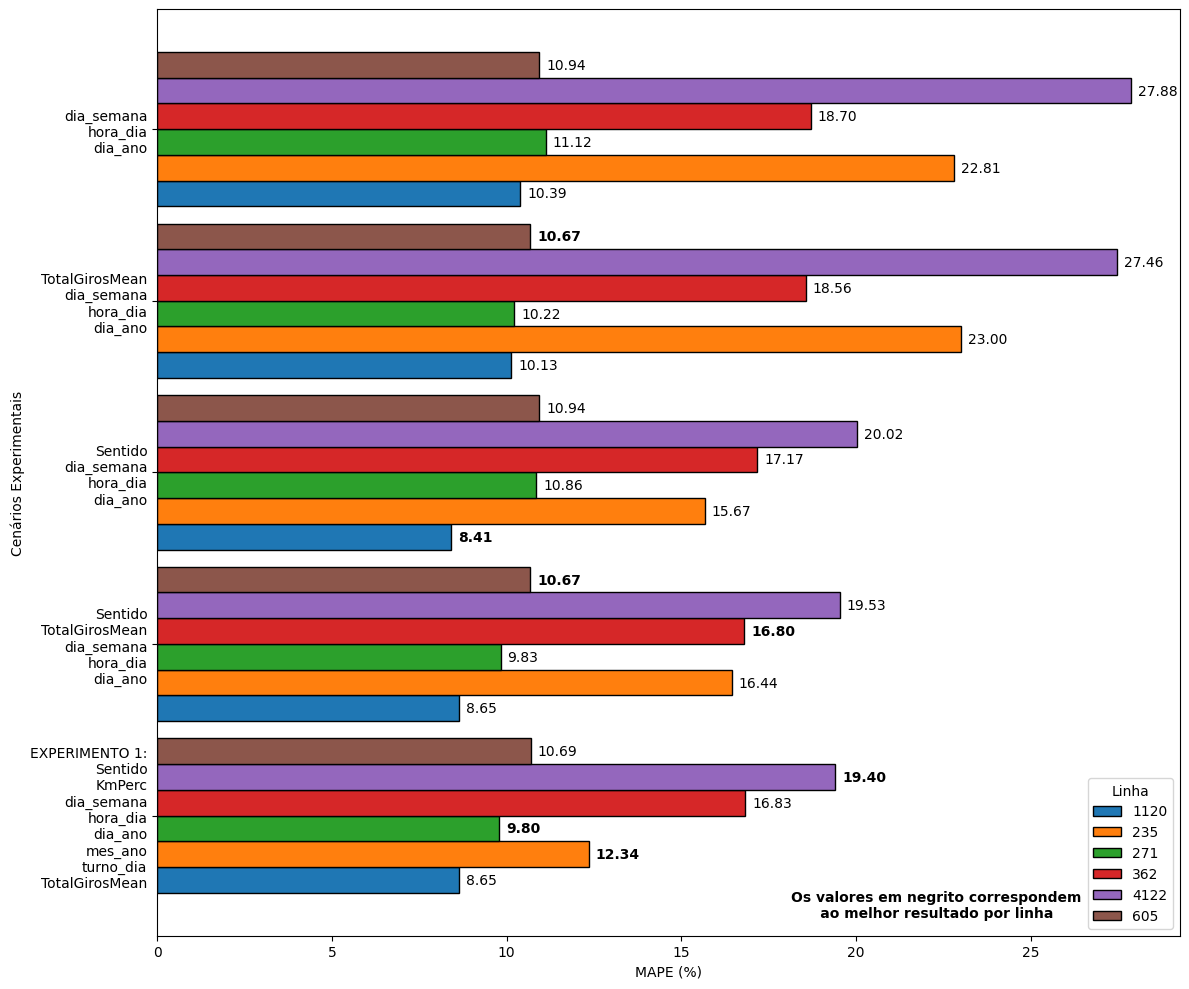

In [45]:
import re

def extrair_valores(text):
    match = re.search(r"\[([^]]+)\]", text)
    if match:
        return match.group(1)
    return ''

b = a[(a["Métrica"] == "MAPE") & (a["Modelo"] == "XGBoost") ]
b["Valor"] = b["Valor"] * 100
b["Teste"] = b["Teste"].apply(extrair_valores)
b["Teste"] = b["Teste"].str.replace(",", "\n").str.replace("'", "")
b["Teste"] = b["Teste"].replace({"Sentido\nKmPerc\ndia_semana\nhora_dia\ndia_ano\nmes_ano\nturno_dia\nTotalGirosMean": "EXPERIMENTO 1:\nSentido\nKmPerc\ndia_semana\nhora_dia\ndia_ano\nmes_ano\nturno_dia\nTotalGirosMean"})

df_pivot = b.pivot(index='Teste', columns='Rota', values='Valor').sort_index()
df

plt.rcParams["figure.autolayout"] = True

ax = df_pivot.plot(kind='barh', width = 0.9, figsize=[12, 10], edgecolor="black")

min_linha = b.groupby("Rota").agg({"Valor": "min"})["Valor"].unique()

for p in ax.patches:
    value = p.get_width()
    value_f = "{:.2f}".format(value)
    if value in min_linha:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontweight='bold')
    else:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.xlabel("MAPE (%)")
plt.ylabel("Cenários Experimentais")

ax.legend(title="Linha")
ax.text(0.62, 0.02, "Os valores em negrito correspondem\n      ao melhor resultado por linha", transform=ax.transAxes, fontsize=10, color="black", fontweight="bold")

plt.savefig("Results/resultados_permutacao_xgb.svg")
plt.savefig("Results/resultados_permutacao_xgb.png")


C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\2063313013.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b["Valor"] = b["Valor"] * 100
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\2063313013.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b["Teste"] = b["Teste"].apply(extrair_valores)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\2063313013.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

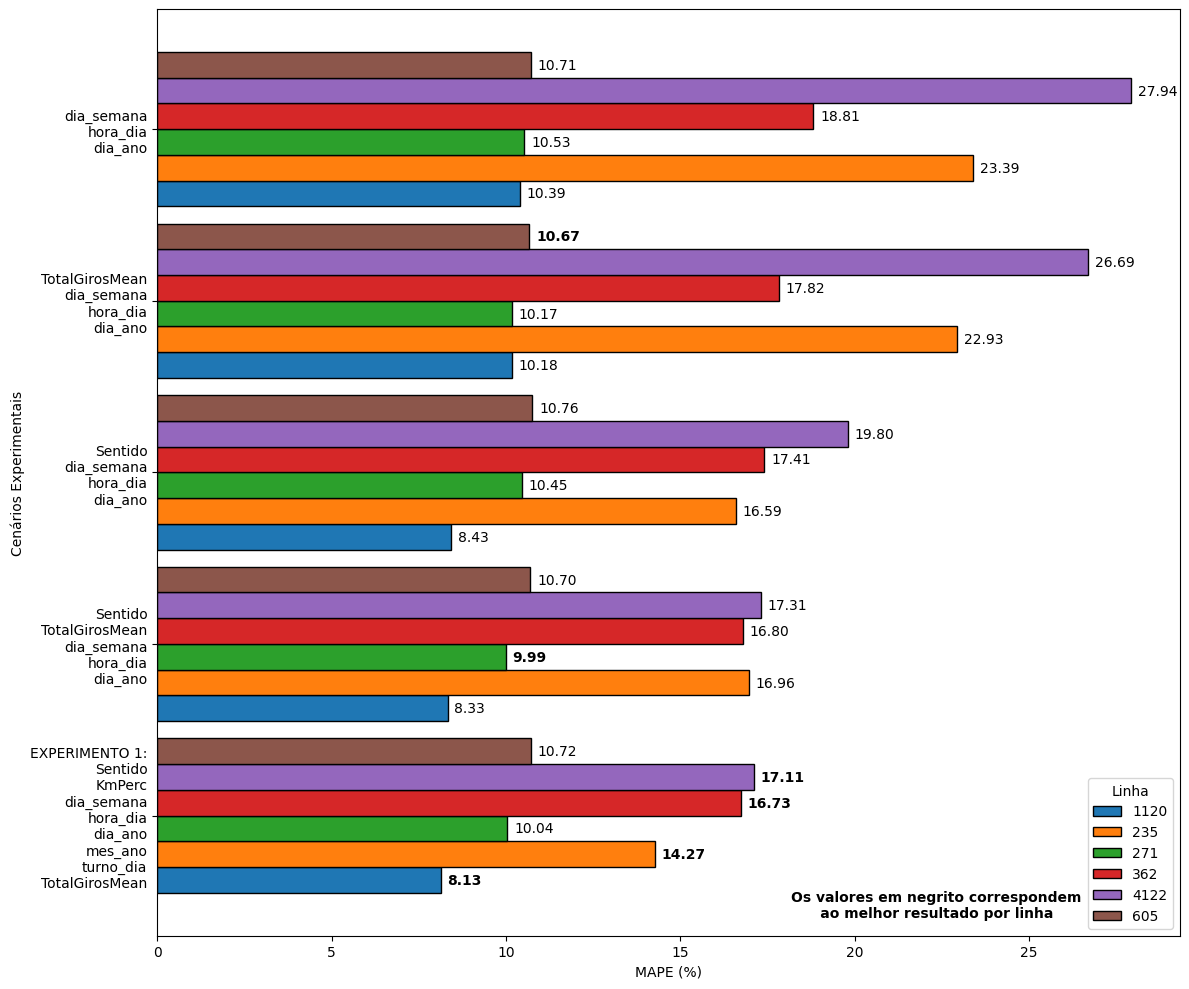

In [46]:
import re

def extrair_valores(text):
    match = re.search(r"\[([^]]+)\]", text)
    if match:
        return match.group(1)
    return ''

b = a[(a["Métrica"] == "MAPE") & (a["Modelo"] == "Random Forest") ]
b["Valor"] = b["Valor"] * 100
b["Teste"] = b["Teste"].apply(extrair_valores)
b["Teste"] = b["Teste"].str.replace(",", "\n").str.replace("'", "")
b["Teste"] = b["Teste"].replace({"Sentido\nKmPerc\ndia_semana\nhora_dia\ndia_ano\nmes_ano\nturno_dia\nTotalGirosMean": "EXPERIMENTO 1:\nSentido\nKmPerc\ndia_semana\nhora_dia\ndia_ano\nmes_ano\nturno_dia\nTotalGirosMean"})

df_pivot = b.pivot(index='Teste', columns='Rota', values='Valor')

plt.rcParams["figure.autolayout"] = True

ax = df_pivot.plot(kind='barh', width = 0.9, figsize=[12, 10], edgecolor="black")

min_linha = b.groupby("Rota").agg({"Valor": "min"})["Valor"].unique()

for p in ax.patches:
    value = p.get_width()
    value_f = "{:.2f}".format(value)
    if value in min_linha:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontweight='bold')
    else:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.xlabel("MAPE (%)")
plt.ylabel("Cenários Experimentais")

ax.legend(title="Linha")
ax.text(0.62, 0.02, "Os valores em negrito correspondem\n      ao melhor resultado por linha", transform=ax.transAxes, fontsize=10, color="black", fontweight="bold")

plt.savefig("Results/resultados_permutacao_rf.svg")
plt.savefig("Results/resultados_permutacao_rf.png")



C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\2014457367.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b["Valor"] = b["Valor"] * 100
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\2014457367.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b["Teste"] = b["Teste"].apply(extrair_valores)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\2014457367.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

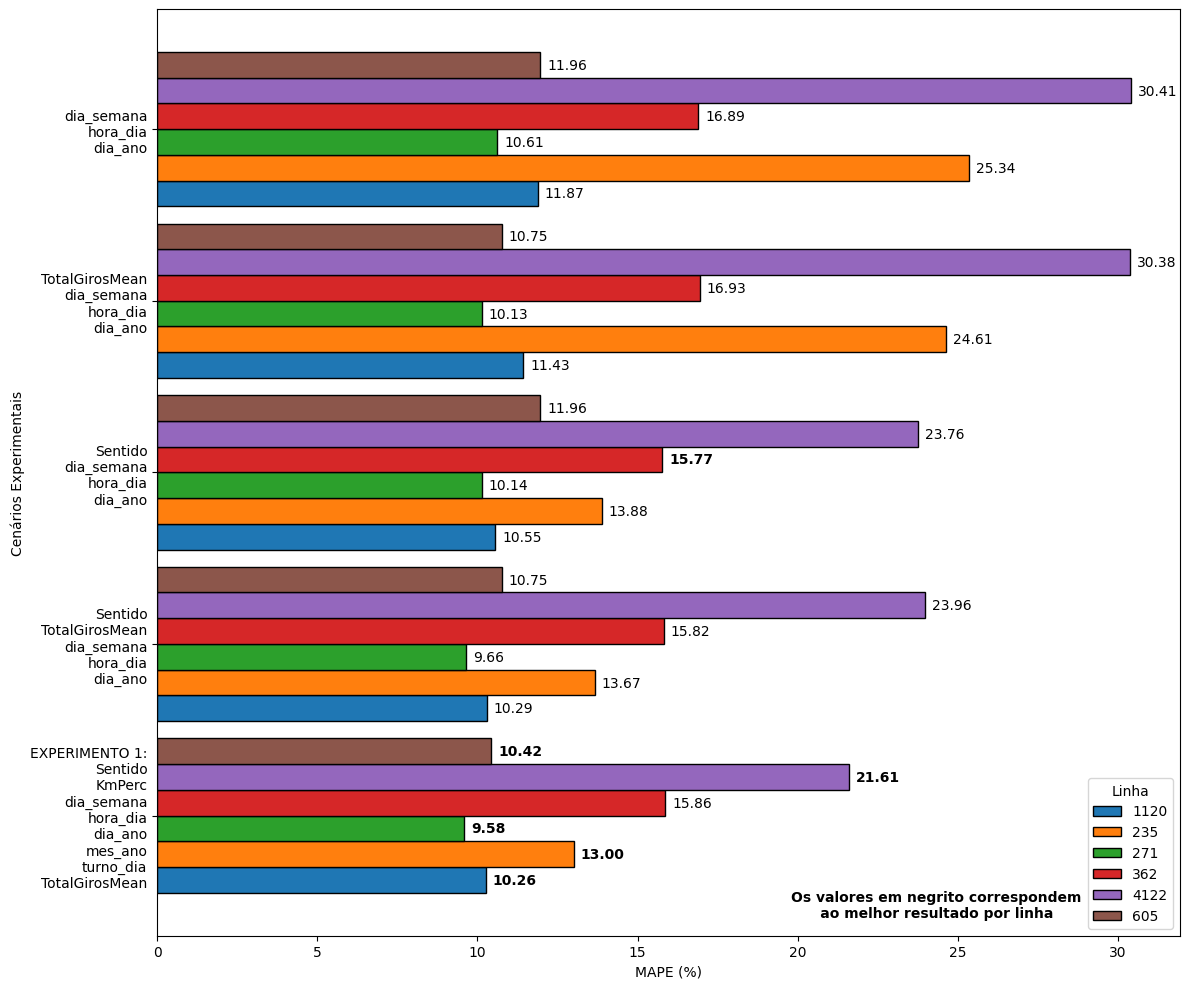

In [47]:
import re

def extrair_valores(text):
    match = re.search(r"\[([^]]+)\]", text)
    if match:
        return match.group(1)
    return ''

b = a[(a["Métrica"] == "MAPE") & (a["Modelo"] == "Linear Regression") ]
b["Valor"] = b["Valor"] * 100
b["Teste"] = b["Teste"].apply(extrair_valores)
b["Teste"] = b["Teste"].str.replace(",", "\n").str.replace("'", "")
b["Teste"] = b["Teste"].replace({"Sentido\nKmPerc\ndia_semana\nhora_dia\ndia_ano\nmes_ano\nturno_dia\nTotalGirosMean": "EXPERIMENTO 1:\nSentido\nKmPerc\ndia_semana\nhora_dia\ndia_ano\nmes_ano\nturno_dia\nTotalGirosMean"})

df_pivot = b.pivot(index='Teste', columns='Rota', values='Valor')

plt.rcParams["figure.autolayout"] = True

ax = df_pivot.plot(kind='barh', width = 0.9, figsize=[12, 10], edgecolor="black")

min_linha = b.groupby("Rota").agg({"Valor": "min"})["Valor"].unique()

for p in ax.patches:
    value = p.get_width()
    value_f = "{:.2f}".format(value)
    if value in min_linha:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontweight='bold')
    else:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.xlabel("MAPE (%)")
plt.ylabel("Cenários Experimentais")

ax.legend(title="Linha")
ax.text(0.62, 0.02, "Os valores em negrito correspondem\n      ao melhor resultado por linha", transform=ax.transAxes, fontsize=10, color="black", fontweight="bold")

plt.savefig("Results/resultados_permutacao_lr.svg")
plt.savefig("Results/resultados_permutacao_lr.png")



# Testes tempos anteriores

In [48]:
df["DuraçãoViagem_1"] = df["DuraçãoViagem"]
df["DuraçãoViagem_2"] = df["DuraçãoViagem"]
df["DuraçãoViagem_3"] = df["DuraçãoViagem"]
df["DuraçãoViagem_4"] = df["DuraçãoViagem"]
df["DuraçãoViagem_5"] = df["DuraçãoViagem"]

df['DuraçãoViagem_1'] = df.groupby('Linha')['DuraçãoViagem'].shift(1)
df['DuraçãoViagem_2'] = df.groupby('Linha')['DuraçãoViagem'].shift(2)
df['DuraçãoViagem_3'] = df.groupby('Linha')['DuraçãoViagem'].shift(3)
df['DuraçãoViagem_4'] = df.groupby('Linha')['DuraçãoViagem'].shift(4)
df['DuraçãoViagem_5'] = df.groupby('Linha')['DuraçãoViagem'].shift(5)

df.dropna(subset=['DuraçãoViagem_5'] ,inplace=True)

df

Sentido Linha  DuraçãoViagem  TotalGiros  KmPerc                 Ini  \
29319        0  1120           3960          18  31.218 2018-11-06 09:05:00   
29395        1  1120           3660          16  30.640 2018-11-06 10:20:00   
29320        0  1120           4260          22  31.218 2018-11-06 11:21:00   
29321        1  1120           4080          17  30.640 2018-11-06 11:26:00   
29322        0  1120           4620          10  31.218 2018-11-06 12:34:00   
...        ...   ...            ...         ...     ...                 ...   
35277        0   605           3900          16  19.437 2019-10-31 12:51:00   
35278        0   605           3780          10  19.437 2019-10-31 13:39:00   
35279        0   605           3780          18  19.437 2019-10-31 15:57:00   
35280        0   605           4440          26  19.437 2019-10-31 16:58:00   
35281        0   605           2580           2  19.437 2019-10-31 19:54:00   

                      Fim  dia_semana  hora_dia  dia_ano  mes_ano  turno_dia  \
29319 2018-11-06 10:11:00           2         9      310       11          2   
29395 2018-11-06 11:21:00           2        10      310       11          2   
29320 2018-11-06 12:32:00           2        11      310       11          2   
29321 2018-11-06 12:34:00           2        11      310       11          2   
29322 2018-11-06 13:51:00           2        12      310       11          2   
...                   ...         ...       ...      ...      ...        ...   
35277 2019-10-31 13:56:00           4        12      304       10          2   
35278 2019-10-31 14:42:00           4        13      304       10          2   
35279 2019-10-31 17:00:00           4        15      304       10          2   
35280 2019-10-31 18:12:00           4        16      304       10          2   
35281 2019-10-31 20:37:00           4        19      304       10          4   

       TotalGirosMean  DuraçãoViagem_1  DuraçãoViagem_2  DuraçãoViagem_3  \
29319            24.0           3060.0           4320.0           3720.0   
29395             5.0           3960.0           3060.0           4320.0   
29320            11.0           3660.0           3960.0           3060.0   
29321            11.0           4260.0           3660.0           3960.0   
29322            15.0           4080.0           4260.0           3660.0   
...               ...              ...              ...              ...   
35277            17.0           3420.0           3360.0           3180.0   
35278             5.0           3900.0           3420.0           3360.0   
35279            10.5           3780.0           3900.0           3420.0   
35280            27.0           3780.0           3780.0           3900.0   
35281             3.0           4440.0           3780.0           3780.0   

       DuraçãoViagem_4  DuraçãoViagem_5  
29319           4560.0           3420.0  
29395           3720.0           4560.0  
29320           4320.0           3720.0  
29321           3060.0           4320.0  
29322           3960.0           3060.0  
...                ...              ...  
35277           3300.0           4620.0  
35278           3180.0           3300.0  
35279           3360.0           3180.0  
35280           3420.0           3360.0  
35281           3900.0           3420.0  

[38696 rows x 18 columns]

In [49]:
df_mean = df.copy()
df_mean["data"] = df_mean["Ini"].dt.date
df_mean = df_mean.groupby(["Linha", "data", "hora_dia"], as_index=False).agg({"DuraçãoViagem": "mean"}).reset_index(drop=True)
df_mean.rename({"DuraçãoViagem": "DuraçãoViagemMean"}, axis=1, inplace=True)
df_mean

Linha        data  hora_dia  DuraçãoViagemMean
0      1120  2018-11-06         9             3960.0
1      1120  2018-11-06        10             3660.0
2      1120  2018-11-06        11             4170.0
3      1120  2018-11-06        12             4140.0
4      1120  2018-11-06        13             3990.0
...     ...         ...       ...                ...
20160   605  2019-10-31        12             3900.0
20161   605  2019-10-31        13             3780.0
20162   605  2019-10-31        15             3780.0
20163   605  2019-10-31        16             4440.0
20164   605  2019-10-31        19             2580.0

[20165 rows x 4 columns]

In [50]:
df["d-1"] = df["Ini"].dt.date - pd.Timedelta(days=1)
df = pd.merge(left=df, right=df_mean, left_on=["Linha", "d-1", "hora_dia"], right_on=["Linha", "data", "hora_dia"])
df.drop(["d-1", "data"], axis=1, inplace=True)
df

Sentido Linha  DuraçãoViagem  TotalGiros  KmPerc                 Ini  \
0            0  1120           4500          17  31.218 2018-11-07 09:08:00   
1            1  1120           3360          13  30.640 2018-11-07 10:22:00   
2            0  1120           4560          33  31.218 2018-11-07 11:19:00   
3            1  1120           4260          19  30.640 2018-11-07 11:20:00   
4            0  1120           4320          13  31.218 2018-11-07 12:31:00   
...        ...   ...            ...         ...     ...                 ...   
32763        0   605           3900          16  19.437 2019-10-31 12:51:00   
32764        0   605           3780          10  19.437 2019-10-31 13:39:00   
32765        0   605           3780          18  19.437 2019-10-31 15:57:00   
32766        0   605           4440          26  19.437 2019-10-31 16:58:00   
32767        0   605           2580           2  19.437 2019-10-31 19:54:00   

                      Fim  dia_semana  hora_dia  dia_ano  mes_ano  turno_dia  \
0     2018-11-07 10:23:00           3         9      311       11          2   
1     2018-11-07 11:18:00           3        10      311       11          2   
2     2018-11-07 12:35:00           3        11      311       11          2   
3     2018-11-07 12:31:00           3        11      311       11          2   
4     2018-11-07 13:43:00           3        12      311       11          2   
...                   ...         ...       ...      ...      ...        ...   
32763 2019-10-31 13:56:00           4        12      304       10          2   
32764 2019-10-31 14:42:00           4        13      304       10          2   
32765 2019-10-31 17:00:00           4        15      304       10          2   
32766 2019-10-31 18:12:00           4        16      304       10          2   
32767 2019-10-31 20:37:00           4        19      304       10          4   

       TotalGirosMean  DuraçãoViagem_1  DuraçãoViagem_2  DuraçãoViagem_3  \
0                18.0           3240.0           5100.0           3720.0   
1                16.0           4500.0           3240.0           5100.0   
2                19.5           3360.0           4500.0           3240.0   
3                19.5           4560.0           3360.0           4500.0   
4                17.5           4260.0           4560.0           3360.0   
...               ...              ...              ...              ...   
32763            17.0           3420.0           3360.0           3180.0   
32764             5.0           3900.0           3420.0           3360.0   
32765            10.5           3780.0           3900.0           3420.0   
32766            27.0           3780.0           3780.0           3900.0   
32767             3.0           4440.0           3780.0           3780.0   

       DuraçãoViagem_4  DuraçãoViagem_5  DuraçãoViagemMean  
0               4620.0           3480.0             3960.0  
1               3720.0           4620.0             3660.0  
2               5100.0           3720.0             4170.0  
3               3240.0           5100.0             4170.0  
4               4500.0           3240.0             4140.0  
...                ...              ...                ...  
32763           3300.0           4620.0             3780.0  
32764           3180.0           3300.0             3000.0  
32765           3360.0           3180.0             3330.0  
32766           3420.0           3360.0             3660.0  
32767           3900.0           3420.0             2760.0  

[32768 rows x 19 columns]

In [51]:
df["d-7"] = df["Ini"].dt.date - pd.Timedelta(days=7)
df = pd.merge(left=df, right=df_mean, left_on=["Linha", "d-7", "hora_dia"], right_on=["Linha", "data", "hora_dia"])
df.drop(["d-7", "data"], axis=1, inplace=True)
df.rename(columns={"DuraçãoViagemMean_x": "DuraçãoViagemMean_d-1", "DuraçãoViagemMean_y": "DuraçãoViagemMean_d-7"}, inplace=True)
df

Sentido Linha  DuraçãoViagem  TotalGiros  KmPerc                 Ini  \
0            0  1120           3840          19  31.218 2018-11-14 06:11:00   
1            0  1120           4560          33  31.218 2018-11-14 06:44:00   
2            1  1120           3240           1  30.640 2018-11-14 07:18:00   
3            0  1120           4200          17  31.218 2018-11-14 08:12:00   
4            1  1120           3300           7  30.640 2018-11-14 08:13:00   
...        ...   ...            ...         ...     ...                 ...   
30460        0   605           3900          16  19.437 2019-10-31 12:51:00   
30461        0   605           3780          10  19.437 2019-10-31 13:39:00   
30462        0   605           3780          18  19.437 2019-10-31 15:57:00   
30463        0   605           4440          26  19.437 2019-10-31 16:58:00   
30464        0   605           2580           2  19.437 2019-10-31 19:54:00   

                      Fim  dia_semana  hora_dia  dia_ano  mes_ano  turno_dia  \
0     2018-11-14 07:15:00           3         6      318       11          2   
1     2018-11-14 08:00:00           3         6      318       11          2   
2     2018-11-14 08:12:00           3         7      318       11          2   
3     2018-11-14 09:22:00           3         8      318       11          2   
4     2018-11-14 09:08:00           3         8      318       11          2   
...                   ...         ...       ...      ...      ...        ...   
30460 2019-10-31 13:56:00           4        12      304       10          2   
30461 2019-10-31 14:42:00           4        13      304       10          2   
30462 2019-10-31 17:00:00           4        15      304       10          2   
30463 2019-10-31 18:12:00           4        16      304       10          2   
30464 2019-10-31 20:37:00           4        19      304       10          4   

       TotalGirosMean  DuraçãoViagem_1  DuraçãoViagem_2  DuraçãoViagem_3  \
0                26.0           4260.0           4140.0           4740.0   
1                26.0           3840.0           4260.0           4140.0   
2                 4.0           4560.0           3840.0           4260.0   
3                 8.5           3240.0           4560.0           3840.0   
4                 8.5           4200.0           3240.0           4560.0   
...               ...              ...              ...              ...   
30460            17.0           3420.0           3360.0           3180.0   
30461             5.0           3900.0           3420.0           3360.0   
30462            10.5           3780.0           3900.0           3420.0   
30463            27.0           3780.0           3780.0           3900.0   
30464             3.0           4440.0           3780.0           3780.0   

       DuraçãoViagem_4  DuraçãoViagem_5  DuraçãoViagemMean_d-1  \
0               5040.0           4380.0                 4290.0   
1               4740.0           5040.0                 4290.0   
2               4140.0           4740.0                 3480.0   
3               4260.0           4140.0                 3930.0   
4               3840.0           4260.0                 3930.0   
...                ...              ...                    ...   
30460           3300.0           4620.0                 3780.0   
30461           3180.0           3300.0                 3000.0   
30462           3360.0           3180.0                 3330.0   
30463           3420.0           3360.0                 3660.0   
30464           3900.0           3420.0                 2760.0   

       DuraçãoViagemMean_d-7  
0                     4050.0  
1                     4050.0  
2                     3720.0  
3                     4170.0  
4                     4170.0  
...                      ...  
30460                 3780.0  
30461                 3840.0  
30462                 3720.0  
30463                 3960.0  
30464                 2700.0  

[30465 rows x 20 c

In [52]:
Colunas = [
    ['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7'],
    ['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano',"DuraçãoViagem_1"],
    ['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano',"DuraçãoViagem_1","DuraçãoViagem_2"],
    ['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano',"DuraçãoViagem_1","DuraçãoViagem_2","DuraçãoViagem_3"],
    ['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano',"DuraçãoViagem_1","DuraçãoViagem_2","DuraçãoViagem_3","DuraçãoViagem_4"],
    ['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano',"DuraçãoViagem_1","DuraçãoViagem_2","DuraçãoViagem_3","DuraçãoViagem_4","DuraçãoViagem_5"]
]
TestesNome = [
    "3 Tempos Anterios - ['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7']",
    "3 Tempos Anterios - ['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1]",
    "3 Tempos Anterios - ['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagem_2']",
    "3 Tempos Anterios - ['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagem_2','DuraçãoViagem_3']",
    "3 Tempos Anterios - ['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagem_2','DuraçãoViagem_3','DuraçãoViagem_4']",
    "3 Tempos Anterios - ['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagem_2','DuraçãoViagem_3','DuraçãoViagem_4','DuraçãoViagem_5']"

]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    shape = int(df_modelo.shape[0] * 0.3)
    df_teste = df_modelo[:shape]
    df_treino = df_modelo[shape:]
    for i in range(len(TestesNome)):
        teste_nome = TestesNome[i]
        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[Colunas[i]]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[Colunas[i]]
        y_treino = df_treino["DuraçãoViagem"]

        fi_xgb, fi_rf = cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)
        fi_xgb["rota"], fi_rf["rota"] = rota, rota
        fi_xgb["modelo"], fi_rf["modelo"] = "XGB", "RF"

        importance = pd.concat([importance, fi_xgb, fi_rf])

[0]	validation_0-rmse:2755.42712
[1]	validation_0-rmse:1954.17543
[2]	validation_0-rmse:1400.49984
[3]	validation_0-rmse:1022.75366
[4]	validation_0-rmse:768.64393
[5]	validation_0-rmse:599.89014
[6]	validation_0-rmse:492.21605
[7]	validation_0-rmse:424.44818
[8]	validation_0-rmse:379.47844
[9]	validation_0-rmse:355.04422
[10]	validation_0-rmse:340.48573
[11]	validation_0-rmse:330.98086
[12]	validation_0-rmse:322.08957
[13]	validation_0-rmse:317.98744
[14]	validation_0-rmse:315.94235
[15]	validation_0-rmse:314.25338
[16]	validation_0-rmse:308.23236
[17]	validation_0-rmse:305.46502
[18]	validation_0-rmse:303.74112
[19]	validation_0-rmse:299.71001
[20]	validation_0-rmse:293.05015
[21]	validation_0-rmse:292.26043
[22]	validation_0-rmse:289.13890
[23]	validation_0-rmse:283.18423
[24]	validation_0-rmse:276.19684
[25]	validation_0-rmse:274.17528
[26]	validation_0-rmse:267.90513
[27]	validation_0-rmse:262.04329
[28]	validation_0-rmse:256.39773
[29]	validation_0-rmse:251.81612
[30]	validation_

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[20]	validation_0-rmse:284.60166
[21]	validation_0-rmse:281.63427
[22]	validation_0-rmse:276.96433
[23]	validation_0-rmse:274.01020
[24]	validation_0-rmse:268.67595
[25]	validation_0-rmse:266.23821
[26]	validation_0-rmse:264.15923
[27]	validation_0-rmse:260.63589
[28]	validation_0-rmse:258.35969
[29]	validation_0-rmse:255.73798
[30]	validation_0-rmse:250.89152
[31]	validation_0-rmse:249.42317
[32]	validation_0-rmse:247.40840
[33]	validation_0-rmse:245.53371
[34]	validation_0-rmse:242.24233
[35]	validation_0-rmse:240.49344
[36]	validation_0-rmse:236.27531
[37]	validation_0-rmse:233.94600
[38]	validation_0-rmse:232.70522
[39]	validation_0-rmse:231.24598
[40]	validation_0-rmse:226.81911
[41]	validation_0-rmse:224.57734
[42]	validation_0-rmse:222.52359
[43]	validation_0-rmse:219.56400
[44]	validation_0-rmse:217.60877
[45]	validation_0-rmse:215.65767
[46]	validation_0-rmse:210.80435
[47]	validation_0-rmse:209.52504
[48]	validation_0-rmse:206.98191
[49]	validation_0-rmse:203.64813
[50]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[22]	validation_0-rmse:281.20440
[23]	validation_0-rmse:277.16615
[24]	validation_0-rmse:274.93938
[25]	validation_0-rmse:273.14707
[26]	validation_0-rmse:267.30155
[27]	validation_0-rmse:262.95623
[28]	validation_0-rmse:261.03618
[29]	validation_0-rmse:255.63618
[30]	validation_0-rmse:249.39152
[31]	validation_0-rmse:247.57634
[32]	validation_0-rmse:243.19741
[33]	validation_0-rmse:240.49875
[34]	validation_0-rmse:238.21224
[35]	validation_0-rmse:237.28376
[36]	validation_0-rmse:234.01318
[37]	validation_0-rmse:232.93886
[38]	validation_0-rmse:230.55738
[39]	validation_0-rmse:227.79947
[40]	validation_0-rmse:224.95828
[41]	validation_0-rmse:223.01764
[42]	validation_0-rmse:218.47738
[43]	validation_0-rmse:214.30873
[44]	validation_0-rmse:210.78064
[45]	validation_0-rmse:207.56672
[46]	validation_0-rmse:205.24602
[47]	validation_0-rmse:204.18806
[48]	validation_0-rmse:203.64378
[49]	validation_0-rmse:200.34157
[50]	validation_0-rmse:195.58698
[51]	validation_0-rmse:192.89801
[52]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[31]	validation_0-rmse:248.72644
[32]	validation_0-rmse:247.40444
[33]	validation_0-rmse:244.23562
[34]	validation_0-rmse:241.48435
[35]	validation_0-rmse:237.82944
[36]	validation_0-rmse:235.43707
[37]	validation_0-rmse:228.62323
[38]	validation_0-rmse:226.14210
[39]	validation_0-rmse:223.85405
[40]	validation_0-rmse:221.45366
[41]	validation_0-rmse:218.55363
[42]	validation_0-rmse:213.58051
[43]	validation_0-rmse:213.10907
[44]	validation_0-rmse:212.34814
[45]	validation_0-rmse:211.52896
[46]	validation_0-rmse:206.96000
[47]	validation_0-rmse:202.94125
[48]	validation_0-rmse:201.90278
[49]	validation_0-rmse:199.04371
[50]	validation_0-rmse:196.19364
[51]	validation_0-rmse:193.66986
[52]	validation_0-rmse:188.08178
[53]	validation_0-rmse:184.74070
[54]	validation_0-rmse:183.18547
[55]	validation_0-rmse:182.35451
[56]	validation_0-rmse:181.10812
[57]	validation_0-rmse:179.81622
[58]	validation_0-rmse:179.32891
[59]	validation_0-rmse:175.22094
[60]	validation_0-rmse:174.51903
[61]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[28]	validation_0-rmse:246.43214
[29]	validation_0-rmse:240.75587
[30]	validation_0-rmse:236.99985
[31]	validation_0-rmse:234.62454
[32]	validation_0-rmse:232.85780
[33]	validation_0-rmse:230.49593
[34]	validation_0-rmse:226.39151
[35]	validation_0-rmse:222.12713
[36]	validation_0-rmse:218.82251
[37]	validation_0-rmse:217.39539
[38]	validation_0-rmse:216.02544
[39]	validation_0-rmse:211.75279
[40]	validation_0-rmse:207.53335
[41]	validation_0-rmse:205.82760
[42]	validation_0-rmse:204.98722
[43]	validation_0-rmse:202.86769
[44]	validation_0-rmse:198.33875
[45]	validation_0-rmse:197.18003
[46]	validation_0-rmse:194.44673
[47]	validation_0-rmse:193.06885
[48]	validation_0-rmse:190.07718
[49]	validation_0-rmse:185.52359
[50]	validation_0-rmse:181.55579
[51]	validation_0-rmse:177.84840
[52]	validation_0-rmse:173.93467
[53]	validation_0-rmse:173.41138
[54]	validation_0-rmse:171.13705
[55]	validation_0-rmse:169.97808
[56]	validation_0-rmse:168.37627
[57]	validation_0-rmse:167.61907
[58]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[1]	validation_0-rmse:1953.25042
[2]	validation_0-rmse:1402.25373
[3]	validation_0-rmse:1022.69852
[4]	validation_0-rmse:767.01805
[5]	validation_0-rmse:596.30349
[6]	validation_0-rmse:487.78407
[7]	validation_0-rmse:417.62833
[8]	validation_0-rmse:375.46258
[9]	validation_0-rmse:349.83198
[10]	validation_0-rmse:333.62926
[11]	validation_0-rmse:319.70008
[12]	validation_0-rmse:311.04423
[13]	validation_0-rmse:304.65184
[14]	validation_0-rmse:297.86323
[15]	validation_0-rmse:295.28602
[16]	validation_0-rmse:287.67884
[17]	validation_0-rmse:283.24513
[18]	validation_0-rmse:281.18913
[19]	validation_0-rmse:275.39084
[20]	validation_0-rmse:268.26573
[21]	validation_0-rmse:263.80793
[22]	validation_0-rmse:261.87805
[23]	validation_0-rmse:255.19065
[24]	validation_0-rmse:252.24069
[25]	validation_0-rmse:251.67194
[26]	validation_0-rmse:242.84731
[27]	validation_0-rmse:241.97869
[28]	validation_0-rmse:239.37146
[29]	validation_0-rmse:236.98129
[30]	validation_0-rmse:231.59795
[31]	validation_

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[15]	validation_0-rmse:241.93607
[16]	validation_0-rmse:238.01152
[17]	validation_0-rmse:236.62868
[18]	validation_0-rmse:234.23615
[19]	validation_0-rmse:232.65965
[20]	validation_0-rmse:231.11779
[21]	validation_0-rmse:226.75680
[22]	validation_0-rmse:221.56600
[23]	validation_0-rmse:219.48487
[24]	validation_0-rmse:216.32664
[25]	validation_0-rmse:214.78128
[26]	validation_0-rmse:214.26595
[27]	validation_0-rmse:210.70694
[28]	validation_0-rmse:208.60334
[29]	validation_0-rmse:205.50402
[30]	validation_0-rmse:204.92906
[31]	validation_0-rmse:202.48702
[32]	validation_0-rmse:200.88402
[33]	validation_0-rmse:197.88266
[34]	validation_0-rmse:196.90000
[35]	validation_0-rmse:193.58579
[36]	validation_0-rmse:191.67626
[37]	validation_0-rmse:188.84267
[38]	validation_0-rmse:187.91866
[39]	validation_0-rmse:187.22264
[40]	validation_0-rmse:185.12626
[41]	validation_0-rmse:184.76239
[42]	validation_0-rmse:183.20476
[43]	validation_0-rmse:181.07356
[44]	validation_0-rmse:178.32507
[45]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[12]	validation_0-rmse:268.68914
[13]	validation_0-rmse:265.21346
[14]	validation_0-rmse:257.65573
[15]	validation_0-rmse:251.70017
[16]	validation_0-rmse:247.39707
[17]	validation_0-rmse:243.80921
[18]	validation_0-rmse:241.91779
[19]	validation_0-rmse:236.00817
[20]	validation_0-rmse:233.72450
[21]	validation_0-rmse:231.26014
[22]	validation_0-rmse:227.18764
[23]	validation_0-rmse:225.14147
[24]	validation_0-rmse:221.64241
[25]	validation_0-rmse:217.99625
[26]	validation_0-rmse:214.93691
[27]	validation_0-rmse:213.60514
[28]	validation_0-rmse:210.48429
[29]	validation_0-rmse:208.60311
[30]	validation_0-rmse:205.45278
[31]	validation_0-rmse:203.52276
[32]	validation_0-rmse:200.93953
[33]	validation_0-rmse:199.46522
[34]	validation_0-rmse:197.09652
[35]	validation_0-rmse:195.01058
[36]	validation_0-rmse:191.87297
[37]	validation_0-rmse:188.71995
[38]	validation_0-rmse:186.25658
[39]	validation_0-rmse:183.46791
[40]	validation_0-rmse:182.53527
[41]	validation_0-rmse:180.57131
[42]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1943.96837
[1]	validation_0-rmse:1390.95332
[2]	validation_0-rmse:1009.43266
[3]	validation_0-rmse:750.93050
[4]	validation_0-rmse:577.93137
[5]	validation_0-rmse:460.03997
[6]	validation_0-rmse:384.99383
[7]	validation_0-rmse:339.07172
[8]	validation_0-rmse:311.73802
[9]	validation_0-rmse:292.96842
[10]	validation_0-rmse:278.65717
[11]	validation_0-rmse:268.29263
[12]	validation_0-rmse:262.11197
[13]	validation_0-rmse:259.05388
[14]	validation_0-rmse:247.57353
[15]	validation_0-rmse:240.25012
[16]	validation_0-rmse:234.38058
[17]	validation_0-rmse:227.27047
[18]	validation_0-rmse:223.71252
[19]	validation_0-rmse:219.66683
[20]	validation_0-rmse:215.74980
[21]	validation_0-rmse:211.09461
[22]	validation_0-rmse:208.64012
[23]	validation_0-rmse:206.30259
[24]	validation_0-rmse:203.97472
[25]	validation_0-rmse:200.87190
[26]	validation_0-rmse:199.36801
[27]	validation_0-rmse:193.51073
[28]	validation_0-rmse:192.70994
[29]	validation_0-rmse:192.48611
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[23]	validation_0-rmse:202.96490
[24]	validation_0-rmse:201.09982
[25]	validation_0-rmse:200.48406
[26]	validation_0-rmse:198.68794
[27]	validation_0-rmse:195.58329
[28]	validation_0-rmse:190.85307
[29]	validation_0-rmse:185.76535
[30]	validation_0-rmse:184.25757
[31]	validation_0-rmse:182.94748
[32]	validation_0-rmse:181.13112
[33]	validation_0-rmse:179.67867
[34]	validation_0-rmse:177.59546
[35]	validation_0-rmse:173.81687
[36]	validation_0-rmse:172.58176
[37]	validation_0-rmse:171.12586
[38]	validation_0-rmse:168.75997
[39]	validation_0-rmse:167.80103
[40]	validation_0-rmse:166.74727
[41]	validation_0-rmse:165.60574
[42]	validation_0-rmse:163.29288
[43]	validation_0-rmse:162.23437
[44]	validation_0-rmse:161.18423
[45]	validation_0-rmse:158.29725
[46]	validation_0-rmse:157.02510
[47]	validation_0-rmse:155.52106
[48]	validation_0-rmse:154.42394
[49]	validation_0-rmse:152.74112
[50]	validation_0-rmse:149.20290
[51]	validation_0-rmse:148.57282
[52]	validation_0-rmse:146.25453
[53]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[28]	validation_0-rmse:184.40706
[29]	validation_0-rmse:181.84365
[30]	validation_0-rmse:180.50572
[31]	validation_0-rmse:176.37560
[32]	validation_0-rmse:175.08851
[33]	validation_0-rmse:172.40982
[34]	validation_0-rmse:169.42863
[35]	validation_0-rmse:164.55372
[36]	validation_0-rmse:162.71048
[37]	validation_0-rmse:161.45839
[38]	validation_0-rmse:160.17472
[39]	validation_0-rmse:159.01737
[40]	validation_0-rmse:158.25835
[41]	validation_0-rmse:155.91600
[42]	validation_0-rmse:155.14441
[43]	validation_0-rmse:154.38449
[44]	validation_0-rmse:151.62190
[45]	validation_0-rmse:148.83577
[46]	validation_0-rmse:145.58928
[47]	validation_0-rmse:142.80330
[48]	validation_0-rmse:142.31564
[49]	validation_0-rmse:139.98293
[50]	validation_0-rmse:137.67711
[51]	validation_0-rmse:136.26487
[52]	validation_0-rmse:135.58915
[53]	validation_0-rmse:134.87751
[54]	validation_0-rmse:133.61311
[55]	validation_0-rmse:132.35019
[56]	validation_0-rmse:132.17347
[57]	validation_0-rmse:130.78845
[58]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[23]	validation_0-rmse:193.94151
[24]	validation_0-rmse:191.30189
[25]	validation_0-rmse:189.98949
[26]	validation_0-rmse:188.09938
[27]	validation_0-rmse:186.48176
[28]	validation_0-rmse:185.21487
[29]	validation_0-rmse:183.10412
[30]	validation_0-rmse:182.18931
[31]	validation_0-rmse:179.93875
[32]	validation_0-rmse:178.67201
[33]	validation_0-rmse:175.92450
[34]	validation_0-rmse:171.95320
[35]	validation_0-rmse:169.89284
[36]	validation_0-rmse:167.30585
[37]	validation_0-rmse:165.60443
[38]	validation_0-rmse:163.57394
[39]	validation_0-rmse:162.72333
[40]	validation_0-rmse:161.72285
[41]	validation_0-rmse:158.78483
[42]	validation_0-rmse:156.00286
[43]	validation_0-rmse:154.71659
[44]	validation_0-rmse:154.25735
[45]	validation_0-rmse:151.18579
[46]	validation_0-rmse:148.90572
[47]	validation_0-rmse:145.53520
[48]	validation_0-rmse:145.00475
[49]	validation_0-rmse:143.66036
[50]	validation_0-rmse:143.27882
[51]	validation_0-rmse:141.27384
[52]	validation_0-rmse:139.66910
[53]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[11]	validation_0-rmse:152.17972
[12]	validation_0-rmse:150.32768
[13]	validation_0-rmse:149.23400
[14]	validation_0-rmse:147.54043
[15]	validation_0-rmse:146.51122
[16]	validation_0-rmse:146.05835
[17]	validation_0-rmse:143.86649
[18]	validation_0-rmse:142.91689
[19]	validation_0-rmse:142.04119
[20]	validation_0-rmse:141.43522
[21]	validation_0-rmse:140.92664
[22]	validation_0-rmse:139.69686
[23]	validation_0-rmse:138.89039
[24]	validation_0-rmse:138.60223
[25]	validation_0-rmse:137.50376
[26]	validation_0-rmse:137.17946
[27]	validation_0-rmse:136.90198
[28]	validation_0-rmse:136.43269
[29]	validation_0-rmse:135.69610
[30]	validation_0-rmse:134.80568
[31]	validation_0-rmse:133.88628
[32]	validation_0-rmse:133.00788
[33]	validation_0-rmse:132.51411
[34]	validation_0-rmse:131.90208
[35]	validation_0-rmse:131.44269
[36]	validation_0-rmse:131.23113
[37]	validation_0-rmse:130.52319
[38]	validation_0-rmse:129.88011
[39]	validation_0-rmse:129.66778
[40]	validation_0-rmse:129.24097
[41]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1013.88237
[1]	validation_0-rmse:720.85230
[2]	validation_0-rmse:519.32159
[3]	validation_0-rmse:382.38860
[4]	validation_0-rmse:291.66863
[5]	validation_0-rmse:233.54502
[6]	validation_0-rmse:198.88652
[7]	validation_0-rmse:178.55564
[8]	validation_0-rmse:167.31387
[9]	validation_0-rmse:160.90732
[10]	validation_0-rmse:157.52474
[11]	validation_0-rmse:153.90616
[12]	validation_0-rmse:152.25523
[13]	validation_0-rmse:150.47161
[14]	validation_0-rmse:150.05209
[15]	validation_0-rmse:149.59401
[16]	validation_0-rmse:148.34775
[17]	validation_0-rmse:147.66883
[18]	validation_0-rmse:147.25152
[19]	validation_0-rmse:147.02482
[20]	validation_0-rmse:145.82937
[21]	validation_0-rmse:145.15861
[22]	validation_0-rmse:144.83956
[23]	validation_0-rmse:144.70236
[24]	validation_0-rmse:143.79956
[25]	validation_0-rmse:143.27902
[26]	validation_0-rmse:141.93938
[27]	validation_0-rmse:141.33711
[28]	validation_0-rmse:140.30123
[29]	validation_0-rmse:139.59949
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1013.86729
[1]	validation_0-rmse:720.79444
[2]	validation_0-rmse:519.37721
[3]	validation_0-rmse:381.67249
[4]	validation_0-rmse:291.29968
[5]	validation_0-rmse:233.13617
[6]	validation_0-rmse:197.88421
[7]	validation_0-rmse:178.04772
[8]	validation_0-rmse:166.83496
[9]	validation_0-rmse:159.90291
[10]	validation_0-rmse:156.58456
[11]	validation_0-rmse:154.25304
[12]	validation_0-rmse:153.07398
[13]	validation_0-rmse:152.02773
[14]	validation_0-rmse:150.41705
[15]	validation_0-rmse:149.29601
[16]	validation_0-rmse:148.51243
[17]	validation_0-rmse:148.12265
[18]	validation_0-rmse:147.54149
[19]	validation_0-rmse:146.19413
[20]	validation_0-rmse:145.22823
[21]	validation_0-rmse:144.38153
[22]	validation_0-rmse:143.60844
[23]	validation_0-rmse:142.80833
[24]	validation_0-rmse:142.50718
[25]	validation_0-rmse:141.73037
[26]	validation_0-rmse:141.32925
[27]	validation_0-rmse:140.39389
[28]	validation_0-rmse:139.54729
[29]	validation_0-rmse:139.29824
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1013.86729
[1]	validation_0-rmse:720.79444
[2]	validation_0-rmse:519.37721
[3]	validation_0-rmse:381.71987
[4]	validation_0-rmse:291.27620
[5]	validation_0-rmse:232.66508
[6]	validation_0-rmse:197.80609
[7]	validation_0-rmse:177.44299
[8]	validation_0-rmse:166.43745
[9]	validation_0-rmse:158.57133
[10]	validation_0-rmse:155.14973
[11]	validation_0-rmse:153.11363
[12]	validation_0-rmse:151.12097
[13]	validation_0-rmse:150.29688
[14]	validation_0-rmse:148.98445
[15]	validation_0-rmse:147.78829
[16]	validation_0-rmse:147.38131
[17]	validation_0-rmse:146.31354
[18]	validation_0-rmse:144.34225
[19]	validation_0-rmse:143.42937
[20]	validation_0-rmse:142.68169
[21]	validation_0-rmse:141.46420
[22]	validation_0-rmse:140.98306
[23]	validation_0-rmse:139.84599
[24]	validation_0-rmse:139.33847
[25]	validation_0-rmse:139.08498
[26]	validation_0-rmse:138.09439
[27]	validation_0-rmse:137.68743
[28]	validation_0-rmse:136.53962
[29]	validation_0-rmse:136.14393
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1013.86729
[1]	validation_0-rmse:720.79444
[2]	validation_0-rmse:519.30615
[3]	validation_0-rmse:382.13967
[4]	validation_0-rmse:291.82008
[5]	validation_0-rmse:233.55136
[6]	validation_0-rmse:199.18305
[7]	validation_0-rmse:179.17375
[8]	validation_0-rmse:165.80656
[9]	validation_0-rmse:159.84981
[10]	validation_0-rmse:156.12204
[11]	validation_0-rmse:153.93189
[12]	validation_0-rmse:152.90142
[13]	validation_0-rmse:150.74544
[14]	validation_0-rmse:150.18782
[15]	validation_0-rmse:148.27056
[16]	validation_0-rmse:147.34341
[17]	validation_0-rmse:145.80189
[18]	validation_0-rmse:145.34487
[19]	validation_0-rmse:143.93888
[20]	validation_0-rmse:143.33090
[21]	validation_0-rmse:141.83826
[22]	validation_0-rmse:141.40546
[23]	validation_0-rmse:140.42762
[24]	validation_0-rmse:139.55721
[25]	validation_0-rmse:138.64965
[26]	validation_0-rmse:138.39104
[27]	validation_0-rmse:138.09679
[28]	validation_0-rmse:137.42048
[29]	validation_0-rmse:137.26606
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1013.86729
[1]	validation_0-rmse:720.79444
[2]	validation_0-rmse:519.27475
[3]	validation_0-rmse:381.83002
[4]	validation_0-rmse:291.37762
[5]	validation_0-rmse:232.83165
[6]	validation_0-rmse:198.02120
[7]	validation_0-rmse:176.71164
[8]	validation_0-rmse:165.61002
[9]	validation_0-rmse:159.59392
[10]	validation_0-rmse:155.64183
[11]	validation_0-rmse:153.00673
[12]	validation_0-rmse:150.66072
[13]	validation_0-rmse:149.59862
[14]	validation_0-rmse:147.25102
[15]	validation_0-rmse:146.47956
[16]	validation_0-rmse:145.65138
[17]	validation_0-rmse:144.29076
[18]	validation_0-rmse:143.76805
[19]	validation_0-rmse:143.13888
[20]	validation_0-rmse:141.70884
[21]	validation_0-rmse:141.12609
[22]	validation_0-rmse:140.74663
[23]	validation_0-rmse:140.09498
[24]	validation_0-rmse:139.57254
[25]	validation_0-rmse:138.71503
[26]	validation_0-rmse:138.29200
[27]	validation_0-rmse:138.15194
[28]	validation_0-rmse:137.13676
[29]	validation_0-rmse:136.84039
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:603.66274
[1]	validation_0-rmse:436.09922
[2]	validation_0-rmse:322.83669
[3]	validation_0-rmse:247.78078
[4]	validation_0-rmse:200.11196
[5]	validation_0-rmse:170.17268
[6]	validation_0-rmse:152.68381
[7]	validation_0-rmse:142.58091
[8]	validation_0-rmse:136.95553
[9]	validation_0-rmse:133.18307
[10]	validation_0-rmse:131.01352
[11]	validation_0-rmse:128.11897
[12]	validation_0-rmse:126.93583
[13]	validation_0-rmse:126.47359
[14]	validation_0-rmse:125.87291
[15]	validation_0-rmse:124.67193
[16]	validation_0-rmse:123.86148
[17]	validation_0-rmse:122.50578
[18]	validation_0-rmse:121.36456
[19]	validation_0-rmse:120.45129
[20]	validation_0-rmse:119.08255
[21]	validation_0-rmse:118.39092
[22]	validation_0-rmse:117.48290
[23]	validation_0-rmse:117.14308
[24]	validation_0-rmse:116.42812
[25]	validation_0-rmse:116.26872
[26]	validation_0-rmse:115.36068
[27]	validation_0-rmse:114.57676
[28]	validation_0-rmse:113.30239
[29]	validation_0-rmse:112.48010
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:604.02391
[1]	validation_0-rmse:436.94953
[2]	validation_0-rmse:323.80401
[3]	validation_0-rmse:249.17742
[4]	validation_0-rmse:201.41846
[5]	validation_0-rmse:171.66887
[6]	validation_0-rmse:155.08166
[7]	validation_0-rmse:145.58631
[8]	validation_0-rmse:140.06763
[9]	validation_0-rmse:136.10847
[10]	validation_0-rmse:134.33725
[11]	validation_0-rmse:133.25927
[12]	validation_0-rmse:132.16213
[13]	validation_0-rmse:130.50084
[14]	validation_0-rmse:129.42828
[15]	validation_0-rmse:128.03774
[16]	validation_0-rmse:126.91897
[17]	validation_0-rmse:126.03319
[18]	validation_0-rmse:125.02367
[19]	validation_0-rmse:124.05002
[20]	validation_0-rmse:122.06052
[21]	validation_0-rmse:121.55408
[22]	validation_0-rmse:120.19314
[23]	validation_0-rmse:119.51775
[24]	validation_0-rmse:119.28578
[25]	validation_0-rmse:118.82790
[26]	validation_0-rmse:117.89364
[27]	validation_0-rmse:116.60009
[28]	validation_0-rmse:116.00248
[29]	validation_0-rmse:115.64309
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:604.02391
[1]	validation_0-rmse:436.80308
[2]	validation_0-rmse:323.56978
[3]	validation_0-rmse:248.97615
[4]	validation_0-rmse:201.56974
[5]	validation_0-rmse:172.17224
[6]	validation_0-rmse:155.29640
[7]	validation_0-rmse:145.16884
[8]	validation_0-rmse:139.01792
[9]	validation_0-rmse:135.24567
[10]	validation_0-rmse:132.24377
[11]	validation_0-rmse:129.86004
[12]	validation_0-rmse:129.04931
[13]	validation_0-rmse:128.31635
[14]	validation_0-rmse:127.15177
[15]	validation_0-rmse:125.33511
[16]	validation_0-rmse:124.57970
[17]	validation_0-rmse:123.20961
[18]	validation_0-rmse:122.97068
[19]	validation_0-rmse:121.62908
[20]	validation_0-rmse:120.40998
[21]	validation_0-rmse:120.03896
[22]	validation_0-rmse:119.13846
[23]	validation_0-rmse:117.55888
[24]	validation_0-rmse:117.00158
[25]	validation_0-rmse:115.67772
[26]	validation_0-rmse:114.73327
[27]	validation_0-rmse:113.72957
[28]	validation_0-rmse:112.61115
[29]	validation_0-rmse:111.95795
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:604.02256
[1]	validation_0-rmse:436.79180
[2]	validation_0-rmse:323.55764
[3]	validation_0-rmse:248.66561
[4]	validation_0-rmse:201.33378
[5]	validation_0-rmse:172.51248
[6]	validation_0-rmse:155.17958
[7]	validation_0-rmse:145.51879
[8]	validation_0-rmse:138.83329
[9]	validation_0-rmse:135.33942
[10]	validation_0-rmse:132.80212
[11]	validation_0-rmse:130.57042
[12]	validation_0-rmse:129.37021
[13]	validation_0-rmse:128.69450
[14]	validation_0-rmse:126.90541
[15]	validation_0-rmse:125.55886
[16]	validation_0-rmse:123.62964
[17]	validation_0-rmse:122.12649
[18]	validation_0-rmse:121.81598
[19]	validation_0-rmse:120.68705
[20]	validation_0-rmse:120.03367
[21]	validation_0-rmse:119.67374
[22]	validation_0-rmse:118.54352
[23]	validation_0-rmse:118.08059
[24]	validation_0-rmse:117.06852
[25]	validation_0-rmse:116.14219
[26]	validation_0-rmse:114.76261
[27]	validation_0-rmse:113.94394
[28]	validation_0-rmse:113.49212
[29]	validation_0-rmse:113.15138
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:604.02256
[1]	validation_0-rmse:436.80675
[2]	validation_0-rmse:323.63610
[3]	validation_0-rmse:248.57459
[4]	validation_0-rmse:201.06089
[5]	validation_0-rmse:172.00402
[6]	validation_0-rmse:154.22184
[7]	validation_0-rmse:143.95895
[8]	validation_0-rmse:138.11260
[9]	validation_0-rmse:135.17758
[10]	validation_0-rmse:131.71995
[11]	validation_0-rmse:130.19729
[12]	validation_0-rmse:128.84814
[13]	validation_0-rmse:125.96755
[14]	validation_0-rmse:125.47220
[15]	validation_0-rmse:124.64512
[16]	validation_0-rmse:123.18077
[17]	validation_0-rmse:121.37836
[18]	validation_0-rmse:120.83739
[19]	validation_0-rmse:120.18298
[20]	validation_0-rmse:119.34539
[21]	validation_0-rmse:117.66645
[22]	validation_0-rmse:116.11036
[23]	validation_0-rmse:114.95983
[24]	validation_0-rmse:114.07547
[25]	validation_0-rmse:113.28401
[26]	validation_0-rmse:112.06145
[27]	validation_0-rmse:111.63932
[28]	validation_0-rmse:110.36815
[29]	validation_0-rmse:109.49442
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:604.01301
[1]	validation_0-rmse:436.75526
[2]	validation_0-rmse:323.47600
[3]	validation_0-rmse:248.48719
[4]	validation_0-rmse:200.60901
[5]	validation_0-rmse:171.84070
[6]	validation_0-rmse:154.28051
[7]	validation_0-rmse:144.20546
[8]	validation_0-rmse:137.74397
[9]	validation_0-rmse:133.50882
[10]	validation_0-rmse:131.39043
[11]	validation_0-rmse:129.42715
[12]	validation_0-rmse:127.80464
[13]	validation_0-rmse:127.08009
[14]	validation_0-rmse:126.38549
[15]	validation_0-rmse:124.61095
[16]	validation_0-rmse:123.46621
[17]	validation_0-rmse:122.17912
[18]	validation_0-rmse:120.05738
[19]	validation_0-rmse:118.48488
[20]	validation_0-rmse:117.25505
[21]	validation_0-rmse:116.55746
[22]	validation_0-rmse:115.84402
[23]	validation_0-rmse:115.36413
[24]	validation_0-rmse:114.50920
[25]	validation_0-rmse:113.55550
[26]	validation_0-rmse:111.77889
[27]	validation_0-rmse:110.69943
[28]	validation_0-rmse:110.11781
[29]	validation_0-rmse:109.67611
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2253.87520
[1]	validation_0-rmse:1620.24970
[2]	validation_0-rmse:1184.20823
[3]	validation_0-rmse:889.03848
[4]	validation_0-rmse:691.60123
[5]	validation_0-rmse:563.39877
[6]	validation_0-rmse:478.73238
[7]	validation_0-rmse:429.62094
[8]	validation_0-rmse:397.96348
[9]	validation_0-rmse:372.85380
[10]	validation_0-rmse:358.28350
[11]	validation_0-rmse:350.71670
[12]	validation_0-rmse:341.01874
[13]	validation_0-rmse:330.11939
[14]	validation_0-rmse:323.77942
[15]	validation_0-rmse:321.76869
[16]	validation_0-rmse:313.46095
[17]	validation_0-rmse:309.83275
[18]	validation_0-rmse:301.84562
[19]	validation_0-rmse:294.88595
[20]	validation_0-rmse:290.44840
[21]	validation_0-rmse:284.97995
[22]	validation_0-rmse:279.81682
[23]	validation_0-rmse:278.39566
[24]	validation_0-rmse:276.41312
[25]	validation_0-rmse:272.94258
[26]	validation_0-rmse:269.63474
[27]	validation_0-rmse:267.14924
[28]	validation_0-rmse:265.49772
[29]	validation_0-rmse:262.49824
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[29]	validation_0-rmse:256.82830
[30]	validation_0-rmse:254.45815
[31]	validation_0-rmse:251.40707
[32]	validation_0-rmse:246.87543
[33]	validation_0-rmse:243.62791
[34]	validation_0-rmse:241.34068
[35]	validation_0-rmse:236.77066
[36]	validation_0-rmse:235.00273
[37]	validation_0-rmse:233.33397
[38]	validation_0-rmse:230.92999
[39]	validation_0-rmse:227.44664
[40]	validation_0-rmse:225.91927
[41]	validation_0-rmse:224.12759
[42]	validation_0-rmse:219.02079
[43]	validation_0-rmse:217.22352
[44]	validation_0-rmse:215.49570
[45]	validation_0-rmse:213.30403
[46]	validation_0-rmse:210.58183
[47]	validation_0-rmse:205.22652
[48]	validation_0-rmse:203.59978
[49]	validation_0-rmse:200.10718
[50]	validation_0-rmse:198.01189
[51]	validation_0-rmse:195.51641
[52]	validation_0-rmse:193.48465
[53]	validation_0-rmse:191.70923
[54]	validation_0-rmse:190.75051
[55]	validation_0-rmse:190.37111
[56]	validation_0-rmse:186.66001
[57]	validation_0-rmse:185.82120
[58]	validation_0-rmse:182.93787
[59]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[31]	validation_0-rmse:245.49060
[32]	validation_0-rmse:244.68254
[33]	validation_0-rmse:242.91085
[34]	validation_0-rmse:241.13014
[35]	validation_0-rmse:236.84769
[36]	validation_0-rmse:232.96089
[37]	validation_0-rmse:230.46291
[38]	validation_0-rmse:229.10509
[39]	validation_0-rmse:224.26950
[40]	validation_0-rmse:220.81393
[41]	validation_0-rmse:217.44792
[42]	validation_0-rmse:217.03260
[43]	validation_0-rmse:216.55286
[44]	validation_0-rmse:211.85322
[45]	validation_0-rmse:208.39264
[46]	validation_0-rmse:206.71704
[47]	validation_0-rmse:200.26377
[48]	validation_0-rmse:198.64010
[49]	validation_0-rmse:196.67700
[50]	validation_0-rmse:195.64235
[51]	validation_0-rmse:191.39393
[52]	validation_0-rmse:188.51163
[53]	validation_0-rmse:185.96694
[54]	validation_0-rmse:184.63414
[55]	validation_0-rmse:182.76914
[56]	validation_0-rmse:182.47695
[57]	validation_0-rmse:179.08019
[58]	validation_0-rmse:176.88273
[59]	validation_0-rmse:174.29425
[60]	validation_0-rmse:171.06964
[61]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[25]	validation_0-rmse:263.51904
[26]	validation_0-rmse:259.19869
[27]	validation_0-rmse:255.76571
[28]	validation_0-rmse:253.61963
[29]	validation_0-rmse:249.47793
[30]	validation_0-rmse:246.46171
[31]	validation_0-rmse:244.37757
[32]	validation_0-rmse:242.89666
[33]	validation_0-rmse:236.99151
[34]	validation_0-rmse:235.93142
[35]	validation_0-rmse:230.11573
[36]	validation_0-rmse:226.11177
[37]	validation_0-rmse:220.09438
[38]	validation_0-rmse:214.98936
[39]	validation_0-rmse:214.42029
[40]	validation_0-rmse:210.35905
[41]	validation_0-rmse:207.02343
[42]	validation_0-rmse:205.80947
[43]	validation_0-rmse:201.87153
[44]	validation_0-rmse:195.91143
[45]	validation_0-rmse:193.63456
[46]	validation_0-rmse:191.86337
[47]	validation_0-rmse:191.00998
[48]	validation_0-rmse:190.59047
[49]	validation_0-rmse:189.89966
[50]	validation_0-rmse:189.38445
[51]	validation_0-rmse:188.13574
[52]	validation_0-rmse:184.81321
[53]	validation_0-rmse:180.81183
[54]	validation_0-rmse:177.28728
[55]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[33]	validation_0-rmse:230.36173
[34]	validation_0-rmse:228.16304
[35]	validation_0-rmse:223.00742
[36]	validation_0-rmse:217.55538
[37]	validation_0-rmse:213.04734
[38]	validation_0-rmse:208.80645
[39]	validation_0-rmse:206.99588
[40]	validation_0-rmse:204.25231
[41]	validation_0-rmse:201.81160
[42]	validation_0-rmse:198.79040
[43]	validation_0-rmse:194.33951
[44]	validation_0-rmse:189.80534
[45]	validation_0-rmse:188.04576
[46]	validation_0-rmse:183.35187
[47]	validation_0-rmse:179.27941
[48]	validation_0-rmse:178.89788
[49]	validation_0-rmse:178.09060
[50]	validation_0-rmse:176.86288
[51]	validation_0-rmse:173.27993
[52]	validation_0-rmse:172.17442
[53]	validation_0-rmse:170.67364
[54]	validation_0-rmse:169.69576
[55]	validation_0-rmse:168.80661
[56]	validation_0-rmse:167.28503
[57]	validation_0-rmse:163.31587
[58]	validation_0-rmse:158.22924
[59]	validation_0-rmse:155.86063
[60]	validation_0-rmse:151.69488
[61]	validation_0-rmse:150.26594
[62]	validation_0-rmse:148.29267
[63]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[42]	validation_0-rmse:191.23657
[43]	validation_0-rmse:188.91396
[44]	validation_0-rmse:184.85800
[45]	validation_0-rmse:183.95047
[46]	validation_0-rmse:182.15379
[47]	validation_0-rmse:177.83232
[48]	validation_0-rmse:172.49814
[49]	validation_0-rmse:170.32410
[50]	validation_0-rmse:167.30766
[51]	validation_0-rmse:164.80169
[52]	validation_0-rmse:162.32719
[53]	validation_0-rmse:158.90210
[54]	validation_0-rmse:157.53187
[55]	validation_0-rmse:154.93185
[56]	validation_0-rmse:151.06065
[57]	validation_0-rmse:147.85312
[58]	validation_0-rmse:146.29974
[59]	validation_0-rmse:144.91529
[60]	validation_0-rmse:141.56037
[61]	validation_0-rmse:139.52223
[62]	validation_0-rmse:135.58671
[63]	validation_0-rmse:134.74279
[64]	validation_0-rmse:134.05416
[65]	validation_0-rmse:131.80282
[66]	validation_0-rmse:130.64365
[67]	validation_0-rmse:127.99949
[68]	validation_0-rmse:125.18330
[69]	validation_0-rmse:122.66128
[70]	validation_0-rmse:119.27864
[71]	validation_0-rmse:117.14921
[72]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[28]	validation_0-rmse:186.59297
[29]	validation_0-rmse:184.70620
[30]	validation_0-rmse:182.09870
[31]	validation_0-rmse:177.90581
[32]	validation_0-rmse:175.10724
[33]	validation_0-rmse:171.26932
[34]	validation_0-rmse:169.06131
[35]	validation_0-rmse:167.00369
[36]	validation_0-rmse:162.84139
[37]	validation_0-rmse:159.26449
[38]	validation_0-rmse:158.27156
[39]	validation_0-rmse:153.76034
[40]	validation_0-rmse:150.62750
[41]	validation_0-rmse:147.83941
[42]	validation_0-rmse:146.59311
[43]	validation_0-rmse:145.78557
[44]	validation_0-rmse:143.19220
[45]	validation_0-rmse:140.24543
[46]	validation_0-rmse:136.57418
[47]	validation_0-rmse:132.28652
[48]	validation_0-rmse:131.19720
[49]	validation_0-rmse:127.41152
[50]	validation_0-rmse:124.62905
[51]	validation_0-rmse:122.65798
[52]	validation_0-rmse:120.14696
[53]	validation_0-rmse:118.54505
[54]	validation_0-rmse:117.49455
[55]	validation_0-rmse:115.14699
[56]	validation_0-rmse:112.76887
[57]	validation_0-rmse:110.54540
[58]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[58]	validation_0-rmse:135.90646
[59]	validation_0-rmse:131.74458
[60]	validation_0-rmse:129.37849
[61]	validation_0-rmse:127.23188
[62]	validation_0-rmse:125.73498
[63]	validation_0-rmse:125.17531
[64]	validation_0-rmse:122.29271
[65]	validation_0-rmse:120.58520
[66]	validation_0-rmse:119.34276
[67]	validation_0-rmse:118.82497
[68]	validation_0-rmse:116.01045
[69]	validation_0-rmse:114.03399
[70]	validation_0-rmse:111.53772
[71]	validation_0-rmse:110.41634
[72]	validation_0-rmse:110.04319
[73]	validation_0-rmse:109.45330
[74]	validation_0-rmse:108.56636
[75]	validation_0-rmse:107.11242
[76]	validation_0-rmse:106.65362
[77]	validation_0-rmse:106.35032
[78]	validation_0-rmse:105.31697
[79]	validation_0-rmse:103.73467
[80]	validation_0-rmse:101.44056
[81]	validation_0-rmse:99.75720
[82]	validation_0-rmse:97.44202
[83]	validation_0-rmse:94.65650
[84]	validation_0-rmse:92.47620
[85]	validation_0-rmse:90.31592
[86]	validation_0-rmse:88.83145
[87]	validation_0-rmse:87.56336
[88]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[52]	validation_0-rmse:120.13091
[53]	validation_0-rmse:118.15789
[54]	validation_0-rmse:115.82384
[55]	validation_0-rmse:113.32917
[56]	validation_0-rmse:112.88930
[57]	validation_0-rmse:111.46315
[58]	validation_0-rmse:111.09779
[59]	validation_0-rmse:108.84546
[60]	validation_0-rmse:107.15118
[61]	validation_0-rmse:103.94904
[62]	validation_0-rmse:101.26002
[63]	validation_0-rmse:100.35119
[64]	validation_0-rmse:97.95109
[65]	validation_0-rmse:96.93387
[66]	validation_0-rmse:94.84855
[67]	validation_0-rmse:93.31334
[68]	validation_0-rmse:90.17166
[69]	validation_0-rmse:89.54916
[70]	validation_0-rmse:88.89925
[71]	validation_0-rmse:87.88018
[72]	validation_0-rmse:87.11202
[73]	validation_0-rmse:85.83144
[74]	validation_0-rmse:85.36648
[75]	validation_0-rmse:84.89818
[76]	validation_0-rmse:84.76108
[77]	validation_0-rmse:84.55016
[78]	validation_0-rmse:83.13302
[79]	validation_0-rmse:82.18321
[80]	validation_0-rmse:82.06690
[81]	validation_0-rmse:80.31792
[82]	validation_0-rmse:77.65

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[67]	validation_0-rmse:78.51715
[68]	validation_0-rmse:77.71639
[69]	validation_0-rmse:76.94280
[70]	validation_0-rmse:73.80322
[71]	validation_0-rmse:72.67257
[72]	validation_0-rmse:72.44807
[73]	validation_0-rmse:72.19562
[74]	validation_0-rmse:71.78720
[75]	validation_0-rmse:70.79790
[76]	validation_0-rmse:68.64691
[77]	validation_0-rmse:66.11855
[78]	validation_0-rmse:64.57380
[79]	validation_0-rmse:62.96262
[80]	validation_0-rmse:62.19253
[81]	validation_0-rmse:61.07133
[82]	validation_0-rmse:59.42306
[83]	validation_0-rmse:57.68293
[84]	validation_0-rmse:57.46573
[85]	validation_0-rmse:57.00387
[86]	validation_0-rmse:55.14210
[87]	validation_0-rmse:53.72793
[88]	validation_0-rmse:52.79972
[89]	validation_0-rmse:52.02942
[90]	validation_0-rmse:51.51630
[91]	validation_0-rmse:50.72083
[92]	validation_0-rmse:49.24727
[93]	validation_0-rmse:48.59340
[94]	validation_0-rmse:47.53268
[95]	validation_0-rmse:46.45931
[96]	validation_0-rmse:45.62569
[97]	validation_0-rmse:44.89207
[98]	val

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[59]	validation_0-rmse:83.03641
[60]	validation_0-rmse:82.17945
[61]	validation_0-rmse:81.83987
[62]	validation_0-rmse:79.04763
[63]	validation_0-rmse:76.28458
[64]	validation_0-rmse:73.70572
[65]	validation_0-rmse:72.23372
[66]	validation_0-rmse:70.10220
[67]	validation_0-rmse:69.25990
[68]	validation_0-rmse:68.10494
[69]	validation_0-rmse:67.45211
[70]	validation_0-rmse:66.55107
[71]	validation_0-rmse:65.22552
[72]	validation_0-rmse:63.59839
[73]	validation_0-rmse:62.56766
[74]	validation_0-rmse:61.78595
[75]	validation_0-rmse:59.90105
[76]	validation_0-rmse:57.97330
[77]	validation_0-rmse:56.50794
[78]	validation_0-rmse:55.09573
[79]	validation_0-rmse:54.66848
[80]	validation_0-rmse:54.31307
[81]	validation_0-rmse:52.79387
[82]	validation_0-rmse:52.11716
[83]	validation_0-rmse:51.74512
[84]	validation_0-rmse:50.21103
[85]	validation_0-rmse:49.98339
[86]	validation_0-rmse:48.41348
[87]	validation_0-rmse:48.15923
[88]	validation_0-rmse:47.77149
[89]	validation_0-rmse:46.82284
[90]	val

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[45]	validation_0-rmse:109.49071
[46]	validation_0-rmse:107.28600
[47]	validation_0-rmse:104.38727
[48]	validation_0-rmse:103.14903
[49]	validation_0-rmse:101.72651
[50]	validation_0-rmse:99.78145
[51]	validation_0-rmse:96.79826
[52]	validation_0-rmse:93.71285
[53]	validation_0-rmse:92.12520
[54]	validation_0-rmse:90.40069
[55]	validation_0-rmse:87.39114
[56]	validation_0-rmse:86.04805
[57]	validation_0-rmse:85.40003
[58]	validation_0-rmse:82.51547
[59]	validation_0-rmse:81.17438
[60]	validation_0-rmse:78.43600
[61]	validation_0-rmse:76.06475
[62]	validation_0-rmse:74.56862
[63]	validation_0-rmse:72.01680
[64]	validation_0-rmse:71.25631
[65]	validation_0-rmse:68.64602
[66]	validation_0-rmse:66.67535
[67]	validation_0-rmse:65.48527
[68]	validation_0-rmse:64.45437
[69]	validation_0-rmse:62.48459
[70]	validation_0-rmse:61.58454
[71]	validation_0-rmse:60.68885
[72]	validation_0-rmse:59.28128
[73]	validation_0-rmse:57.09371
[74]	validation_0-rmse:56.64596
[75]	validation_0-rmse:56.31651
[76

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [53]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[(a['Métrica'] == 'RMSE')].sort_values(by='Valor')

Teste Rota  \
290  3 Tempos Anterios - ['Sentido','KmPerc','Total...  362   
292  3 Tempos Anterios - ['Sentido','KmPerc','Total...  362   
308  3 Tempos Anterios - ['Sentido','KmPerc','Total...  362   
314  3 Tempos Anterios - ['Sentido','KmPerc','Total...  362   
302  3 Tempos Anterios - ['Sentido','KmPerc','Total...  362   
..                                                 ...  ...   
82   1 Teste de Colunas - ['dia_semana','hora_dia',...  235   
78   1 Teste de Colunas - ['dia_semana','hora_dia',...  235   
80   1 Teste de Colunas - ['dia_semana','hora_dia',...  235   
72   1 Teste de Colunas - ['TotalGirosMean','dia_se...  235   
74   1 Teste de Colunas - ['TotalGirosMean','dia_se...  235   

                Modelo Métrica       Valor  Tempo de treino  Tempo de previsão  
290      Random Forest    RMSE  154.736564         1.234648            0.49966  
292  Linear Regression    RMSE  157.346720         0.000000            0.00000  
308      Random Forest    RMSE  158.958351         1.197855            0.33226  
314      Random Forest    RMSE  160.417213         1.284435            0.32082  
302      Random Forest    RMSE  160.746522         1.681310            0.49738  
..                 ...     ...         ...              ...                ...  
82   Linear Regression    RMSE  861.481548         0.000000            0.00000  
78             XGBoost    RMSE  866.977726         0.148816            0.00000  
80       Random Forest    RMSE  924.675431         0.334386            0.16638  
72             XGBoost    RMSE  925.408234         0.161994            0.10360  
74       Random Forest    RMSE  928.428263         0.400950            0.16640  

[198 rows x 7 columns]

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1735915117.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c["Teste"] = ["EXPERIMENTO 1", "1 Duração da\nviagem anterior", "2 Durações das\nviagens anteriores", "3 Durações das\nviagens anteriores", "4 Durações das\nviagens anteriores", "5 Durações das\nviagens anteriores", "Proposta de Bahuleyan\ne Vanajakshi, 2016"]
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1735915117.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c["Valor"] = c['Valor

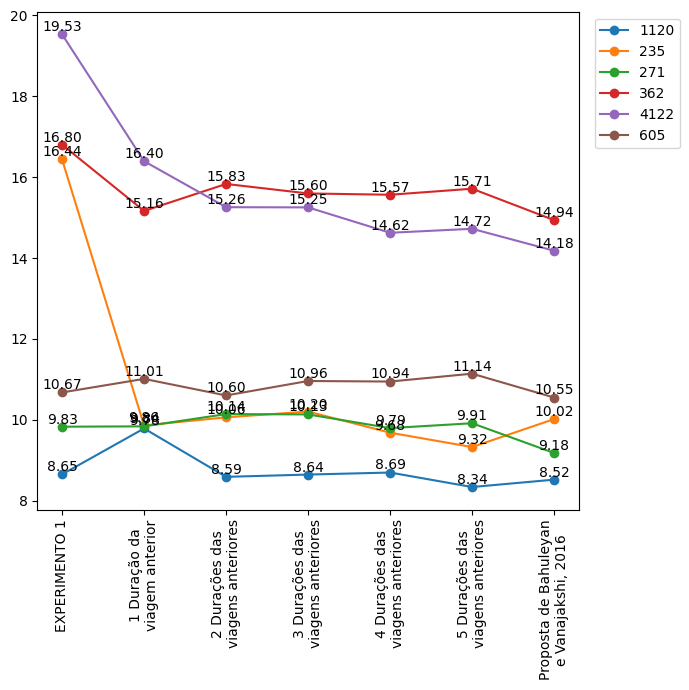

In [54]:
b = a[(a["Modelo"] == "XGBoost") & (a["Métrica"] == "MAPE") & (a["Teste"].str.contains("3 Tempo"))].sort_values("Teste", ascending=False)
d = a[(a["Modelo"] == "XGBoost") & (a["Métrica"] == "MAPE") & (a["Teste"] == "1 Teste de Colunas - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano']")]

b = pd.concat([d, b], ignore_index=False)


plt.figure(figsize=[7, 7])
for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["EXPERIMENTO 1", "1 Duração da\nviagem anterior", "2 Durações das\nviagens anteriores", "3 Durações das\nviagens anteriores", "4 Durações das\nviagens anteriores", "5 Durações das\nviagens anteriores", "Proposta de Bahuleyan\ne Vanajakshi, 2016"]
    c["Valor"] = c['Valor']*100
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format(c["Valor"].iloc[i])
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.xticks(rotation=90)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))

# plt.show()

plt.savefig("Results/resultados_tempos_anteriores_xgb.svg")
plt.savefig("Results/resultados_tempos_anteriores_xgb.png")


C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\538875316.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c["Teste"] = ["EXPERIMENTO 1", "1 Duração da\nviagem anterior", "2 Durações das\nviagens anteriores", "3 Durações das\nviagens anteriores", "4 Durações das\nviagens anteriores", "5 Durações das\nviagens anteriores", "Proposta de Bahuleyan\ne Vanajakshi, 2016"]
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\538875316.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['Valor'] = c["Valor"]

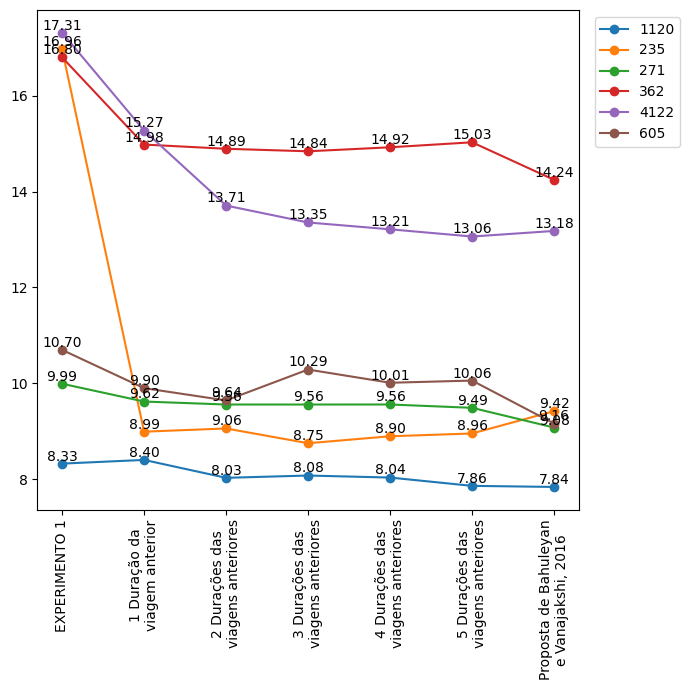

In [55]:
b = a[(a["Modelo"] == "Random Forest") & (a["Métrica"] == "MAPE") & (a["Teste"].str.contains("3 Tempo"))].sort_values("Teste", ascending=False)
d = a[(a["Modelo"] == "Random Forest") & (a["Métrica"] == "MAPE") & (a["Teste"] == "1 Teste de Colunas - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano']")]

b = pd.concat([d, b], ignore_index=False)


plt.figure(figsize=[7, 7])
for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["EXPERIMENTO 1", "1 Duração da\nviagem anterior", "2 Durações das\nviagens anteriores", "3 Durações das\nviagens anteriores", "4 Durações das\nviagens anteriores", "5 Durações das\nviagens anteriores", "Proposta de Bahuleyan\ne Vanajakshi, 2016"]
    c['Valor'] = c["Valor"]*100
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format(c["Valor"].iloc[i])
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.xticks(rotation=90)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
# plt.show()

plt.savefig("Results/resultados_tempos_anteriores_rf.svg")
plt.savefig("Results/resultados_tempos_anteriores_rf.png")

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1165244376.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c["Teste"] = ["EXPERIMENTO 1", "1 Duração da\nviagem anterior", "2 Durações das\nviagens anteriores", "3 Durações das\nviagens anteriores", "4 Durações das\nviagens anteriores", "5 Durações das\nviagens anteriores", "Proposta de Bahuleyan\ne Vanajakshi, 2016"]
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1165244376.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['Valor'] = c['Valor

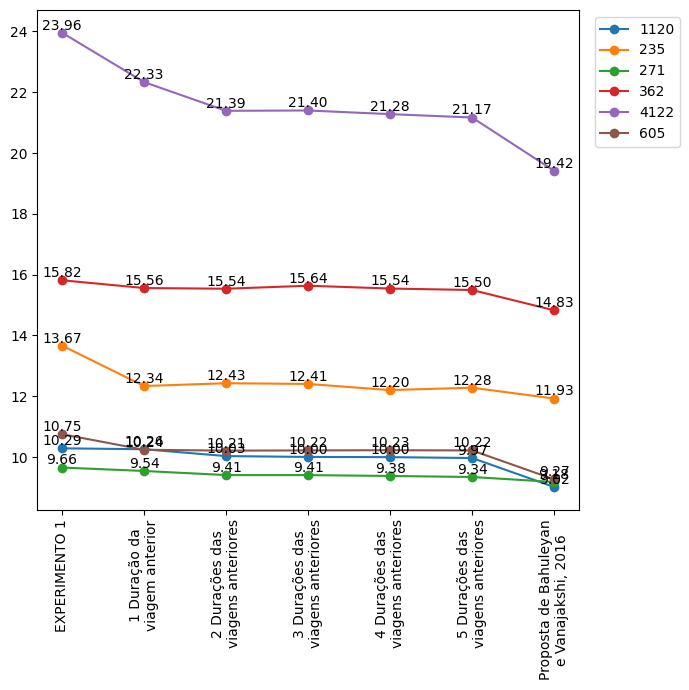

In [56]:
b = a[(a["Modelo"] == "Linear Regression") & (a["Métrica"] == "MAPE") & (a["Teste"].str.contains("3 Tempo"))].sort_values("Teste", ascending=False)
d = a[(a["Modelo"] == "Linear Regression") & (a["Métrica"] == "MAPE") & (a["Teste"] == "1 Teste de Colunas - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano']")]

b = pd.concat([d, b], ignore_index=False)


plt.figure(figsize=[7, 7])
for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["EXPERIMENTO 1", "1 Duração da\nviagem anterior", "2 Durações das\nviagens anteriores", "3 Durações das\nviagens anteriores", "4 Durações das\nviagens anteriores", "5 Durações das\nviagens anteriores", "Proposta de Bahuleyan\ne Vanajakshi, 2016"]
    c['Valor'] = c['Valor']*100
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format(c["Valor"].iloc[i])
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.xticks(rotation=90)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
# plt.show()

plt.savefig("Results/resultados_tempos_anteriores_lr.svg")
plt.savefig("Results/resultados_tempos_anteriores_lr.png")

# Teste com clima

## Tratando dados de clima

In [57]:
# Lendo os csv do Inmet e juntando os dois anos
clima2019 = pd.read_csv('INMET_S_SC_A806_FLORIANOPOLIS_01-01-2019_A_31-12-2019.CSV', sep=';', header=8, encoding='utf-8')
clima2018 = pd.read_csv('INMET_S_SC_A806_FLORIANOPOLIS_01-01-2018_A_31-12-2018.CSV', sep=';', header=8, encoding='utf-8')
clima2018.rename(columns = {'DATA (YYYY-MM-DD)': 'Data', 'HORA (UTC)':'Hora UTC'} ,inplace=True)
clima = pd.concat([clima2018,clima2019])
clima

Data  Hora UTC PRECIPITACAO TOTAL, HORARIO (mm)  \
0     2018-01-01     00:00                                0   
1     2018-01-01     01:00                                0   
2     2018-01-01     02:00                                0   
3     2018-01-01     03:00                                0   
4     2018-01-01     04:00                                0   
...          ...       ...                              ...   
8755  2019/12/31  1900 UTC                                0   
8756  2019/12/31  2000 UTC                                0   
8757  2019/12/31  2100 UTC                                0   
8758  2019/12/31  2200 UTC                                0   
8759  2019/12/31  2300 UTC                                0   

     PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  \
0                                                1009,5      
1                                                1010,2      
2                                                1010,7      
3                                                1010,5      
4                                                  1010      
...                                                 ...      
8755                                             1005,8      
8756                                             1005,7      
8757                                             1005,9      
8758                                             1006,4      
8759                                             1007,7      

     PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)  \
0                                             1009,5   
1                                             1010,2   
2                                             1010,7   
3                                             1010,7   
4                                             1010,5   
...                                              ...   
8755                                          1006,4   
8756                                            1006   
8757                                          1005,9   
8758                                          1006,4   
8759                                          1007,7   

     PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB) RADIACAO GLOBAL (KJ/m²)  \
0                                                1009                   -9999   
1                                              1009,5                   -9999   
2                                              1010,2                   -9999   
3                                              1010,5                   -9999   
4                                              1009,9                   -9999   
...                                               ...                     ...   
8755                                           1005,8                  2590,4   
8756                                           1005,6                  1864,7   
8757                                           1005,7                   772,7   
8758                                           1005,9                   164,2   
8759                                           1006,4                     1,4   

     TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)  \
0                                            24,7   
1                                            24,7   
2                                            24,4   
3                                            23,9   
4                                            23,8   
...                                           ...   
8755                                         29,3   
8756                                           28   
8757                                         27,2   
8758                                         26,2   
8759                                         26,3   

     TEMPERATURA DO PONTO DE ORVALHO (°C)  \
0                                    19,9   
1                                    19,9   
2                                    20,1   
3                                    20,5   
4 

In [58]:
#Convertendo a data e a hora em um datetime
clima['Datetime'] = pd.to_datetime(clima['Data']+' '+clima['Hora UTC'],utc=True)
clima['Datetime'] = clima['Datetime'].dt.tz_convert(pytz.timezone('America/Sao_Paulo'))
clima['Datetime'] = clima['Datetime'].dt.tz_localize(None)
clima

Data  Hora UTC PRECIPITACAO TOTAL, HORARIO (mm)  \
0     2018-01-01     00:00                                0   
1     2018-01-01     01:00                                0   
2     2018-01-01     02:00                                0   
3     2018-01-01     03:00                                0   
4     2018-01-01     04:00                                0   
...          ...       ...                              ...   
8755  2019/12/31  1900 UTC                                0   
8756  2019/12/31  2000 UTC                                0   
8757  2019/12/31  2100 UTC                                0   
8758  2019/12/31  2200 UTC                                0   
8759  2019/12/31  2300 UTC                                0   

     PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  \
0                                                1009,5      
1                                                1010,2      
2                                                1010,7      
3                                                1010,5      
4                                                  1010      
...                                                 ...      
8755                                             1005,8      
8756                                             1005,7      
8757                                             1005,9      
8758                                             1006,4      
8759                                             1007,7      

     PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)  \
0                                             1009,5   
1                                             1010,2   
2                                             1010,7   
3                                             1010,7   
4                                             1010,5   
...                                              ...   
8755                                          1006,4   
8756                                            1006   
8757                                          1005,9   
8758                                          1006,4   
8759                                          1007,7   

     PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB) RADIACAO GLOBAL (KJ/m²)  \
0                                                1009                   -9999   
1                                              1009,5                   -9999   
2                                              1010,2                   -9999   
3                                              1010,5                   -9999   
4                                              1009,9                   -9999   
...                                               ...                     ...   
8755                                           1005,8                  2590,4   
8756                                           1005,6                  1864,7   
8757                                           1005,7                   772,7   
8758                                           1005,9                   164,2   
8759                                           1006,4                     1,4   

     TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)  \
0                                            24,7   
1                                            24,7   
2                                            24,4   
3                                            23,9   
4                                            23,8   
...                                           ...   
8755                                         29,3   
8756                                           28   
8757                                         27,2   
8758                                         26,2   
8759                                         26,3   

     TEMPERATURA DO PONTO DE ORVALHO (°C)  \
0                                    19,9   
1                                    19,9   
2                                    20,1   
3                                    20,5   
4 

In [59]:
#Pegando apenas colunas com informações de data, precipitação e temperatudo. E o intervalo de tempo apenas dos nossos dados
clima = clima[['Datetime','PRECIPITACAO TOTAL, HORARIO (mm)','TEMPERATURA MAXIMA NA HORA ANT. (AUT) (°C)','TEMPERATURA MINIMA NA HORA ANT. (AUT) (°C)']]
clima = clima.loc[(clima['Datetime'] >= '2018-10-01') & (clima['Datetime'] <= '2019-11-30')].sort_values(by='Datetime')
clima

Datetime PRECIPITACAO TOTAL, HORARIO (mm)  \
6555 2018-10-01 00:00:00                                0   
6556 2018-10-01 01:00:00                                0   
6557 2018-10-01 02:00:00                                0   
6558 2018-10-01 03:00:00                                0   
6559 2018-10-01 04:00:00                                0   
...                  ...                              ...   
7991 2019-11-29 20:00:00                              NaN   
7992 2019-11-29 21:00:00                              NaN   
7993 2019-11-29 22:00:00                              NaN   
7994 2019-11-29 23:00:00                              NaN   
7995 2019-11-30 00:00:00                              NaN   

     TEMPERATURA MAXIMA NA HORA ANT. (AUT) (°C)  \
6555                                       23,3   
6556                                       23,3   
6557                                       22,9   
6558                                       22,9   
6559                                       22,7   
...                                         ...   
7991                                       22,8   
7992                                       22,5   
7993                                       21,9   
7994                                       20,8   
7995                                       21,4   

     TEMPERATURA MINIMA NA HORA ANT. (AUT) (°C)  
6555                                       23,2  
6556                                       22,6  
6557                                       22,5  
6558                                       22,7  
6559                                       22,4  
...                                         ...  
7991                                       22,4  
7992                                       21,9  
7993                                       20,6  
7994                                       20,6  
7995                                       20,8  

[10201 rows x 4 columns]

In [60]:
# Tirando a média das temperaturas mínima e máxima
clima["Temperatura Media"] = (clima["TEMPERATURA MAXIMA NA HORA ANT. (AUT) (°C)"].str.replace(",", ".").astype(float) + clima["TEMPERATURA MINIMA NA HORA ANT. (AUT) (°C)"].str.replace(",", ".").astype(float))/2

In [61]:
#Transformando a precipitação em um valor categorico - Usamos apenas 3 Sem, Fraco e Forte pois com mais categorias algumas ficavam pouco representativas
clima["PRECIPITACAO TOTAL, HORARIO (mm)"] = clima["PRECIPITACAO TOTAL, HORARIO (mm)"].str.replace(",", ".").astype(float)
clima['Chuva'] = clima['PRECIPITACAO TOTAL, HORARIO (mm)'].apply(lambda x: 1 if (x > 0) & (x <= 2.5) else \
2 if (x > 2.5) & (x <= 10) else \
3 if (x > 10) else 0)

In [62]:
#Transformando a Temperatura em um valor categorico - Usamos apenas 2 Frio ou Quente pois com mais categorias algumas ficavam pouco representativas
clima['Calor'] = clima['Temperatura Media'].apply(lambda x: 1 if (x > 16) & (x <= 25) else \
2 if (x > 25) else 0)

In [63]:
#Dropando as colunas desnecessárias
clima.drop(["TEMPERATURA MAXIMA NA HORA ANT. (AUT) (°C)", "TEMPERATURA MINIMA NA HORA ANT. (AUT) (°C)", "PRECIPITACAO TOTAL, HORARIO (mm)", "Temperatura Media"], axis=1, inplace=True)

In [64]:
clima

Datetime  Chuva  Calor
6555 2018-10-01 00:00:00      0      1
6556 2018-10-01 01:00:00      0      1
6557 2018-10-01 02:00:00      0      1
6558 2018-10-01 03:00:00      0      1
6559 2018-10-01 04:00:00      0      1
...                  ...    ...    ...
7991 2019-11-29 20:00:00      0      1
7992 2019-11-29 21:00:00      0      1
7993 2019-11-29 22:00:00      0      1
7994 2019-11-29 23:00:00      0      1
7995 2019-11-30 00:00:00      0      1

[10201 rows x 3 columns]

In [65]:
#Mudanças na data_partida para conseguir fazer o merge
df["Ini2"] = df["Ini"]
df["Ini2"] = df["Ini2"].dt.round("H")
#Merge dos dados e exclusão da coluna auxiliar
df = df.merge(clima, left_on="Ini2", right_on="Datetime", how="left")
df.drop(['Ini2','Datetime'],axis=1,inplace=True)
df

Sentido Linha  DuraçãoViagem  TotalGiros  KmPerc                 Ini  \
0            0  1120           3840          19  31.218 2018-11-14 06:11:00   
1            0  1120           4560          33  31.218 2018-11-14 06:44:00   
2            1  1120           3240           1  30.640 2018-11-14 07:18:00   
3            0  1120           4200          17  31.218 2018-11-14 08:12:00   
4            1  1120           3300           7  30.640 2018-11-14 08:13:00   
...        ...   ...            ...         ...     ...                 ...   
30463        0   605           3900          16  19.437 2019-10-31 12:51:00   
30464        0   605           3780          10  19.437 2019-10-31 13:39:00   
30465        0   605           3780          18  19.437 2019-10-31 15:57:00   
30466        0   605           4440          26  19.437 2019-10-31 16:58:00   
30467        0   605           2580           2  19.437 2019-10-31 19:54:00   

                      Fim  dia_semana  hora_dia  dia_ano  ...  TotalGirosMean  \
0     2018-11-14 07:15:00           3         6      318  ...            26.0   
1     2018-11-14 08:00:00           3         6      318  ...            26.0   
2     2018-11-14 08:12:00           3         7      318  ...             4.0   
3     2018-11-14 09:22:00           3         8      318  ...             8.5   
4     2018-11-14 09:08:00           3         8      318  ...             8.5   
...                   ...         ...       ...      ...  ...             ...   
30463 2019-10-31 13:56:00           4        12      304  ...            17.0   
30464 2019-10-31 14:42:00           4        13      304  ...             5.0   
30465 2019-10-31 17:00:00           4        15      304  ...            10.5   
30466 2019-10-31 18:12:00           4        16      304  ...            27.0   
30467 2019-10-31 20:37:00           4        19      304  ...             3.0   

       DuraçãoViagem_1  DuraçãoViagem_2  DuraçãoViagem_3  DuraçãoViagem_4  \
0               4260.0           4140.0           4740.0           5040.0   
1               3840.0           4260.0           4140.0           4740.0   
2               4560.0           3840.0           4260.0           4140.0   
3               3240.0           4560.0           3840.0           4260.0   
4               4200.0           3240.0           4560.0           3840.0   
...                ...              ...              ...              ...   
30463           3420.0           3360.0           3180.0           3300.0   
30464           3900.0           3420.0           3360.0           3180.0   
30465           3780.0           3900.0           3420.0           3360.0   
30466           3780.0           3780.0           3900.0           3420.0   
30467           4440.0           3780.0           3780.0           3900.0   

       DuraçãoViagem_5  DuraçãoViagemMean_d-1  DuraçãoViagemMean_d-7  Chuva  \
0               4380.0                 4290.0                 4050.0      0   
1               5040.0                 4290.0                 4050.0      0   
2               4740.0                 3480.0                 3720.0      0   
3               4140.0                 3930.0                 4170.0      0   
4               4260.0                 3930.0                 4170.0      0   
...                ...                    ...                    ...    ...   
30463           4620.0                 3780.0                 3780.0      0   
30464           3300.0                 3000.0                 3840.0      0   
30465           3180.0                 3330.0                 3720.0      0   
30466           3360.0                 3660.0                 3960.0      0   
30467           3420.0                 2760.0                 2700.0      0   

       Calor  
0          1  
1          1  
2          1  
3          1  
4          1  
...      ...  
30463      2  
30464      2  
30465      2  
30466      2  
30467      1  

[30468 rows x 22 columns]

## Executando Testes

In [66]:
df

Sentido Linha  DuraçãoViagem  TotalGiros  KmPerc                 Ini  \
0            0  1120           3840          19  31.218 2018-11-14 06:11:00   
1            0  1120           4560          33  31.218 2018-11-14 06:44:00   
2            1  1120           3240           1  30.640 2018-11-14 07:18:00   
3            0  1120           4200          17  31.218 2018-11-14 08:12:00   
4            1  1120           3300           7  30.640 2018-11-14 08:13:00   
...        ...   ...            ...         ...     ...                 ...   
30463        0   605           3900          16  19.437 2019-10-31 12:51:00   
30464        0   605           3780          10  19.437 2019-10-31 13:39:00   
30465        0   605           3780          18  19.437 2019-10-31 15:57:00   
30466        0   605           4440          26  19.437 2019-10-31 16:58:00   
30467        0   605           2580           2  19.437 2019-10-31 19:54:00   

                      Fim  dia_semana  hora_dia  dia_ano  ...  TotalGirosMean  \
0     2018-11-14 07:15:00           3         6      318  ...            26.0   
1     2018-11-14 08:00:00           3         6      318  ...            26.0   
2     2018-11-14 08:12:00           3         7      318  ...             4.0   
3     2018-11-14 09:22:00           3         8      318  ...             8.5   
4     2018-11-14 09:08:00           3         8      318  ...             8.5   
...                   ...         ...       ...      ...  ...             ...   
30463 2019-10-31 13:56:00           4        12      304  ...            17.0   
30464 2019-10-31 14:42:00           4        13      304  ...             5.0   
30465 2019-10-31 17:00:00           4        15      304  ...            10.5   
30466 2019-10-31 18:12:00           4        16      304  ...            27.0   
30467 2019-10-31 20:37:00           4        19      304  ...             3.0   

       DuraçãoViagem_1  DuraçãoViagem_2  DuraçãoViagem_3  DuraçãoViagem_4  \
0               4260.0           4140.0           4740.0           5040.0   
1               3840.0           4260.0           4140.0           4740.0   
2               4560.0           3840.0           4260.0           4140.0   
3               3240.0           4560.0           3840.0           4260.0   
4               4200.0           3240.0           4560.0           3840.0   
...                ...              ...              ...              ...   
30463           3420.0           3360.0           3180.0           3300.0   
30464           3900.0           3420.0           3360.0           3180.0   
30465           3780.0           3900.0           3420.0           3360.0   
30466           3780.0           3780.0           3900.0           3420.0   
30467           4440.0           3780.0           3780.0           3900.0   

       DuraçãoViagem_5  DuraçãoViagemMean_d-1  DuraçãoViagemMean_d-7  Chuva  \
0               4380.0                 4290.0                 4050.0      0   
1               5040.0                 4290.0                 4050.0      0   
2               4740.0                 3480.0                 3720.0      0   
3               4140.0                 3930.0                 4170.0      0   
4               4260.0                 3930.0                 4170.0      0   
...                ...                    ...                    ...    ...   
30463           4620.0                 3780.0                 3780.0      0   
30464           3300.0                 3000.0                 3840.0      0   
30465           3180.0                 3330.0                 3720.0      0   
30466           3360.0                 3660.0                 3960.0      0   
30467           3420.0                 2760.0                 2700.0      0   

       Calor  
0          1  
1          1  
2          1  
3          1  
4          1  
...      ...  
30463      2  
30464      2  
30465      2  
30466      2  
30467      1  

[30468 rows x 22 columns]

In [67]:
Colunas = [
    ['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva','Calor'],
    ['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva'],
    ['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Calor'],
]
TestesNome = [
    "2 - Teste clima - ['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva','Calor']",
    "2 - Teste clima - ['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva']",
    "2 - Teste clima - ['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Calor']",
]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    shape = int(df_modelo.shape[0] * 0.3)
    df_teste = df_modelo[:shape]
    df_treino = df_modelo[shape:]
    for i in range(len(TestesNome)):
        teste_nome = TestesNome[i]
        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[Colunas[i]]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[Colunas[i]]
        y_treino = df_treino["DuraçãoViagem"]

        fi_xgb, fi_rf = cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)
        fi_xgb["rota"], fi_rf["rota"] = rota, rota
        fi_xgb["modelo"], fi_rf["modelo"] = "XGB", "RF"

        importance = pd.concat([importance, fi_xgb, fi_rf])


[0]	validation_0-rmse:2755.42712
[1]	validation_0-rmse:1954.17543
[2]	validation_0-rmse:1400.49984
[3]	validation_0-rmse:1022.62366
[4]	validation_0-rmse:768.37481
[5]	validation_0-rmse:597.79547
[6]	validation_0-rmse:488.10691
[7]	validation_0-rmse:421.65610
[8]	validation_0-rmse:376.86901
[9]	validation_0-rmse:354.32379
[10]	validation_0-rmse:332.88496
[11]	validation_0-rmse:322.91067
[12]	validation_0-rmse:316.58155
[13]	validation_0-rmse:313.81900
[14]	validation_0-rmse:307.00834
[15]	validation_0-rmse:299.98304
[16]	validation_0-rmse:295.02714
[17]	validation_0-rmse:285.84539
[18]	validation_0-rmse:283.26555
[19]	validation_0-rmse:278.56230
[20]	validation_0-rmse:277.03124
[21]	validation_0-rmse:268.76867
[22]	validation_0-rmse:264.37966
[23]	validation_0-rmse:258.70959
[24]	validation_0-rmse:254.76664
[25]	validation_0-rmse:251.12479
[26]	validation_0-rmse:246.36065
[27]	validation_0-rmse:245.22090
[28]	validation_0-rmse:240.69650
[29]	validation_0-rmse:237.82641
[30]	validation_

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[25]	validation_0-rmse:269.82217
[26]	validation_0-rmse:266.39608
[27]	validation_0-rmse:262.06457
[28]	validation_0-rmse:257.56037
[29]	validation_0-rmse:253.77265
[30]	validation_0-rmse:251.65383
[31]	validation_0-rmse:250.04687
[32]	validation_0-rmse:249.12377
[33]	validation_0-rmse:244.74553
[34]	validation_0-rmse:240.80951
[35]	validation_0-rmse:236.59276
[36]	validation_0-rmse:231.91186
[37]	validation_0-rmse:228.85146
[38]	validation_0-rmse:225.37159
[39]	validation_0-rmse:221.41453
[40]	validation_0-rmse:219.48917
[41]	validation_0-rmse:215.42117
[42]	validation_0-rmse:213.26770
[43]	validation_0-rmse:211.50629
[44]	validation_0-rmse:208.46017
[45]	validation_0-rmse:206.40338
[46]	validation_0-rmse:204.62924
[47]	validation_0-rmse:201.47237
[48]	validation_0-rmse:199.77346
[49]	validation_0-rmse:198.24298
[50]	validation_0-rmse:196.30797
[51]	validation_0-rmse:193.72135
[52]	validation_0-rmse:192.68331
[53]	validation_0-rmse:189.76597
[54]	validation_0-rmse:185.87059
[55]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[28]	validation_0-rmse:253.54073
[29]	validation_0-rmse:252.52137
[30]	validation_0-rmse:249.15111
[31]	validation_0-rmse:241.47570
[32]	validation_0-rmse:239.81866
[33]	validation_0-rmse:236.49824
[34]	validation_0-rmse:230.02777
[35]	validation_0-rmse:226.87869
[36]	validation_0-rmse:224.81855
[37]	validation_0-rmse:221.42418
[38]	validation_0-rmse:220.14830
[39]	validation_0-rmse:216.58334
[40]	validation_0-rmse:212.96818
[41]	validation_0-rmse:210.76082
[42]	validation_0-rmse:208.70502
[43]	validation_0-rmse:205.32926
[44]	validation_0-rmse:202.40237
[45]	validation_0-rmse:199.91854
[46]	validation_0-rmse:199.50480
[47]	validation_0-rmse:197.42974
[48]	validation_0-rmse:194.58635
[49]	validation_0-rmse:193.64813
[50]	validation_0-rmse:190.37070
[51]	validation_0-rmse:189.64291
[52]	validation_0-rmse:189.42262
[53]	validation_0-rmse:188.45842
[54]	validation_0-rmse:185.79976
[55]	validation_0-rmse:183.32045
[56]	validation_0-rmse:180.32077
[57]	validation_0-rmse:178.22225
[58]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[23]	validation_0-rmse:213.31958
[24]	validation_0-rmse:209.10493
[25]	validation_0-rmse:207.49825
[26]	validation_0-rmse:206.96806
[27]	validation_0-rmse:203.40582
[28]	validation_0-rmse:200.65152
[29]	validation_0-rmse:198.41530
[30]	validation_0-rmse:196.40496
[31]	validation_0-rmse:195.81934
[32]	validation_0-rmse:193.84311
[33]	validation_0-rmse:192.72716
[34]	validation_0-rmse:192.12277
[35]	validation_0-rmse:191.88048
[36]	validation_0-rmse:189.17236
[37]	validation_0-rmse:185.90708
[38]	validation_0-rmse:184.94622
[39]	validation_0-rmse:182.93895
[40]	validation_0-rmse:180.77452
[41]	validation_0-rmse:179.66643
[42]	validation_0-rmse:177.74825
[43]	validation_0-rmse:177.18440
[44]	validation_0-rmse:175.70066
[45]	validation_0-rmse:173.68814
[46]	validation_0-rmse:171.10401
[47]	validation_0-rmse:170.22015
[48]	validation_0-rmse:168.41432
[49]	validation_0-rmse:167.15170
[50]	validation_0-rmse:166.37888
[51]	validation_0-rmse:165.06255
[52]	validation_0-rmse:164.30411
[53]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1942.42394
[1]	validation_0-rmse:1388.89250
[2]	validation_0-rmse:1007.79914
[3]	validation_0-rmse:744.03401
[4]	validation_0-rmse:566.55524
[5]	validation_0-rmse:451.93009
[6]	validation_0-rmse:375.92134
[7]	validation_0-rmse:330.37976
[8]	validation_0-rmse:304.00754
[9]	validation_0-rmse:284.17394
[10]	validation_0-rmse:272.79453
[11]	validation_0-rmse:264.94986
[12]	validation_0-rmse:260.55151
[13]	validation_0-rmse:251.00936
[14]	validation_0-rmse:243.38845
[15]	validation_0-rmse:241.70749
[16]	validation_0-rmse:237.11569
[17]	validation_0-rmse:233.69327
[18]	validation_0-rmse:232.06257
[19]	validation_0-rmse:230.58699
[20]	validation_0-rmse:226.58547
[21]	validation_0-rmse:223.37833
[22]	validation_0-rmse:221.16937
[23]	validation_0-rmse:219.08084
[24]	validation_0-rmse:216.96221
[25]	validation_0-rmse:215.89617
[26]	validation_0-rmse:215.12565
[27]	validation_0-rmse:211.22254
[28]	validation_0-rmse:210.60459
[29]	validation_0-rmse:209.24615
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[18]	validation_0-rmse:226.38529
[19]	validation_0-rmse:224.84389
[20]	validation_0-rmse:222.24574
[21]	validation_0-rmse:220.04176
[22]	validation_0-rmse:219.05050
[23]	validation_0-rmse:217.77546
[24]	validation_0-rmse:213.58002
[25]	validation_0-rmse:209.66112
[26]	validation_0-rmse:209.21261
[27]	validation_0-rmse:205.96766
[28]	validation_0-rmse:203.24064
[29]	validation_0-rmse:201.12602
[30]	validation_0-rmse:199.02636
[31]	validation_0-rmse:198.37629
[32]	validation_0-rmse:198.02944
[33]	validation_0-rmse:196.64442
[34]	validation_0-rmse:193.86768
[35]	validation_0-rmse:191.15692
[36]	validation_0-rmse:190.86860
[37]	validation_0-rmse:189.24378
[38]	validation_0-rmse:187.08270
[39]	validation_0-rmse:183.68933
[40]	validation_0-rmse:182.36568
[41]	validation_0-rmse:179.69433
[42]	validation_0-rmse:179.33407
[43]	validation_0-rmse:177.03514
[44]	validation_0-rmse:173.88224
[45]	validation_0-rmse:171.17947
[46]	validation_0-rmse:170.70823
[47]	validation_0-rmse:170.51307
[48]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[10]	validation_0-rmse:154.45018
[11]	validation_0-rmse:152.50815
[12]	validation_0-rmse:151.19366
[13]	validation_0-rmse:149.54490
[14]	validation_0-rmse:148.80075
[15]	validation_0-rmse:147.87686
[16]	validation_0-rmse:147.21804
[17]	validation_0-rmse:146.74134
[18]	validation_0-rmse:145.99620
[19]	validation_0-rmse:144.72992
[20]	validation_0-rmse:144.26309
[21]	validation_0-rmse:143.96383
[22]	validation_0-rmse:142.07030
[23]	validation_0-rmse:141.38833
[24]	validation_0-rmse:140.27783
[25]	validation_0-rmse:139.25037
[26]	validation_0-rmse:138.59159
[27]	validation_0-rmse:138.05890
[28]	validation_0-rmse:137.20659
[29]	validation_0-rmse:136.54648
[30]	validation_0-rmse:135.93528
[31]	validation_0-rmse:135.25788
[32]	validation_0-rmse:135.01303
[33]	validation_0-rmse:134.80640
[34]	validation_0-rmse:134.34836
[35]	validation_0-rmse:133.82452
[36]	validation_0-rmse:133.40433
[37]	validation_0-rmse:132.81044
[38]	validation_0-rmse:131.97293
[39]	validation_0-rmse:131.66961
[40]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1014.01557
[1]	validation_0-rmse:720.81665
[2]	validation_0-rmse:519.04733
[3]	validation_0-rmse:382.07381
[4]	validation_0-rmse:291.41146
[5]	validation_0-rmse:234.12892
[6]	validation_0-rmse:199.20813
[7]	validation_0-rmse:178.84192
[8]	validation_0-rmse:167.60242
[9]	validation_0-rmse:161.54436
[10]	validation_0-rmse:157.97473
[11]	validation_0-rmse:154.40184
[12]	validation_0-rmse:153.22922
[13]	validation_0-rmse:150.97306
[14]	validation_0-rmse:150.01135
[15]	validation_0-rmse:149.21181
[16]	validation_0-rmse:148.18557
[17]	validation_0-rmse:147.72617
[18]	validation_0-rmse:146.56054
[19]	validation_0-rmse:145.82389
[20]	validation_0-rmse:144.36408
[21]	validation_0-rmse:143.16366
[22]	validation_0-rmse:142.57409
[23]	validation_0-rmse:141.64789
[24]	validation_0-rmse:141.26856
[25]	validation_0-rmse:140.84828
[26]	validation_0-rmse:139.70023
[27]	validation_0-rmse:139.51114
[28]	validation_0-rmse:138.73759
[29]	validation_0-rmse:138.19222
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1014.01557
[1]	validation_0-rmse:720.80701
[2]	validation_0-rmse:518.94292
[3]	validation_0-rmse:382.08107
[4]	validation_0-rmse:291.79593
[5]	validation_0-rmse:234.25300
[6]	validation_0-rmse:198.89334
[7]	validation_0-rmse:178.74172
[8]	validation_0-rmse:165.93235
[9]	validation_0-rmse:157.93669
[10]	validation_0-rmse:154.42325
[11]	validation_0-rmse:152.25360
[12]	validation_0-rmse:150.74514
[13]	validation_0-rmse:148.64997
[14]	validation_0-rmse:147.45291
[15]	validation_0-rmse:146.30091
[16]	validation_0-rmse:145.00334
[17]	validation_0-rmse:144.59344
[18]	validation_0-rmse:143.82688
[19]	validation_0-rmse:142.74945
[20]	validation_0-rmse:142.17433
[21]	validation_0-rmse:141.80907
[22]	validation_0-rmse:140.52725
[23]	validation_0-rmse:139.47086
[24]	validation_0-rmse:138.81896
[25]	validation_0-rmse:138.56594
[26]	validation_0-rmse:137.71862
[27]	validation_0-rmse:137.02967
[28]	validation_0-rmse:135.89348
[29]	validation_0-rmse:135.16733
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:603.66274
[1]	validation_0-rmse:436.08775
[2]	validation_0-rmse:322.81133
[3]	validation_0-rmse:247.97557
[4]	validation_0-rmse:200.25298
[5]	validation_0-rmse:170.84770
[6]	validation_0-rmse:153.31310
[7]	validation_0-rmse:143.22670
[8]	validation_0-rmse:136.97148
[9]	validation_0-rmse:132.66324
[10]	validation_0-rmse:130.92365
[11]	validation_0-rmse:129.00332
[12]	validation_0-rmse:127.05205
[13]	validation_0-rmse:125.28595
[14]	validation_0-rmse:124.03389
[15]	validation_0-rmse:123.56304
[16]	validation_0-rmse:122.35251
[17]	validation_0-rmse:121.04388
[18]	validation_0-rmse:120.03553
[19]	validation_0-rmse:119.55992
[20]	validation_0-rmse:118.43172
[21]	validation_0-rmse:117.54089
[22]	validation_0-rmse:116.68294
[23]	validation_0-rmse:115.59801
[24]	validation_0-rmse:114.47684
[25]	validation_0-rmse:113.66913
[26]	validation_0-rmse:113.35512
[27]	validation_0-rmse:112.55792
[28]	validation_0-rmse:112.17924
[29]	validation_0-rmse:110.60647
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:603.66274
[1]	validation_0-rmse:436.09922
[2]	validation_0-rmse:322.81927
[3]	validation_0-rmse:248.01562
[4]	validation_0-rmse:200.43832
[5]	validation_0-rmse:171.25622
[6]	validation_0-rmse:153.93371
[7]	validation_0-rmse:143.48931
[8]	validation_0-rmse:136.95873
[9]	validation_0-rmse:133.33795
[10]	validation_0-rmse:130.87683
[11]	validation_0-rmse:129.22608
[12]	validation_0-rmse:128.28940
[13]	validation_0-rmse:127.69526
[14]	validation_0-rmse:125.85029
[15]	validation_0-rmse:123.64210
[16]	validation_0-rmse:123.13636
[17]	validation_0-rmse:122.02349
[18]	validation_0-rmse:120.84220
[19]	validation_0-rmse:119.62112
[20]	validation_0-rmse:118.57658
[21]	validation_0-rmse:118.11065
[22]	validation_0-rmse:116.86566
[23]	validation_0-rmse:116.05312
[24]	validation_0-rmse:114.61577
[25]	validation_0-rmse:113.59805
[26]	validation_0-rmse:113.28203
[27]	validation_0-rmse:112.96293
[28]	validation_0-rmse:111.60506
[29]	validation_0-rmse:110.74311
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:603.66274
[1]	validation_0-rmse:436.08775
[2]	validation_0-rmse:322.82874
[3]	validation_0-rmse:248.18136
[4]	validation_0-rmse:200.48621
[5]	validation_0-rmse:171.27285
[6]	validation_0-rmse:153.29180
[7]	validation_0-rmse:142.04172
[8]	validation_0-rmse:135.72747
[9]	validation_0-rmse:131.89782
[10]	validation_0-rmse:129.25712
[11]	validation_0-rmse:127.64817
[12]	validation_0-rmse:126.25959
[13]	validation_0-rmse:125.38299
[14]	validation_0-rmse:124.04959
[15]	validation_0-rmse:122.63504
[16]	validation_0-rmse:121.47786
[17]	validation_0-rmse:120.96263
[18]	validation_0-rmse:118.73270
[19]	validation_0-rmse:117.82548
[20]	validation_0-rmse:116.38478
[21]	validation_0-rmse:115.36651
[22]	validation_0-rmse:114.51719
[23]	validation_0-rmse:113.74439
[24]	validation_0-rmse:112.73321
[25]	validation_0-rmse:112.26633
[26]	validation_0-rmse:111.01464
[27]	validation_0-rmse:110.21884
[28]	validation_0-rmse:109.41344
[29]	validation_0-rmse:108.45914
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2253.80274
[1]	validation_0-rmse:1620.04456
[2]	validation_0-rmse:1183.81105
[3]	validation_0-rmse:887.33645
[4]	validation_0-rmse:689.72147
[5]	validation_0-rmse:559.79991
[6]	validation_0-rmse:481.97355
[7]	validation_0-rmse:429.09351
[8]	validation_0-rmse:400.31803
[9]	validation_0-rmse:374.45600
[10]	validation_0-rmse:360.42438
[11]	validation_0-rmse:349.53121
[12]	validation_0-rmse:336.84564
[13]	validation_0-rmse:325.69972
[14]	validation_0-rmse:322.32593
[15]	validation_0-rmse:313.25477
[16]	validation_0-rmse:307.05381
[17]	validation_0-rmse:302.35954
[18]	validation_0-rmse:299.65659
[19]	validation_0-rmse:295.34096
[20]	validation_0-rmse:289.96442
[21]	validation_0-rmse:284.72490
[22]	validation_0-rmse:277.23978
[23]	validation_0-rmse:271.67371
[24]	validation_0-rmse:269.67334
[25]	validation_0-rmse:264.91631
[26]	validation_0-rmse:259.17357
[27]	validation_0-rmse:257.28044
[28]	validation_0-rmse:253.47072
[29]	validation_0-rmse:248.85384
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[26]	validation_0-rmse:263.58124
[27]	validation_0-rmse:259.85889
[28]	validation_0-rmse:256.76532
[29]	validation_0-rmse:253.75596
[30]	validation_0-rmse:251.74837
[31]	validation_0-rmse:245.40791
[32]	validation_0-rmse:242.50499
[33]	validation_0-rmse:238.55014
[34]	validation_0-rmse:232.10787
[35]	validation_0-rmse:228.49441
[36]	validation_0-rmse:227.08876
[37]	validation_0-rmse:222.51258
[38]	validation_0-rmse:218.41669
[39]	validation_0-rmse:215.69592
[40]	validation_0-rmse:214.50103
[41]	validation_0-rmse:211.25646
[42]	validation_0-rmse:207.30356
[43]	validation_0-rmse:202.57444
[44]	validation_0-rmse:198.07364
[45]	validation_0-rmse:196.48528
[46]	validation_0-rmse:191.20197
[47]	validation_0-rmse:189.21789
[48]	validation_0-rmse:186.15399
[49]	validation_0-rmse:185.06842
[50]	validation_0-rmse:184.75071
[51]	validation_0-rmse:182.49627
[52]	validation_0-rmse:180.91034
[53]	validation_0-rmse:179.60093
[54]	validation_0-rmse:178.07790
[55]	validation_0-rmse:174.54396
[56]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[37]	validation_0-rmse:226.93598
[38]	validation_0-rmse:224.66784
[39]	validation_0-rmse:221.05507
[40]	validation_0-rmse:216.96452
[41]	validation_0-rmse:215.59999
[42]	validation_0-rmse:213.60314
[43]	validation_0-rmse:209.68920
[44]	validation_0-rmse:207.17395
[45]	validation_0-rmse:202.64530
[46]	validation_0-rmse:200.96155
[47]	validation_0-rmse:199.34797
[48]	validation_0-rmse:194.82663
[49]	validation_0-rmse:192.53672
[50]	validation_0-rmse:188.27371
[51]	validation_0-rmse:184.18907
[52]	validation_0-rmse:181.11146
[53]	validation_0-rmse:177.60745
[54]	validation_0-rmse:175.30192
[55]	validation_0-rmse:170.39920
[56]	validation_0-rmse:167.95246
[57]	validation_0-rmse:166.72061
[58]	validation_0-rmse:166.12200
[59]	validation_0-rmse:164.21474
[60]	validation_0-rmse:162.27790
[61]	validation_0-rmse:159.24510
[62]	validation_0-rmse:158.05823
[63]	validation_0-rmse:154.69129
[64]	validation_0-rmse:151.88238
[65]	validation_0-rmse:149.24602
[66]	validation_0-rmse:145.11331
[67]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[26]	validation_0-rmse:182.17839
[27]	validation_0-rmse:178.47527
[28]	validation_0-rmse:177.26375
[29]	validation_0-rmse:174.39071
[30]	validation_0-rmse:169.92817
[31]	validation_0-rmse:165.57206
[32]	validation_0-rmse:164.36040
[33]	validation_0-rmse:161.62143
[34]	validation_0-rmse:157.16522
[35]	validation_0-rmse:155.51859
[36]	validation_0-rmse:152.66538
[37]	validation_0-rmse:152.03828
[38]	validation_0-rmse:150.33422
[39]	validation_0-rmse:146.78271
[40]	validation_0-rmse:142.40633
[41]	validation_0-rmse:139.28009
[42]	validation_0-rmse:138.17805
[43]	validation_0-rmse:135.70448
[44]	validation_0-rmse:134.62907
[45]	validation_0-rmse:134.32164
[46]	validation_0-rmse:131.55674
[47]	validation_0-rmse:128.54748
[48]	validation_0-rmse:125.93833
[49]	validation_0-rmse:124.89331
[50]	validation_0-rmse:121.81758
[51]	validation_0-rmse:121.27830
[52]	validation_0-rmse:118.52165
[53]	validation_0-rmse:117.62173
[54]	validation_0-rmse:116.95942
[55]	validation_0-rmse:115.61053
[56]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[50]	validation_0-rmse:126.88595
[51]	validation_0-rmse:124.43704
[52]	validation_0-rmse:121.50547
[53]	validation_0-rmse:120.99189
[54]	validation_0-rmse:119.44984
[55]	validation_0-rmse:116.75573
[56]	validation_0-rmse:114.29780
[57]	validation_0-rmse:112.15058
[58]	validation_0-rmse:111.15116
[59]	validation_0-rmse:109.58494
[60]	validation_0-rmse:109.09594
[61]	validation_0-rmse:106.72955
[62]	validation_0-rmse:105.67438
[63]	validation_0-rmse:105.43341
[64]	validation_0-rmse:102.98631
[65]	validation_0-rmse:99.68817
[66]	validation_0-rmse:97.58486
[67]	validation_0-rmse:95.22841
[68]	validation_0-rmse:94.84111
[69]	validation_0-rmse:93.71971
[70]	validation_0-rmse:92.85789
[71]	validation_0-rmse:90.96036
[72]	validation_0-rmse:90.55949
[73]	validation_0-rmse:89.57701
[74]	validation_0-rmse:87.44453
[75]	validation_0-rmse:86.66579
[76]	validation_0-rmse:83.96931
[77]	validation_0-rmse:83.01490
[78]	validation_0-rmse:82.38578
[79]	validation_0-rmse:81.82580
[80]	validation_0-rmse:80

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[53]	validation_0-rmse:118.14195
[54]	validation_0-rmse:116.42264
[55]	validation_0-rmse:115.62862
[56]	validation_0-rmse:114.90682
[57]	validation_0-rmse:114.41900
[58]	validation_0-rmse:113.23242
[59]	validation_0-rmse:112.85548
[60]	validation_0-rmse:111.24027
[61]	validation_0-rmse:109.27775
[62]	validation_0-rmse:107.97265
[63]	validation_0-rmse:105.43169
[64]	validation_0-rmse:104.09942
[65]	validation_0-rmse:103.48108
[66]	validation_0-rmse:102.55376
[67]	validation_0-rmse:100.77416
[68]	validation_0-rmse:99.59125
[69]	validation_0-rmse:99.37136
[70]	validation_0-rmse:96.05968
[71]	validation_0-rmse:94.11024
[72]	validation_0-rmse:92.35684
[73]	validation_0-rmse:91.37770
[74]	validation_0-rmse:89.31069
[75]	validation_0-rmse:87.84723
[76]	validation_0-rmse:85.33948
[77]	validation_0-rmse:84.92356
[78]	validation_0-rmse:84.15001
[79]	validation_0-rmse:82.95024
[80]	validation_0-rmse:80.62362
[81]	validation_0-rmse:80.38606
[82]	validation_0-rmse:79.96961
[83]	validation_0-rmse:79

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [68]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[a['Métrica'] == 'RMSE'].sort_values(by='Valor')

Teste Rota  \
458  2 - Teste clima - ['Sentido','KmPerc','TotalGi...  362   
464  2 - Teste clima - ['Sentido','KmPerc','TotalGi...  362   
452  2 - Teste clima - ['Sentido','KmPerc','TotalGi...  362   
290  3 Tempos Anterios - ['Sentido','KmPerc','Total...  362   
460  2 - Teste clima - ['Sentido','KmPerc','TotalGi...  362   
..                                                 ...  ...   
82   1 Teste de Colunas - ['dia_semana','hora_dia',...  235   
78   1 Teste de Colunas - ['dia_semana','hora_dia',...  235   
80   1 Teste de Colunas - ['dia_semana','hora_dia',...  235   
72   1 Teste de Colunas - ['TotalGirosMean','dia_se...  235   
74   1 Teste de Colunas - ['TotalGirosMean','dia_se...  235   

                Modelo Métrica       Valor  Tempo de treino  Tempo de previsão  
458      Random Forest    RMSE  153.640045         1.283419            0.49921  
464      Random Forest    RMSE  154.665380         1.299784            0.49945  
452      Random Forest    RMSE  154.714040         1.350123            0.66561  
290      Random Forest    RMSE  154.736564         1.234648            0.49966  
460  Linear Regression    RMSE  157.322328         0.000000            0.00000  
..                 ...     ...         ...              ...                ...  
82   Linear Regression    RMSE  861.481548         0.000000            0.00000  
78             XGBoost    RMSE  866.977726         0.148816            0.00000  
80       Random Forest    RMSE  924.675431         0.334386            0.16638  
72             XGBoost    RMSE  925.408234         0.161994            0.10360  
74       Random Forest    RMSE  928.428263         0.400950            0.16640  

[252 rows x 7 columns]

C:\Users\Thiago\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


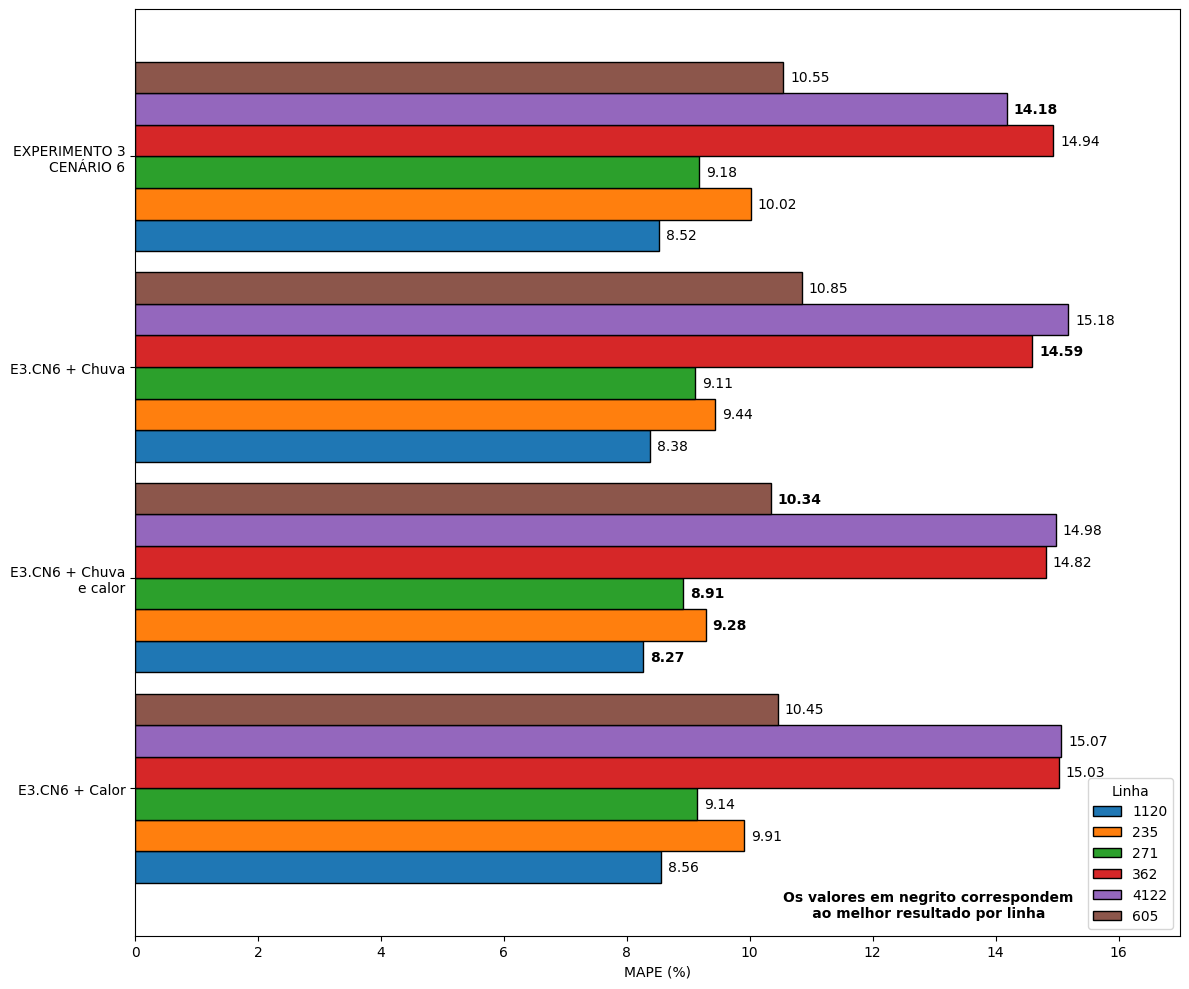

In [69]:
b = a[(a["Métrica"] == "MAPE") & (a["Modelo"] == "XGBoost")  & (a["Teste"].str.contains("2 - Teste"))]
d = a[(a["Métrica"] == "MAPE") & (a["Modelo"] == "XGBoost")  & (a["Teste"] == "3 Tempos Anterios - ['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7']")]
b = pd.concat([d, b], ignore_index=True)

b["Valor"] = b["Valor"] * 100

df_pivot = b.pivot(index='Teste', columns='Rota', values='Valor').sort_values("Teste")
df_pivot.index = ["E3.CN6 + Calor", "E3.CN6 + Chuva\ne calor", "E3.CN6 + Chuva", "EXPERIMENTO 3\nCENÁRIO 6"]

plt.rcParams["figure.autolayout"] = True

ax = df_pivot.plot(kind='barh', width = 0.9, figsize=[12, 10], edgecolor="black")

min_linha = b.groupby("Rota").agg({"Valor": "min"})["Valor"].unique()

for p in ax.patches:
    value = p.get_width()
    value_f = "{:.2f}".format(value)
    if value in min_linha:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontweight='bold')
    else:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.xlabel("MAPE (%)")
plt.xlim(0, 17)

ax.legend(title="Linha", loc="lower right")
ax.text(0.62, 0.02, "Os valores em negrito correspondem\n      ao melhor resultado por linha", transform=ax.transAxes, fontsize=10, color="black", fontweight="bold")

plt.savefig("Results/resultados_clima_xgb.svg")
plt.savefig("Results/resultados_clima_xgb.png")


C:\Users\Thiago\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


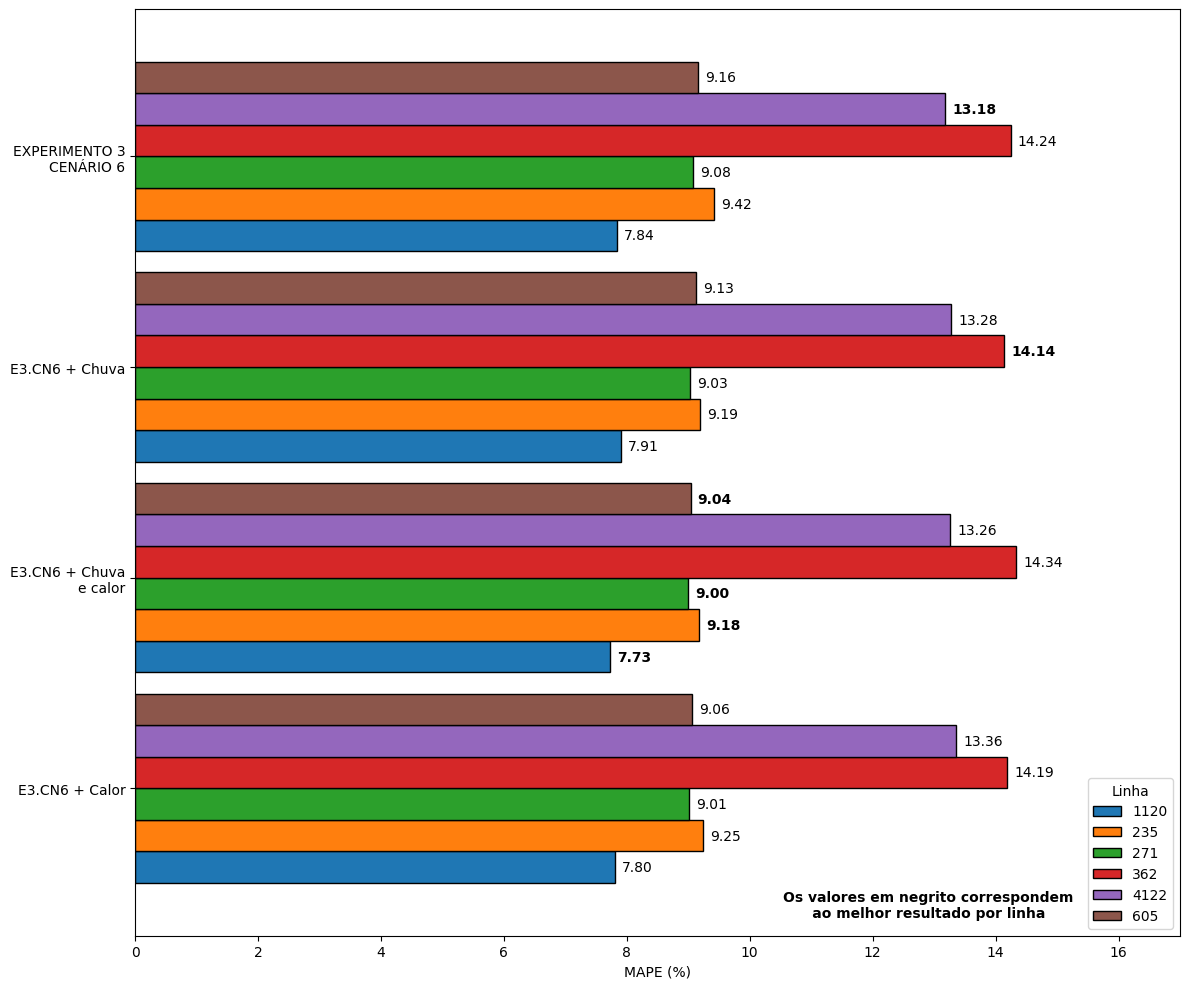

In [70]:
b = a[(a["Métrica"] == "MAPE") & (a["Modelo"] == "Random Forest")  & (a["Teste"].str.contains("2 - Teste"))]
d = a[(a["Métrica"] == "MAPE") & (a["Modelo"] == "Random Forest")  & (a["Teste"] == "3 Tempos Anterios - ['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7']")]
b = pd.concat([d, b], ignore_index=True)

b["Valor"] = b["Valor"] * 100

df_pivot = b.pivot(index='Teste', columns='Rota', values='Valor').sort_values("Teste")
df_pivot.index = ["E3.CN6 + Calor", "E3.CN6 + Chuva\ne calor", "E3.CN6 + Chuva", "EXPERIMENTO 3\nCENÁRIO 6"]

plt.rcParams["figure.autolayout"] = True

ax = df_pivot.plot(kind='barh', width = 0.9, figsize=[12, 10], edgecolor="black")

min_linha = b.groupby("Rota").agg({"Valor": "min"})["Valor"].unique()

for p in ax.patches:
    value = p.get_width()
    value_f = "{:.2f}".format(value)
    if value in min_linha:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontweight='bold')
    else:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.xlabel("MAPE (%)")
plt.xlim(0, 17)

ax.legend(title="Linha", loc="lower right")
ax.text(0.62, 0.02, "Os valores em negrito correspondem\n      ao melhor resultado por linha", transform=ax.transAxes, fontsize=10, color="black", fontweight="bold")

plt.savefig("Results/resultados_clima_rf.svg")
plt.savefig("Results/resultados_clima_rf.png")


C:\Users\Thiago\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


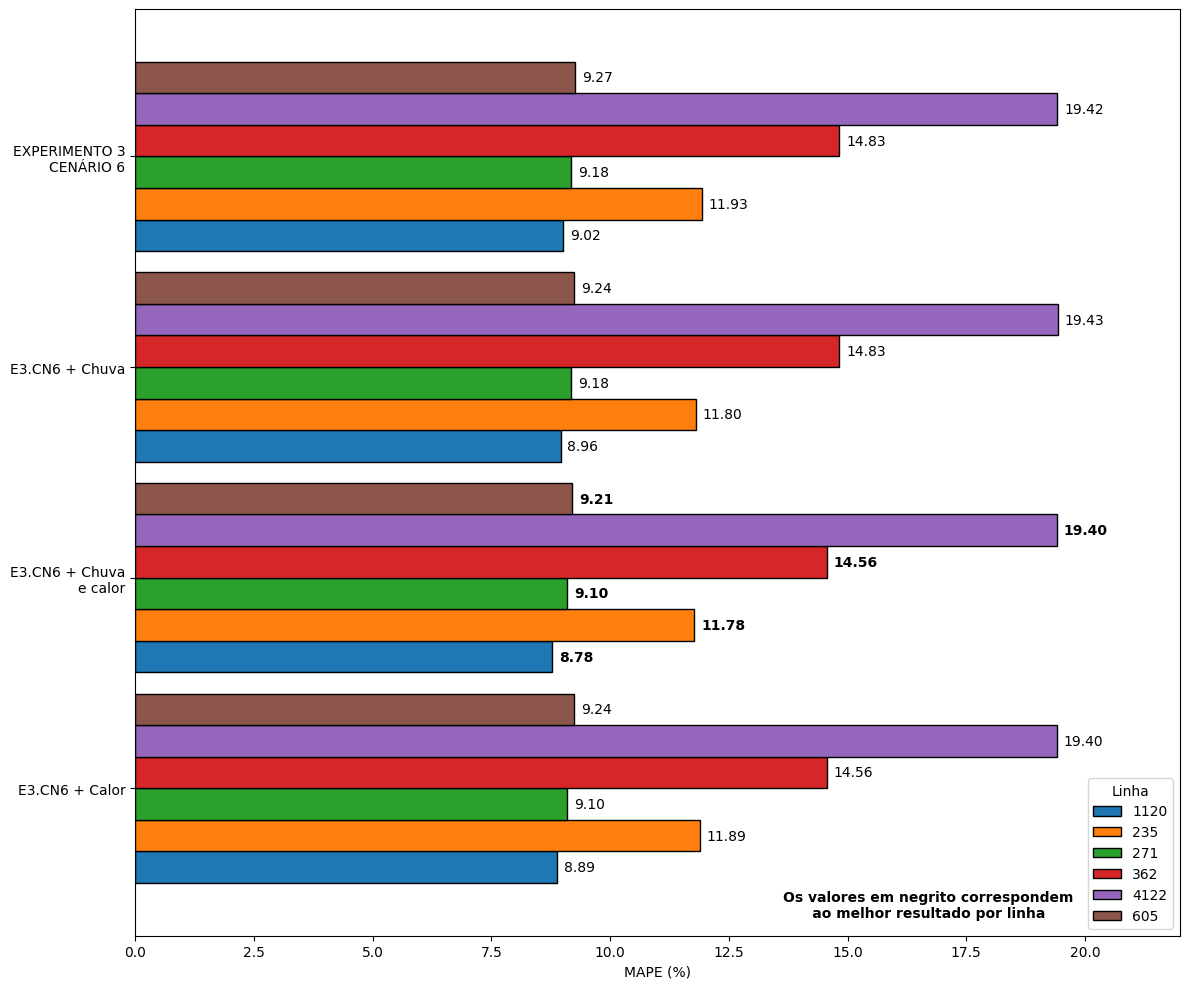

In [71]:
b = a[(a["Métrica"] == "MAPE") & (a["Modelo"] == "Linear Regression")  & (a["Teste"].str.contains("2 - Teste"))]
d = a[(a["Métrica"] == "MAPE") & (a["Modelo"] == "Linear Regression")  & (a["Teste"] == "3 Tempos Anterios - ['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7']")]
b = pd.concat([d, b], ignore_index=True)

b["Valor"] = b["Valor"] * 100

df_pivot = b.pivot(index='Teste', columns='Rota', values='Valor').sort_values("Teste")
df_pivot.index = ["E3.CN6 + Calor", "E3.CN6 + Chuva\ne calor", "E3.CN6 + Chuva", "EXPERIMENTO 3\nCENÁRIO 6"]

plt.rcParams["figure.autolayout"] = True

ax = df_pivot.plot(kind='barh', width = 0.9, figsize=[12, 10], edgecolor="black")

min_linha = b.groupby("Rota").agg({"Valor": "min"})["Valor"].unique()

for p in ax.patches:
    value = p.get_width()
    value_f = "{:.2f}".format(value)
    if value in min_linha:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontweight='bold')
    else:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.xlabel("MAPE (%)")
plt.xlim(0, 22)

ax.legend(title="Linha", loc="lower right")
ax.text(0.62, 0.02, "Os valores em negrito correspondem\n      ao melhor resultado por linha", transform=ax.transAxes, fontsize=10, color="black", fontweight="bold")

plt.savefig("Results/resultados_clima_lr.svg")
plt.savefig("Results/resultados_clima_lr.png")


# Teste com intervalor de treino diferentes

In [72]:
Intervalos = ['2019-01-01','2019-03-01','2019-05-01','2019-07-01','2019-09-01']

TestesNome = [
    "4 Teste de Intervalos - 1 Janeiro",
    "4 Teste de Intervalos - 2 Março",
    "4 Teste de Intervalos - 3 Maio",
    "4 Teste de Intervalos - 4 Julho",
    "4 Teste de Intervalos - 5 Setembro"
]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    for i in range(len(Intervalos)):
        df_teste = df_modelo.loc[df_modelo['Ini'] > Intervalos[i]]
        df_treino = df_modelo.loc[df_modelo['Ini'] <= Intervalos[i]]
        teste_nome = TestesNome[i]

        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva','Calor']]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva','Calor']]
        y_treino = df_treino["DuraçãoViagem"]

        cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)

[0]	validation_0-rmse:2853.42796
[1]	validation_0-rmse:2029.20952
[2]	validation_0-rmse:1456.34563
[3]	validation_0-rmse:1059.14516
[4]	validation_0-rmse:786.05647
[5]	validation_0-rmse:598.43295
[6]	validation_0-rmse:469.93121
[7]	validation_0-rmse:380.77913
[8]	validation_0-rmse:320.00110
[9]	validation_0-rmse:271.29697
[10]	validation_0-rmse:244.48201
[11]	validation_0-rmse:227.05387
[12]	validation_0-rmse:216.48991
[13]	validation_0-rmse:197.36110
[14]	validation_0-rmse:191.69935
[15]	validation_0-rmse:186.60783
[16]	validation_0-rmse:183.09486
[17]	validation_0-rmse:171.36630
[18]	validation_0-rmse:156.22534
[19]	validation_0-rmse:140.34617
[20]	validation_0-rmse:134.75218
[21]	validation_0-rmse:131.58312
[22]	validation_0-rmse:124.62278
[23]	validation_0-rmse:116.22342
[24]	validation_0-rmse:112.55456
[25]	validation_0-rmse:106.59848
[26]	validation_0-rmse:98.96726
[27]	validation_0-rmse:96.71503
[28]	validation_0-rmse:94.36496
[29]	validation_0-rmse:92.31997
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2790.47041
[1]	validation_0-rmse:1983.23148
[2]	validation_0-rmse:1426.94103
[3]	validation_0-rmse:1046.26171
[4]	validation_0-rmse:788.02509
[5]	validation_0-rmse:615.44308
[6]	validation_0-rmse:500.66125
[7]	validation_0-rmse:429.70693
[8]	validation_0-rmse:384.90228
[9]	validation_0-rmse:355.90920
[10]	validation_0-rmse:340.46839
[11]	validation_0-rmse:327.35622
[12]	validation_0-rmse:319.32923
[13]	validation_0-rmse:312.93226
[14]	validation_0-rmse:305.65852
[15]	validation_0-rmse:294.17153
[16]	validation_0-rmse:285.94063
[17]	validation_0-rmse:280.12105
[18]	validation_0-rmse:269.44657
[19]	validation_0-rmse:267.99833
[20]	validation_0-rmse:261.08342
[21]	validation_0-rmse:250.38945
[22]	validation_0-rmse:244.24147
[23]	validation_0-rmse:240.33160
[24]	validation_0-rmse:232.76692
[25]	validation_0-rmse:229.64317
[26]	validation_0-rmse:227.74592
[27]	validation_0-rmse:219.04289
[28]	validation_0-rmse:216.10911
[29]	validation_0-rmse:214.13308
[30]	validation_

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2773.23599
[1]	validation_0-rmse:1970.77086
[2]	validation_0-rmse:1414.12777
[3]	validation_0-rmse:1034.23033
[4]	validation_0-rmse:778.52063
[5]	validation_0-rmse:608.20978
[6]	validation_0-rmse:495.83095
[7]	validation_0-rmse:427.25931
[8]	validation_0-rmse:382.97315
[9]	validation_0-rmse:357.39962
[10]	validation_0-rmse:339.02493
[11]	validation_0-rmse:331.08484
[12]	validation_0-rmse:324.08277
[13]	validation_0-rmse:319.00767
[14]	validation_0-rmse:312.11444
[15]	validation_0-rmse:306.17328
[16]	validation_0-rmse:297.00549
[17]	validation_0-rmse:294.06808
[18]	validation_0-rmse:289.36551
[19]	validation_0-rmse:282.97767
[20]	validation_0-rmse:276.25943
[21]	validation_0-rmse:268.13811
[22]	validation_0-rmse:264.80219
[23]	validation_0-rmse:259.41297
[24]	validation_0-rmse:252.19074
[25]	validation_0-rmse:248.10595
[26]	validation_0-rmse:246.19678
[27]	validation_0-rmse:245.24165
[28]	validation_0-rmse:244.19061
[29]	validation_0-rmse:240.07888
[30]	validation_

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2761.19465
[1]	validation_0-rmse:1958.55936
[2]	validation_0-rmse:1405.65754
[3]	validation_0-rmse:1025.23758
[4]	validation_0-rmse:770.32107
[5]	validation_0-rmse:602.19423
[6]	validation_0-rmse:491.98059
[7]	validation_0-rmse:424.26161
[8]	validation_0-rmse:380.78657
[9]	validation_0-rmse:357.39664
[10]	validation_0-rmse:340.23059
[11]	validation_0-rmse:328.16868
[12]	validation_0-rmse:321.45528
[13]	validation_0-rmse:311.49503
[14]	validation_0-rmse:304.82756
[15]	validation_0-rmse:300.01912
[16]	validation_0-rmse:297.76173
[17]	validation_0-rmse:291.85860
[18]	validation_0-rmse:288.90453
[19]	validation_0-rmse:284.03078
[20]	validation_0-rmse:279.34395
[21]	validation_0-rmse:277.67766
[22]	validation_0-rmse:276.05408
[23]	validation_0-rmse:269.42718
[24]	validation_0-rmse:262.46969
[25]	validation_0-rmse:258.25535
[26]	validation_0-rmse:255.80286
[27]	validation_0-rmse:254.75971
[28]	validation_0-rmse:249.43824
[29]	validation_0-rmse:247.15339
[30]	validation_

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[19]	validation_0-rmse:291.72574
[20]	validation_0-rmse:285.57482
[21]	validation_0-rmse:284.35896
[22]	validation_0-rmse:279.27952
[23]	validation_0-rmse:274.81961
[24]	validation_0-rmse:270.74273
[25]	validation_0-rmse:268.18421
[26]	validation_0-rmse:267.02599
[27]	validation_0-rmse:263.53939
[28]	validation_0-rmse:260.88583
[29]	validation_0-rmse:255.96722
[30]	validation_0-rmse:253.76841
[31]	validation_0-rmse:252.55675
[32]	validation_0-rmse:248.59918
[33]	validation_0-rmse:246.48046
[34]	validation_0-rmse:243.49497
[35]	validation_0-rmse:240.22416
[36]	validation_0-rmse:239.49657
[37]	validation_0-rmse:238.35571
[38]	validation_0-rmse:233.26299
[39]	validation_0-rmse:229.94887
[40]	validation_0-rmse:227.37900
[41]	validation_0-rmse:224.32030
[42]	validation_0-rmse:222.31155
[43]	validation_0-rmse:219.01214
[44]	validation_0-rmse:216.03391
[45]	validation_0-rmse:215.16694
[46]	validation_0-rmse:212.49945
[47]	validation_0-rmse:211.54413
[48]	validation_0-rmse:210.82130
[49]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[63]	validation_0-rmse:55.71731
[64]	validation_0-rmse:55.64690
[65]	validation_0-rmse:55.58829
[66]	validation_0-rmse:55.39402
[67]	validation_0-rmse:54.70199
[68]	validation_0-rmse:54.28323
[69]	validation_0-rmse:54.15445
[70]	validation_0-rmse:53.61938
[71]	validation_0-rmse:53.34653
[72]	validation_0-rmse:52.95574
[73]	validation_0-rmse:52.89050
[74]	validation_0-rmse:52.74031
[75]	validation_0-rmse:52.13606
[76]	validation_0-rmse:51.87565
[77]	validation_0-rmse:51.61546
[78]	validation_0-rmse:51.38263
[79]	validation_0-rmse:51.12613
[80]	validation_0-rmse:51.03542
[81]	validation_0-rmse:50.51597
[82]	validation_0-rmse:50.43297
[83]	validation_0-rmse:50.33231
[84]	validation_0-rmse:50.05282
[85]	validation_0-rmse:49.95081
[86]	validation_0-rmse:49.84875
[87]	validation_0-rmse:49.70535
[88]	validation_0-rmse:49.48647
[89]	validation_0-rmse:49.45963
[90]	validation_0-rmse:49.45114
[91]	validation_0-rmse:49.27474
[92]	validation_0-rmse:49.12548
[93]	validation_0-rmse:48.91938
[94]	val

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1824.48520
[1]	validation_0-rmse:1308.20021
[2]	validation_0-rmse:949.52277
[3]	validation_0-rmse:700.90192
[4]	validation_0-rmse:530.86191
[5]	validation_0-rmse:417.44158
[6]	validation_0-rmse:337.39920
[7]	validation_0-rmse:287.18582
[8]	validation_0-rmse:254.97315
[9]	validation_0-rmse:229.61144
[10]	validation_0-rmse:212.17279
[11]	validation_0-rmse:201.48527
[12]	validation_0-rmse:191.64981
[13]	validation_0-rmse:185.41838
[14]	validation_0-rmse:181.84440
[15]	validation_0-rmse:175.96987
[16]	validation_0-rmse:173.12435
[17]	validation_0-rmse:171.95331
[18]	validation_0-rmse:168.95860
[19]	validation_0-rmse:162.58189
[20]	validation_0-rmse:160.93011
[21]	validation_0-rmse:155.51905
[22]	validation_0-rmse:155.07793
[23]	validation_0-rmse:151.44840
[24]	validation_0-rmse:150.62933
[25]	validation_0-rmse:147.99946
[26]	validation_0-rmse:143.67234
[27]	validation_0-rmse:139.86469
[28]	validation_0-rmse:137.94653
[29]	validation_0-rmse:135.76486
[30]	validation_0-

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1914.11838
[1]	validation_0-rmse:1369.05279
[2]	validation_0-rmse:992.54165
[3]	validation_0-rmse:732.69856
[4]	validation_0-rmse:555.76118
[5]	validation_0-rmse:437.94079
[6]	validation_0-rmse:359.79680
[7]	validation_0-rmse:311.39637
[8]	validation_0-rmse:276.90886
[9]	validation_0-rmse:255.16364
[10]	validation_0-rmse:238.38169
[11]	validation_0-rmse:228.39219
[12]	validation_0-rmse:220.49278
[13]	validation_0-rmse:215.54631
[14]	validation_0-rmse:210.64911
[15]	validation_0-rmse:207.15749
[16]	validation_0-rmse:205.10070
[17]	validation_0-rmse:201.51531
[18]	validation_0-rmse:199.21212
[19]	validation_0-rmse:198.32254
[20]	validation_0-rmse:192.38056
[21]	validation_0-rmse:190.65080
[22]	validation_0-rmse:188.85314
[23]	validation_0-rmse:183.78952
[24]	validation_0-rmse:181.84403
[25]	validation_0-rmse:177.91312
[26]	validation_0-rmse:176.31667
[27]	validation_0-rmse:173.31960
[28]	validation_0-rmse:170.70775
[29]	validation_0-rmse:167.59280
[30]	validation_0-

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1945.41215
[1]	validation_0-rmse:1390.19407
[2]	validation_0-rmse:1008.13973
[3]	validation_0-rmse:743.93974
[4]	validation_0-rmse:567.73097
[5]	validation_0-rmse:449.30333
[6]	validation_0-rmse:370.47390
[7]	validation_0-rmse:321.35617
[8]	validation_0-rmse:289.99952
[9]	validation_0-rmse:270.87258
[10]	validation_0-rmse:258.10534
[11]	validation_0-rmse:248.82286
[12]	validation_0-rmse:243.14349
[13]	validation_0-rmse:238.39902
[14]	validation_0-rmse:234.89341
[15]	validation_0-rmse:230.08459
[16]	validation_0-rmse:223.41865
[17]	validation_0-rmse:222.24997
[18]	validation_0-rmse:219.54119
[19]	validation_0-rmse:215.64798
[20]	validation_0-rmse:212.50744
[21]	validation_0-rmse:207.94726
[22]	validation_0-rmse:207.50661
[23]	validation_0-rmse:205.32557
[24]	validation_0-rmse:203.60346
[25]	validation_0-rmse:200.00836
[26]	validation_0-rmse:195.91071
[27]	validation_0-rmse:194.49020
[28]	validation_0-rmse:192.58523
[29]	validation_0-rmse:191.60054
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[10]	validation_0-rmse:273.62294
[11]	validation_0-rmse:267.57346
[12]	validation_0-rmse:260.13940
[13]	validation_0-rmse:253.74680
[14]	validation_0-rmse:249.37728
[15]	validation_0-rmse:242.80684
[16]	validation_0-rmse:239.22789
[17]	validation_0-rmse:236.41467
[18]	validation_0-rmse:234.28769
[19]	validation_0-rmse:232.33728
[20]	validation_0-rmse:231.32994
[21]	validation_0-rmse:228.27232
[22]	validation_0-rmse:226.09037
[23]	validation_0-rmse:224.06826
[24]	validation_0-rmse:222.08015
[25]	validation_0-rmse:217.72479
[26]	validation_0-rmse:213.45779
[27]	validation_0-rmse:210.76849
[28]	validation_0-rmse:208.53706
[29]	validation_0-rmse:206.80759
[30]	validation_0-rmse:206.11399
[31]	validation_0-rmse:204.62461
[32]	validation_0-rmse:202.97784
[33]	validation_0-rmse:201.73481
[34]	validation_0-rmse:200.85995
[35]	validation_0-rmse:199.14952
[36]	validation_0-rmse:198.81756
[37]	validation_0-rmse:198.04215
[38]	validation_0-rmse:195.81453
[39]	validation_0-rmse:194.63484
[40]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[41]	validation_0-rmse:93.93235
[42]	validation_0-rmse:93.15220
[43]	validation_0-rmse:92.48001
[44]	validation_0-rmse:90.63859
[45]	validation_0-rmse:90.18740
[46]	validation_0-rmse:89.80767
[47]	validation_0-rmse:88.95414
[48]	validation_0-rmse:87.49851
[49]	validation_0-rmse:86.37134
[50]	validation_0-rmse:85.66857
[51]	validation_0-rmse:84.57378
[52]	validation_0-rmse:83.10019
[53]	validation_0-rmse:82.77260
[54]	validation_0-rmse:81.88775
[55]	validation_0-rmse:81.10139
[56]	validation_0-rmse:80.37408
[57]	validation_0-rmse:79.44313
[58]	validation_0-rmse:78.92078
[59]	validation_0-rmse:77.97278
[60]	validation_0-rmse:77.41295
[61]	validation_0-rmse:77.16137
[62]	validation_0-rmse:75.83289
[63]	validation_0-rmse:75.49405
[64]	validation_0-rmse:74.52848
[65]	validation_0-rmse:73.94875
[66]	validation_0-rmse:73.53355
[67]	validation_0-rmse:72.87745
[68]	validation_0-rmse:72.39582
[69]	validation_0-rmse:72.00925
[70]	validation_0-rmse:70.94803
[71]	validation_0-rmse:70.22808
[72]	val

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1031.72590
[1]	validation_0-rmse:734.12799
[2]	validation_0-rmse:528.91773
[3]	validation_0-rmse:390.06280
[4]	validation_0-rmse:297.65160
[5]	validation_0-rmse:238.96691
[6]	validation_0-rmse:202.30263
[7]	validation_0-rmse:179.52021
[8]	validation_0-rmse:167.64226
[9]	validation_0-rmse:159.14793
[10]	validation_0-rmse:154.52938
[11]	validation_0-rmse:152.33284
[12]	validation_0-rmse:148.16854
[13]	validation_0-rmse:146.47808
[14]	validation_0-rmse:144.68490
[15]	validation_0-rmse:143.30311
[16]	validation_0-rmse:142.73401
[17]	validation_0-rmse:140.97306
[18]	validation_0-rmse:139.78729
[19]	validation_0-rmse:138.97769
[20]	validation_0-rmse:138.43485
[21]	validation_0-rmse:137.28406
[22]	validation_0-rmse:135.84831
[23]	validation_0-rmse:134.48040
[24]	validation_0-rmse:132.80917
[25]	validation_0-rmse:132.46409
[26]	validation_0-rmse:131.42788
[27]	validation_0-rmse:129.66646
[28]	validation_0-rmse:128.60889
[29]	validation_0-rmse:127.62890
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1024.93551
[1]	validation_0-rmse:729.03764
[2]	validation_0-rmse:525.30356
[3]	validation_0-rmse:387.11328
[4]	validation_0-rmse:295.95596
[5]	validation_0-rmse:237.78824
[6]	validation_0-rmse:201.21617
[7]	validation_0-rmse:181.21046
[8]	validation_0-rmse:168.17425
[9]	validation_0-rmse:161.42061
[10]	validation_0-rmse:156.25687
[11]	validation_0-rmse:154.02083
[12]	validation_0-rmse:152.59934
[13]	validation_0-rmse:150.69541
[14]	validation_0-rmse:149.75244
[15]	validation_0-rmse:147.90546
[16]	validation_0-rmse:146.80136
[17]	validation_0-rmse:145.38796
[18]	validation_0-rmse:144.61735
[19]	validation_0-rmse:142.38722
[20]	validation_0-rmse:141.95319
[21]	validation_0-rmse:140.85554
[22]	validation_0-rmse:139.97536
[23]	validation_0-rmse:138.51893
[24]	validation_0-rmse:138.25306
[25]	validation_0-rmse:137.81671
[26]	validation_0-rmse:136.77454
[27]	validation_0-rmse:136.29837
[28]	validation_0-rmse:134.99221
[29]	validation_0-rmse:133.91522
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1017.17095
[1]	validation_0-rmse:723.12679
[2]	validation_0-rmse:520.83278
[3]	validation_0-rmse:383.51201
[4]	validation_0-rmse:292.20753
[5]	validation_0-rmse:234.28560
[6]	validation_0-rmse:199.06628
[7]	validation_0-rmse:179.09754
[8]	validation_0-rmse:168.02140
[9]	validation_0-rmse:161.84344
[10]	validation_0-rmse:158.29698
[11]	validation_0-rmse:155.49418
[12]	validation_0-rmse:152.33581
[13]	validation_0-rmse:150.90136
[14]	validation_0-rmse:150.11765
[15]	validation_0-rmse:148.29793
[16]	validation_0-rmse:147.85030
[17]	validation_0-rmse:147.01313
[18]	validation_0-rmse:144.53269
[19]	validation_0-rmse:144.05055
[20]	validation_0-rmse:143.03573
[21]	validation_0-rmse:142.00967
[22]	validation_0-rmse:141.59417
[23]	validation_0-rmse:140.57458
[24]	validation_0-rmse:139.84086
[25]	validation_0-rmse:138.80853
[26]	validation_0-rmse:137.16270
[27]	validation_0-rmse:136.37989
[28]	validation_0-rmse:135.88126
[29]	validation_0-rmse:135.62714
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1011.72839
[1]	validation_0-rmse:719.20186
[2]	validation_0-rmse:517.81112
[3]	validation_0-rmse:381.29744
[4]	validation_0-rmse:290.83129
[5]	validation_0-rmse:233.63395
[6]	validation_0-rmse:198.39670
[7]	validation_0-rmse:178.84629
[8]	validation_0-rmse:167.32404
[9]	validation_0-rmse:159.78451
[10]	validation_0-rmse:155.68786
[11]	validation_0-rmse:153.93635
[12]	validation_0-rmse:152.52805
[13]	validation_0-rmse:150.97449
[14]	validation_0-rmse:150.56501
[15]	validation_0-rmse:150.02233
[16]	validation_0-rmse:147.80508
[17]	validation_0-rmse:146.69519
[18]	validation_0-rmse:146.26236
[19]	validation_0-rmse:145.96464
[20]	validation_0-rmse:145.09906
[21]	validation_0-rmse:144.52948
[22]	validation_0-rmse:144.03062
[23]	validation_0-rmse:142.70106
[24]	validation_0-rmse:141.87839
[25]	validation_0-rmse:141.20693
[26]	validation_0-rmse:140.75094
[27]	validation_0-rmse:140.20816
[28]	validation_0-rmse:139.25232
[29]	validation_0-rmse:138.46882
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:598.92098
[1]	validation_0-rmse:434.31258
[2]	validation_0-rmse:322.38867
[3]	validation_0-rmse:247.25466
[4]	validation_0-rmse:195.89425
[5]	validation_0-rmse:161.37309
[6]	validation_0-rmse:138.76351
[7]	validation_0-rmse:124.94225
[8]	validation_0-rmse:116.07748
[9]	validation_0-rmse:107.86981
[10]	validation_0-rmse:102.93615
[11]	validation_0-rmse:100.85835
[12]	validation_0-rmse:97.48214
[13]	validation_0-rmse:93.49071
[14]	validation_0-rmse:91.83820
[15]	validation_0-rmse:91.38972
[16]	validation_0-rmse:87.67944
[17]	validation_0-rmse:86.48234
[18]	validation_0-rmse:83.91416
[19]	validation_0-rmse:83.51831
[20]	validation_0-rmse:81.28741
[21]	validation_0-rmse:79.78815
[22]	validation_0-rmse:79.18870
[23]	validation_0-rmse:76.44150
[24]	validation_0-rmse:76.01839
[25]	validation_0-rmse:73.68379
[26]	validation_0-rmse:70.83088
[27]	validation_0-rmse:70.24869
[28]	validation_0-rmse:68.26988
[29]	validation_0-rmse:66.99792
[30]	validation_0-rmse:66.78167
[31]	v

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:609.30960
[1]	validation_0-rmse:441.35241
[2]	validation_0-rmse:327.13501
[3]	validation_0-rmse:251.39373
[4]	validation_0-rmse:201.51534
[5]	validation_0-rmse:169.41425
[6]	validation_0-rmse:149.43393
[7]	validation_0-rmse:136.76325
[8]	validation_0-rmse:128.92231
[9]	validation_0-rmse:123.18296
[10]	validation_0-rmse:119.93627
[11]	validation_0-rmse:116.86895
[12]	validation_0-rmse:115.40376
[13]	validation_0-rmse:113.02464
[14]	validation_0-rmse:110.90138
[15]	validation_0-rmse:108.74789
[16]	validation_0-rmse:108.10377
[17]	validation_0-rmse:105.73099
[18]	validation_0-rmse:105.08727
[19]	validation_0-rmse:103.82107
[20]	validation_0-rmse:102.24348
[21]	validation_0-rmse:100.99485
[22]	validation_0-rmse:99.32597
[23]	validation_0-rmse:98.52046
[24]	validation_0-rmse:96.45338
[25]	validation_0-rmse:94.64815
[26]	validation_0-rmse:92.57836
[27]	validation_0-rmse:91.61814
[28]	validation_0-rmse:90.63489
[29]	validation_0-rmse:89.50298
[30]	validation_0-rmse:89.03

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:607.11745
[1]	validation_0-rmse:439.02629
[2]	validation_0-rmse:325.43420
[3]	validation_0-rmse:249.95847
[4]	validation_0-rmse:201.19844
[5]	validation_0-rmse:170.45572
[6]	validation_0-rmse:151.90064
[7]	validation_0-rmse:140.51951
[8]	validation_0-rmse:134.19201
[9]	validation_0-rmse:130.05809
[10]	validation_0-rmse:127.00577
[11]	validation_0-rmse:125.17560
[12]	validation_0-rmse:121.91156
[13]	validation_0-rmse:120.15145
[14]	validation_0-rmse:118.66126
[15]	validation_0-rmse:116.58442
[16]	validation_0-rmse:115.68437
[17]	validation_0-rmse:113.83565
[18]	validation_0-rmse:113.47391
[19]	validation_0-rmse:112.56094
[20]	validation_0-rmse:110.68009
[21]	validation_0-rmse:109.65141
[22]	validation_0-rmse:109.08026
[23]	validation_0-rmse:107.52458
[24]	validation_0-rmse:106.96430
[25]	validation_0-rmse:106.61644
[26]	validation_0-rmse:105.64173
[27]	validation_0-rmse:105.19100
[28]	validation_0-rmse:104.38978
[29]	validation_0-rmse:103.24573
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:605.01413
[1]	validation_0-rmse:437.13582
[2]	validation_0-rmse:323.56179
[3]	validation_0-rmse:248.44135
[4]	validation_0-rmse:200.12027
[5]	validation_0-rmse:170.30276
[6]	validation_0-rmse:152.81001
[7]	validation_0-rmse:142.52518
[8]	validation_0-rmse:135.83074
[9]	validation_0-rmse:131.40571
[10]	validation_0-rmse:128.85833
[11]	validation_0-rmse:126.83839
[12]	validation_0-rmse:125.67512
[13]	validation_0-rmse:124.09258
[14]	validation_0-rmse:123.28892
[15]	validation_0-rmse:121.90762
[16]	validation_0-rmse:120.61395
[17]	validation_0-rmse:118.63608
[18]	validation_0-rmse:116.69545
[19]	validation_0-rmse:116.20959
[20]	validation_0-rmse:114.73970
[21]	validation_0-rmse:114.35104
[22]	validation_0-rmse:113.62809
[23]	validation_0-rmse:112.74912
[24]	validation_0-rmse:111.59896
[25]	validation_0-rmse:110.75058
[26]	validation_0-rmse:109.42813
[27]	validation_0-rmse:108.29569
[28]	validation_0-rmse:107.64509
[29]	validation_0-rmse:107.13156
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:602.42001
[1]	validation_0-rmse:435.27463
[2]	validation_0-rmse:322.20331
[3]	validation_0-rmse:247.50451
[4]	validation_0-rmse:200.06315
[5]	validation_0-rmse:171.11900
[6]	validation_0-rmse:153.48523
[7]	validation_0-rmse:143.47272
[8]	validation_0-rmse:137.70424
[9]	validation_0-rmse:134.43821
[10]	validation_0-rmse:132.17845
[11]	validation_0-rmse:130.21137
[12]	validation_0-rmse:128.16059
[13]	validation_0-rmse:127.66126
[14]	validation_0-rmse:126.84709
[15]	validation_0-rmse:126.08332
[16]	validation_0-rmse:125.64428
[17]	validation_0-rmse:124.69978
[18]	validation_0-rmse:124.29095
[19]	validation_0-rmse:122.40981
[20]	validation_0-rmse:122.07011
[21]	validation_0-rmse:120.96571
[22]	validation_0-rmse:120.53936
[23]	validation_0-rmse:119.21498
[24]	validation_0-rmse:118.22477
[25]	validation_0-rmse:117.83762
[26]	validation_0-rmse:117.52820
[27]	validation_0-rmse:116.28525
[28]	validation_0-rmse:115.46922
[29]	validation_0-rmse:114.33303
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2376.91376
[1]	validation_0-rmse:1707.04003
[2]	validation_0-rmse:1243.60228
[3]	validation_0-rmse:926.20878
[4]	validation_0-rmse:705.73689
[5]	validation_0-rmse:551.55253
[6]	validation_0-rmse:441.33732
[7]	validation_0-rmse:368.37623
[8]	validation_0-rmse:315.02341
[9]	validation_0-rmse:279.55603
[10]	validation_0-rmse:240.57341
[11]	validation_0-rmse:219.53741
[12]	validation_0-rmse:203.29917
[13]	validation_0-rmse:188.93783
[14]	validation_0-rmse:179.69585
[15]	validation_0-rmse:162.45567
[16]	validation_0-rmse:155.76203
[17]	validation_0-rmse:152.22921
[18]	validation_0-rmse:147.60290
[19]	validation_0-rmse:134.26956
[20]	validation_0-rmse:131.84919
[21]	validation_0-rmse:122.69402
[22]	validation_0-rmse:120.98743
[23]	validation_0-rmse:113.68184
[24]	validation_0-rmse:112.13889
[25]	validation_0-rmse:105.04682
[26]	validation_0-rmse:103.51413
[27]	validation_0-rmse:96.69626
[28]	validation_0-rmse:95.59608
[29]	validation_0-rmse:92.67459
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2357.23405
[1]	validation_0-rmse:1691.95330
[2]	validation_0-rmse:1234.42891
[3]	validation_0-rmse:919.66500
[4]	validation_0-rmse:709.23838
[5]	validation_0-rmse:569.89233
[6]	validation_0-rmse:480.20882
[7]	validation_0-rmse:424.72376
[8]	validation_0-rmse:378.24821
[9]	validation_0-rmse:352.10088
[10]	validation_0-rmse:335.07000
[11]	validation_0-rmse:324.54637
[12]	validation_0-rmse:303.72120
[13]	validation_0-rmse:296.47997
[14]	validation_0-rmse:290.21136
[15]	validation_0-rmse:286.07627
[16]	validation_0-rmse:272.08118
[17]	validation_0-rmse:255.83423
[18]	validation_0-rmse:251.80423
[19]	validation_0-rmse:241.44535
[20]	validation_0-rmse:229.10307
[21]	validation_0-rmse:223.32526
[22]	validation_0-rmse:218.83234
[23]	validation_0-rmse:214.25863
[24]	validation_0-rmse:206.51331
[25]	validation_0-rmse:204.32397
[26]	validation_0-rmse:201.54609
[27]	validation_0-rmse:197.89627
[28]	validation_0-rmse:185.49473
[29]	validation_0-rmse:183.51510
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2324.03308
[1]	validation_0-rmse:1671.69341
[2]	validation_0-rmse:1225.29579
[3]	validation_0-rmse:919.79562
[4]	validation_0-rmse:715.77388
[5]	validation_0-rmse:583.28486
[6]	validation_0-rmse:500.63469
[7]	validation_0-rmse:441.58641
[8]	validation_0-rmse:408.02443
[9]	validation_0-rmse:381.25473
[10]	validation_0-rmse:359.66621
[11]	validation_0-rmse:349.77023
[12]	validation_0-rmse:341.17547
[13]	validation_0-rmse:332.17107
[14]	validation_0-rmse:326.66352
[15]	validation_0-rmse:318.92234
[16]	validation_0-rmse:315.27330
[17]	validation_0-rmse:312.04683
[18]	validation_0-rmse:302.59069
[19]	validation_0-rmse:297.73882
[20]	validation_0-rmse:288.89641
[21]	validation_0-rmse:284.20291
[22]	validation_0-rmse:272.58409
[23]	validation_0-rmse:270.85953
[24]	validation_0-rmse:267.42923
[25]	validation_0-rmse:263.33055
[26]	validation_0-rmse:258.10950
[27]	validation_0-rmse:250.67542
[28]	validation_0-rmse:246.15750
[29]	validation_0-rmse:238.83528
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[3]	validation_0-rmse:897.98920
[4]	validation_0-rmse:696.00520
[5]	validation_0-rmse:564.90996
[6]	validation_0-rmse:484.35826
[7]	validation_0-rmse:432.10543
[8]	validation_0-rmse:393.05266
[9]	validation_0-rmse:372.44041
[10]	validation_0-rmse:360.41070
[11]	validation_0-rmse:344.69909
[12]	validation_0-rmse:332.49057
[13]	validation_0-rmse:321.54614
[14]	validation_0-rmse:319.07020
[15]	validation_0-rmse:311.02802
[16]	validation_0-rmse:304.28570
[17]	validation_0-rmse:295.73753
[18]	validation_0-rmse:290.05792
[19]	validation_0-rmse:288.76010
[20]	validation_0-rmse:285.07425
[21]	validation_0-rmse:275.41371
[22]	validation_0-rmse:271.29205
[23]	validation_0-rmse:266.55367
[24]	validation_0-rmse:261.68991
[25]	validation_0-rmse:257.54479
[26]	validation_0-rmse:249.25889
[27]	validation_0-rmse:248.26597
[28]	validation_0-rmse:246.74067
[29]	validation_0-rmse:243.21166
[30]	validation_0-rmse:240.99396
[31]	validation_0-rmse:237.34057
[32]	validation_0-rmse:230.54443
[33]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[7]	validation_0-rmse:429.98748
[8]	validation_0-rmse:394.88697
[9]	validation_0-rmse:373.44251
[10]	validation_0-rmse:358.16912
[11]	validation_0-rmse:350.78831
[12]	validation_0-rmse:338.72718
[13]	validation_0-rmse:332.36779
[14]	validation_0-rmse:327.52072
[15]	validation_0-rmse:325.65510
[16]	validation_0-rmse:321.71601
[17]	validation_0-rmse:314.14843
[18]	validation_0-rmse:307.21378
[19]	validation_0-rmse:302.12942
[20]	validation_0-rmse:297.44569
[21]	validation_0-rmse:292.33186
[22]	validation_0-rmse:288.86312
[23]	validation_0-rmse:284.55890
[24]	validation_0-rmse:280.17460
[25]	validation_0-rmse:275.85668
[26]	validation_0-rmse:274.35626
[27]	validation_0-rmse:272.02681
[28]	validation_0-rmse:266.60489
[29]	validation_0-rmse:264.90650
[30]	validation_0-rmse:262.88490
[31]	validation_0-rmse:257.08295
[32]	validation_0-rmse:250.56158
[33]	validation_0-rmse:246.46924
[34]	validation_0-rmse:241.57625
[35]	validation_0-rmse:237.27104
[36]	validation_0-rmse:234.61249
[37]	validati

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[63]	validation_0-rmse:26.19132
[64]	validation_0-rmse:25.78842
[65]	validation_0-rmse:25.23158
[66]	validation_0-rmse:25.15569
[67]	validation_0-rmse:24.73648
[68]	validation_0-rmse:24.70903
[69]	validation_0-rmse:24.51920
[70]	validation_0-rmse:24.43683
[71]	validation_0-rmse:24.16009
[72]	validation_0-rmse:24.11705
[73]	validation_0-rmse:23.97690
[74]	validation_0-rmse:23.78235
[75]	validation_0-rmse:23.72108
[76]	validation_0-rmse:23.53088
[77]	validation_0-rmse:23.46412
[78]	validation_0-rmse:23.43115
[79]	validation_0-rmse:23.41101
[80]	validation_0-rmse:23.40359
[81]	validation_0-rmse:23.34793
[82]	validation_0-rmse:23.25461
[83]	validation_0-rmse:23.19954
[84]	validation_0-rmse:23.16128
[85]	validation_0-rmse:23.15019
[86]	validation_0-rmse:23.09592
[87]	validation_0-rmse:23.04311
[88]	validation_0-rmse:23.03920
[89]	validation_0-rmse:23.03133
[90]	validation_0-rmse:23.02192
[91]	validation_0-rmse:23.01918
[92]	validation_0-rmse:23.01566
[93]	validation_0-rmse:22.99989
[94]	val

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2284.23434
[1]	validation_0-rmse:1620.84520
[2]	validation_0-rmse:1160.54840
[3]	validation_0-rmse:842.99580
[4]	validation_0-rmse:626.69099
[5]	validation_0-rmse:478.65330
[6]	validation_0-rmse:380.93567
[7]	validation_0-rmse:319.55073
[8]	validation_0-rmse:276.55748
[9]	validation_0-rmse:246.66111
[10]	validation_0-rmse:230.83069
[11]	validation_0-rmse:217.27863
[12]	validation_0-rmse:202.52814
[13]	validation_0-rmse:197.29123
[14]	validation_0-rmse:195.07298
[15]	validation_0-rmse:191.93041
[16]	validation_0-rmse:180.51816
[17]	validation_0-rmse:174.10097
[18]	validation_0-rmse:163.54431
[19]	validation_0-rmse:162.41589
[20]	validation_0-rmse:154.81522
[21]	validation_0-rmse:152.03096
[22]	validation_0-rmse:145.96159
[23]	validation_0-rmse:142.19585
[24]	validation_0-rmse:132.94529
[25]	validation_0-rmse:131.60709
[26]	validation_0-rmse:129.91651
[27]	validation_0-rmse:124.03550
[28]	validation_0-rmse:119.90592
[29]	validation_0-rmse:115.85147
[30]	validation_0

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[22]	validation_0-rmse:164.95673
[23]	validation_0-rmse:162.78979
[24]	validation_0-rmse:153.59674
[25]	validation_0-rmse:152.00458
[26]	validation_0-rmse:150.49095
[27]	validation_0-rmse:143.33184
[28]	validation_0-rmse:141.52520
[29]	validation_0-rmse:138.30266
[30]	validation_0-rmse:135.26766
[31]	validation_0-rmse:133.54921
[32]	validation_0-rmse:127.92898
[33]	validation_0-rmse:122.28621
[34]	validation_0-rmse:121.39098
[35]	validation_0-rmse:118.16855
[36]	validation_0-rmse:116.49195
[37]	validation_0-rmse:114.65476
[38]	validation_0-rmse:113.62743
[39]	validation_0-rmse:110.23702
[40]	validation_0-rmse:109.24567
[41]	validation_0-rmse:107.79062
[42]	validation_0-rmse:106.38201
[43]	validation_0-rmse:103.60499
[44]	validation_0-rmse:103.39980
[45]	validation_0-rmse:102.18266
[46]	validation_0-rmse:100.79650
[47]	validation_0-rmse:98.73757
[48]	validation_0-rmse:96.52121
[49]	validation_0-rmse:96.11785
[50]	validation_0-rmse:95.70574
[51]	validation_0-rmse:92.60981
[52]	validation

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[24]	validation_0-rmse:195.64299
[25]	validation_0-rmse:192.27200
[26]	validation_0-rmse:186.10312
[27]	validation_0-rmse:182.52693
[28]	validation_0-rmse:179.89092
[29]	validation_0-rmse:176.61242
[30]	validation_0-rmse:175.15585
[31]	validation_0-rmse:172.97424
[32]	validation_0-rmse:171.14101
[33]	validation_0-rmse:170.31560
[34]	validation_0-rmse:166.27993
[35]	validation_0-rmse:163.38547
[36]	validation_0-rmse:161.28423
[37]	validation_0-rmse:157.32686
[38]	validation_0-rmse:153.46994
[39]	validation_0-rmse:150.83099
[40]	validation_0-rmse:147.49643
[41]	validation_0-rmse:146.33207
[42]	validation_0-rmse:142.90946
[43]	validation_0-rmse:139.65585
[44]	validation_0-rmse:139.11647
[45]	validation_0-rmse:137.37697
[46]	validation_0-rmse:135.61136
[47]	validation_0-rmse:135.08218
[48]	validation_0-rmse:134.08426
[49]	validation_0-rmse:133.24543
[50]	validation_0-rmse:130.23801
[51]	validation_0-rmse:129.68262
[52]	validation_0-rmse:128.52561
[53]	validation_0-rmse:127.42928
[54]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[41]	validation_0-rmse:174.95153
[42]	validation_0-rmse:170.18743
[43]	validation_0-rmse:165.10361
[44]	validation_0-rmse:161.51962
[45]	validation_0-rmse:159.00090
[46]	validation_0-rmse:154.96150
[47]	validation_0-rmse:153.69178
[48]	validation_0-rmse:151.67026
[49]	validation_0-rmse:151.07569
[50]	validation_0-rmse:150.74312
[51]	validation_0-rmse:148.46531
[52]	validation_0-rmse:148.20842
[53]	validation_0-rmse:145.59510
[54]	validation_0-rmse:144.28786
[55]	validation_0-rmse:143.30819
[56]	validation_0-rmse:141.50623
[57]	validation_0-rmse:140.04734
[58]	validation_0-rmse:139.21000
[59]	validation_0-rmse:138.74900
[60]	validation_0-rmse:134.74391
[61]	validation_0-rmse:134.09622
[62]	validation_0-rmse:133.63897
[63]	validation_0-rmse:132.78740
[64]	validation_0-rmse:128.19870
[65]	validation_0-rmse:126.04193
[66]	validation_0-rmse:124.26344
[67]	validation_0-rmse:121.79757
[68]	validation_0-rmse:120.02333
[69]	validation_0-rmse:119.41792
[70]	validation_0-rmse:118.97139
[71]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [73]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[a['Métrica'] == 'RMSE'].sort_values(by='Valor')

Teste Rota  \
608                     4 Teste de Intervalos - 3 Maio  362   
458  2 - Teste clima - ['Sentido','KmPerc','TotalGi...  362   
610                     4 Teste de Intervalos - 3 Maio  362   
604                    4 Teste de Intervalos - 2 Março  362   
614                    4 Teste de Intervalos - 4 Julho  362   
..                                                 ...  ...   
538                  4 Teste de Intervalos - 1 Janeiro  235   
80   1 Teste de Colunas - ['dia_semana','hora_dia',...  235   
536                  4 Teste de Intervalos - 1 Janeiro  235   
72   1 Teste de Colunas - ['TotalGirosMean','dia_se...  235   
74   1 Teste de Colunas - ['TotalGirosMean','dia_se...  235   

                Modelo Métrica       Valor  Tempo de treino  Tempo de previsão  
608      Random Forest    RMSE  151.772370         0.852830            0.58320  
458      Random Forest    RMSE  153.640045         1.283419            0.49921  
610  Linear Regression    RMSE  154.150919         0.396700            0.00000  
604  Linear Regression    RMSE  154.532498         0.166540            0.00000  
614      Random Forest    RMSE  154.558253         1.166900            0.48599  
..                 ...     ...         ...              ...                ...  
538  Linear Regression    RMSE  902.452978         0.000000            0.00000  
80       Random Forest    RMSE  924.675431         0.334386            0.16638  
536      Random Forest    RMSE  924.991859         0.166500            0.33419  
72             XGBoost    RMSE  925.408234         0.161994            0.10360  
74       Random Forest    RMSE  928.428263         0.400950            0.16640  

[342 rows x 7 columns]

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\898807059.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\898807059.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\898807059.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

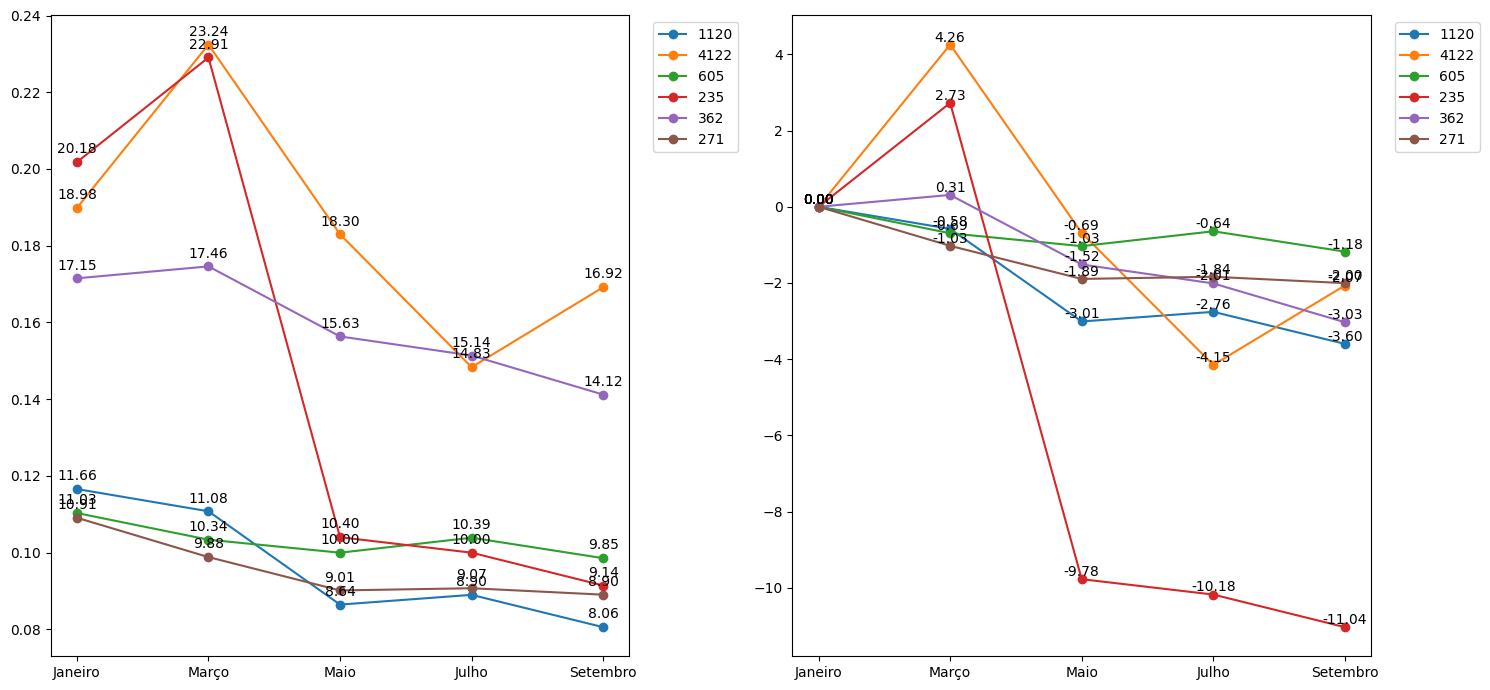

In [74]:
b = a[(a["Modelo"] == "XGBoost") & (a["Métrica"] == "MAPE") & (a["Teste"].str.contains("4 Teste"))].sort_values("Teste")

plt.figure(figsize=[15, 7])
plt.subplot(1,2,1)

for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format(c["Valor"].iloc[i] * 100)
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.subplot(1,2,2)

for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]
    c["Valor"] = c["Valor"].diff()
    c["Valor"] = c["Valor"] * 100
    c.loc[c["Teste"] == "Janeiro", "Valor"] = 0
    c["Valor"] = c["Valor"].cumsum()
    
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format((c["Valor"].iloc[i]))
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
# plt.show()

plt.savefig("Results/resultados_intervalo_treino_xgb.svg")
plt.savefig("Results/resultados_intervalo_treino_xgb.png")

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\71770906.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\71770906.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\71770906.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

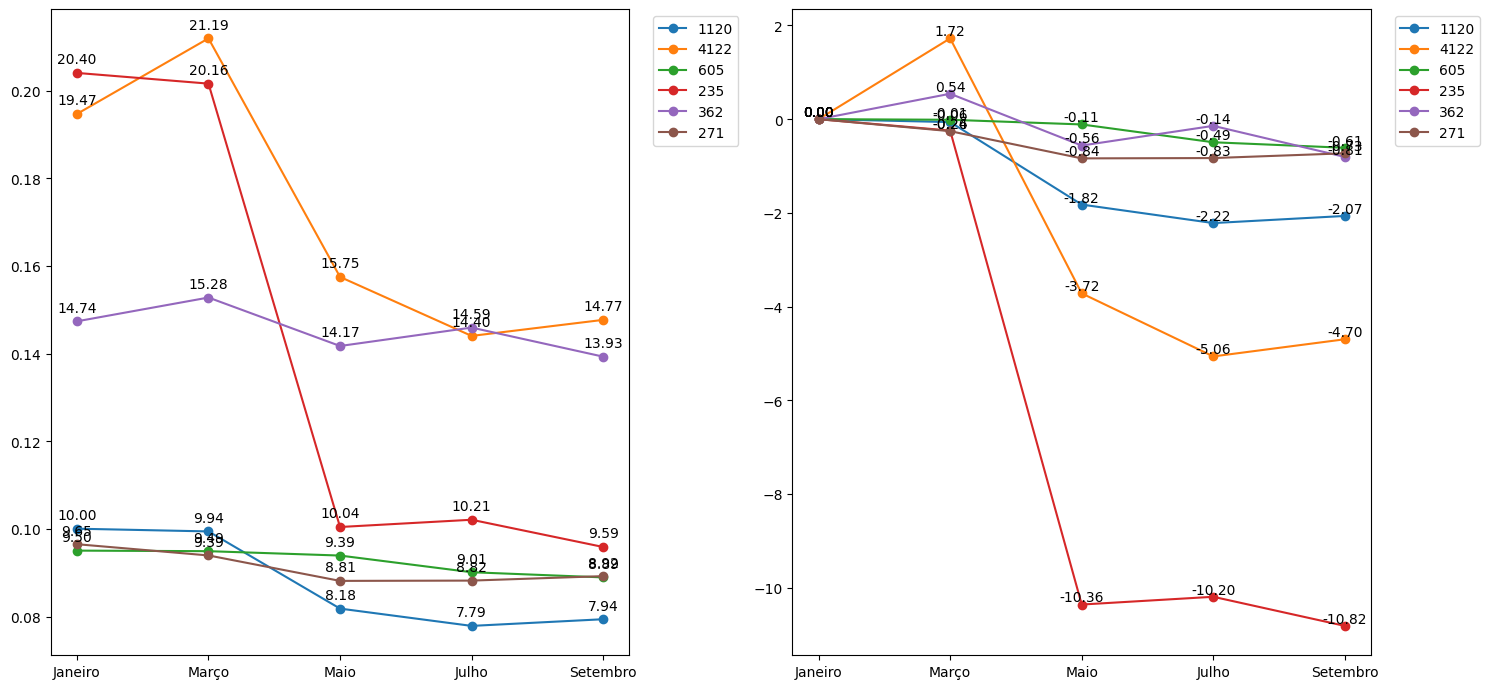

In [75]:
b = a[(a["Modelo"] == "Random Forest") & (a["Métrica"] == "MAPE") & (a["Teste"].str.contains("4 Teste"))].sort_values("Teste")

plt.figure(figsize=[15, 7])
plt.subplot(1,2,1)

for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format(c["Valor"].iloc[i] * 100)
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.subplot(1,2,2)

for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]
    c["Valor"] = c["Valor"].diff()
    c["Valor"] = c["Valor"] * 100
    c.loc[c["Teste"] == "Janeiro", "Valor"] = 0
    c["Valor"] = c["Valor"].cumsum()
    
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format((c["Valor"].iloc[i]))
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
# plt.show()

plt.savefig("Results/resultados_intervalo_treino_rf.svg")
plt.savefig("Results/resultados_intervalo_treino_rf.png")

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\650228331.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\650228331.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\650228331.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

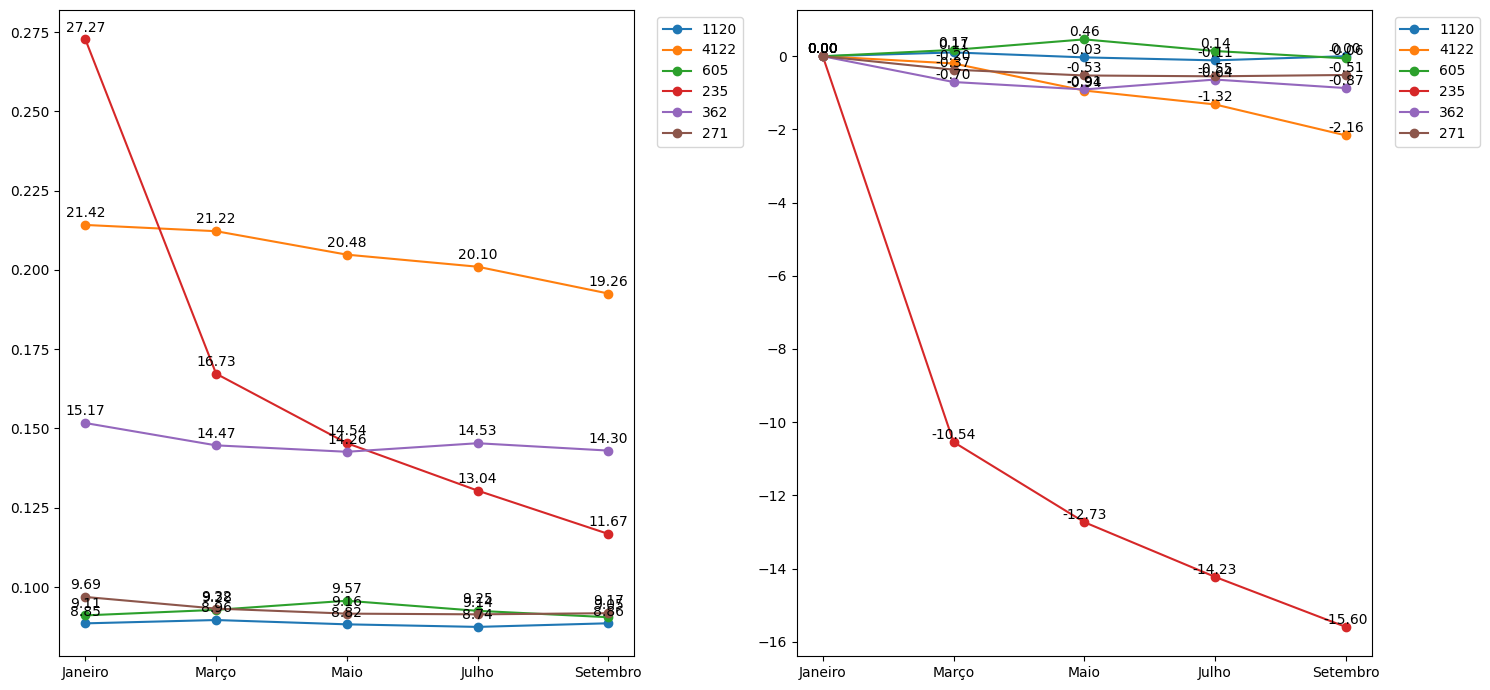

In [76]:
b = a[(a["Modelo"] == "Linear Regression") & (a["Métrica"] == "MAPE") & (a["Teste"].str.contains("4 Teste"))].sort_values("Teste")

plt.figure(figsize=[15, 7])
plt.subplot(1,2,1)

for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format(c["Valor"].iloc[i] * 100)
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.subplot(1,2,2)

for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]
    c["Valor"] = c["Valor"].diff()
    c["Valor"] = c["Valor"] * 100
    c.loc[c["Teste"] == "Janeiro", "Valor"] = 0
    c["Valor"] = c["Valor"].cumsum()
    
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format((c["Valor"].iloc[i]))
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
# plt.show()

plt.savefig("Results/resultados_intervalo_treino_lr.svg")
plt.savefig("Results/resultados_intervalo_treino_lr.png")

In [77]:
from dateutil.relativedelta import relativedelta
from datetime import date

Intervalos = ['2019-01-01','2019-03-01','2019-05-01','2019-07-01','2019-09-01']

TestesNome = [
    "4.1 Teste de Intervalos - 1 Janeiro",
    "4.1 Teste de Intervalos - 2 Março",
    "4.1 Teste de Intervalos - 3 Maio",
    "4.1 Teste de Intervalos - 4 Julho",
    "4.1 Teste de Intervalos - 5 Setembro"
]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    for i in range(len(Intervalos)):
        df_teste = df_modelo.loc[(df_modelo['Ini'] > Intervalos[i]) & (df_modelo['Ini'] <= datetime.strptime(Intervalos[i], "%Y-%m-%d") + relativedelta(months=2))]
        df_treino = df_modelo.loc[df_modelo['Ini'] <= Intervalos[i]]
        teste_nome = TestesNome[i]

        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva','Calor']]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva','Calor']]
        y_treino = df_treino["DuraçãoViagem"]

        cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)

[0]	validation_0-rmse:2853.42796
[1]	validation_0-rmse:2029.20952
[2]	validation_0-rmse:1456.34563
[3]	validation_0-rmse:1059.14516
[4]	validation_0-rmse:786.05647
[5]	validation_0-rmse:598.43295
[6]	validation_0-rmse:469.93121
[7]	validation_0-rmse:380.77913
[8]	validation_0-rmse:320.00110
[9]	validation_0-rmse:271.29697
[10]	validation_0-rmse:244.48201
[11]	validation_0-rmse:227.05387
[12]	validation_0-rmse:216.48991
[13]	validation_0-rmse:197.36110
[14]	validation_0-rmse:191.69935
[15]	validation_0-rmse:186.60783
[16]	validation_0-rmse:183.09486
[17]	validation_0-rmse:171.36630
[18]	validation_0-rmse:156.22534
[19]	validation_0-rmse:140.34617
[20]	validation_0-rmse:134.75218
[21]	validation_0-rmse:131.58312
[22]	validation_0-rmse:124.62278
[23]	validation_0-rmse:116.22342
[24]	validation_0-rmse:112.55456
[25]	validation_0-rmse:106.59848
[26]	validation_0-rmse:98.96726
[27]	validation_0-rmse:96.71503
[28]	validation_0-rmse:94.36496
[29]	validation_0-rmse:92.31997
[30]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[33]	validation_0-rmse:195.75056
[34]	validation_0-rmse:194.09128
[35]	validation_0-rmse:187.13174
[36]	validation_0-rmse:184.13276
[37]	validation_0-rmse:182.03962
[38]	validation_0-rmse:177.61534
[39]	validation_0-rmse:171.01259
[40]	validation_0-rmse:166.90909
[41]	validation_0-rmse:164.60854
[42]	validation_0-rmse:163.85173
[43]	validation_0-rmse:161.36973
[44]	validation_0-rmse:157.79893
[45]	validation_0-rmse:155.17611
[46]	validation_0-rmse:150.43227
[47]	validation_0-rmse:148.18947
[48]	validation_0-rmse:145.96479
[49]	validation_0-rmse:143.64311
[50]	validation_0-rmse:142.61813
[51]	validation_0-rmse:141.48276
[52]	validation_0-rmse:140.45995
[53]	validation_0-rmse:137.22254
[54]	validation_0-rmse:134.38788
[55]	validation_0-rmse:134.12375
[56]	validation_0-rmse:132.68567
[57]	validation_0-rmse:128.95997
[58]	validation_0-rmse:124.41099
[59]	validation_0-rmse:120.72669
[60]	validation_0-rmse:119.85733
[61]	validation_0-rmse:117.37820
[62]	validation_0-rmse:116.84714
[63]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[50]	validation_0-rmse:169.38187
[51]	validation_0-rmse:167.11228
[52]	validation_0-rmse:166.47092
[53]	validation_0-rmse:163.63633
[54]	validation_0-rmse:162.61745
[55]	validation_0-rmse:160.95656
[56]	validation_0-rmse:156.93726
[57]	validation_0-rmse:155.32285
[58]	validation_0-rmse:152.04779
[59]	validation_0-rmse:151.13165
[60]	validation_0-rmse:149.93410
[61]	validation_0-rmse:146.27496
[62]	validation_0-rmse:145.02901
[63]	validation_0-rmse:143.15742
[64]	validation_0-rmse:142.37853
[65]	validation_0-rmse:140.37114
[66]	validation_0-rmse:138.52261
[67]	validation_0-rmse:136.84532
[68]	validation_0-rmse:134.68692
[69]	validation_0-rmse:133.30050
[70]	validation_0-rmse:130.80156
[71]	validation_0-rmse:128.45209
[72]	validation_0-rmse:125.45167
[73]	validation_0-rmse:124.44705
[74]	validation_0-rmse:123.98908
[75]	validation_0-rmse:122.64990
[76]	validation_0-rmse:119.59471
[77]	validation_0-rmse:117.22483
[78]	validation_0-rmse:116.29790
[79]	validation_0-rmse:114.42397
[80]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[59]	validation_0-rmse:163.87414
[60]	validation_0-rmse:161.61662
[61]	validation_0-rmse:157.98103
[62]	validation_0-rmse:155.88179
[63]	validation_0-rmse:153.81711
[64]	validation_0-rmse:152.55093
[65]	validation_0-rmse:149.85600
[66]	validation_0-rmse:148.43764
[67]	validation_0-rmse:145.84122
[68]	validation_0-rmse:144.06283
[69]	validation_0-rmse:142.54488
[70]	validation_0-rmse:140.31236
[71]	validation_0-rmse:138.38226
[72]	validation_0-rmse:135.39549
[73]	validation_0-rmse:132.83161
[74]	validation_0-rmse:130.81149
[75]	validation_0-rmse:129.58334
[76]	validation_0-rmse:127.94115
[77]	validation_0-rmse:124.76501
[78]	validation_0-rmse:123.95771
[79]	validation_0-rmse:121.95059
[80]	validation_0-rmse:121.08571
[81]	validation_0-rmse:119.41867
[82]	validation_0-rmse:118.40606
[83]	validation_0-rmse:117.20266
[84]	validation_0-rmse:116.39436
[85]	validation_0-rmse:114.62094
[86]	validation_0-rmse:113.80358
[87]	validation_0-rmse:112.14378
[88]	validation_0-rmse:110.38504
[89]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[41]	validation_0-rmse:224.32030
[42]	validation_0-rmse:222.31155
[43]	validation_0-rmse:219.01214
[44]	validation_0-rmse:216.03391
[45]	validation_0-rmse:215.16694
[46]	validation_0-rmse:212.49945
[47]	validation_0-rmse:211.54413
[48]	validation_0-rmse:210.82130
[49]	validation_0-rmse:208.40930
[50]	validation_0-rmse:204.02233
[51]	validation_0-rmse:201.06316
[52]	validation_0-rmse:199.79914
[53]	validation_0-rmse:196.83917
[54]	validation_0-rmse:196.03636
[55]	validation_0-rmse:193.54864
[56]	validation_0-rmse:190.14587
[57]	validation_0-rmse:186.76642
[58]	validation_0-rmse:185.16471
[59]	validation_0-rmse:184.07627
[60]	validation_0-rmse:182.86118
[61]	validation_0-rmse:182.60339
[62]	validation_0-rmse:180.81016
[63]	validation_0-rmse:180.31806
[64]	validation_0-rmse:178.03514
[65]	validation_0-rmse:177.12391
[66]	validation_0-rmse:175.02338
[67]	validation_0-rmse:173.36082
[68]	validation_0-rmse:172.51476
[69]	validation_0-rmse:170.91176
[70]	validation_0-rmse:169.17977
[71]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[65]	validation_0-rmse:55.58829
[66]	validation_0-rmse:55.39402
[67]	validation_0-rmse:54.70199
[68]	validation_0-rmse:54.28323
[69]	validation_0-rmse:54.15445
[70]	validation_0-rmse:53.61938
[71]	validation_0-rmse:53.34653
[72]	validation_0-rmse:52.95574
[73]	validation_0-rmse:52.89050
[74]	validation_0-rmse:52.74031
[75]	validation_0-rmse:52.13606
[76]	validation_0-rmse:51.87565
[77]	validation_0-rmse:51.61546
[78]	validation_0-rmse:51.38263
[79]	validation_0-rmse:51.12613
[80]	validation_0-rmse:51.03542
[81]	validation_0-rmse:50.51597
[82]	validation_0-rmse:50.43297
[83]	validation_0-rmse:50.33231
[84]	validation_0-rmse:50.05282
[85]	validation_0-rmse:49.95081
[86]	validation_0-rmse:49.84875
[87]	validation_0-rmse:49.70535
[88]	validation_0-rmse:49.48647
[89]	validation_0-rmse:49.45963
[90]	validation_0-rmse:49.45114
[91]	validation_0-rmse:49.27474
[92]	validation_0-rmse:49.12548
[93]	validation_0-rmse:48.91938
[94]	validation_0-rmse:48.74166
[95]	validation_0-rmse:48.73120
[96]	val

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[59]	validation_0-rmse:95.36889
[60]	validation_0-rmse:94.76941
[61]	validation_0-rmse:92.81319
[62]	validation_0-rmse:91.42613
[63]	validation_0-rmse:90.18393
[64]	validation_0-rmse:89.48990
[65]	validation_0-rmse:89.13278
[66]	validation_0-rmse:88.75701
[67]	validation_0-rmse:87.23809
[68]	validation_0-rmse:86.03243
[69]	validation_0-rmse:84.20803
[70]	validation_0-rmse:83.47993
[71]	validation_0-rmse:81.16583
[72]	validation_0-rmse:80.37073
[73]	validation_0-rmse:78.95575
[74]	validation_0-rmse:78.00842
[75]	validation_0-rmse:76.69503
[76]	validation_0-rmse:76.37481
[77]	validation_0-rmse:76.04892
[78]	validation_0-rmse:75.02478
[79]	validation_0-rmse:74.75141
[80]	validation_0-rmse:73.43267
[81]	validation_0-rmse:72.00101
[82]	validation_0-rmse:70.28139
[83]	validation_0-rmse:69.63084
[84]	validation_0-rmse:68.68519
[85]	validation_0-rmse:68.49181
[86]	validation_0-rmse:68.00025
[87]	validation_0-rmse:67.79221
[88]	validation_0-rmse:66.94777
[89]	validation_0-rmse:66.73844
[90]	val

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[68]	validation_0-rmse:111.92711
[69]	validation_0-rmse:110.39220
[70]	validation_0-rmse:108.42055
[71]	validation_0-rmse:108.20130
[72]	validation_0-rmse:107.75513
[73]	validation_0-rmse:106.14671
[74]	validation_0-rmse:105.97885
[75]	validation_0-rmse:104.84543
[76]	validation_0-rmse:103.69988
[77]	validation_0-rmse:103.56342
[78]	validation_0-rmse:102.75144
[79]	validation_0-rmse:102.16601
[80]	validation_0-rmse:101.00711
[81]	validation_0-rmse:100.90802
[82]	validation_0-rmse:100.63133
[83]	validation_0-rmse:99.40311
[84]	validation_0-rmse:98.43245
[85]	validation_0-rmse:98.28171
[86]	validation_0-rmse:98.14021
[87]	validation_0-rmse:97.44494
[88]	validation_0-rmse:96.96298
[89]	validation_0-rmse:96.04636
[90]	validation_0-rmse:95.63072
[91]	validation_0-rmse:95.55345
[92]	validation_0-rmse:94.28135
[93]	validation_0-rmse:93.04744
[94]	validation_0-rmse:92.56237
[95]	validation_0-rmse:91.03692
[96]	validation_0-rmse:89.83589
[97]	validation_0-rmse:89.41784
[98]	validation_0-rmse:88

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[55]	validation_0-rmse:150.59580
[56]	validation_0-rmse:148.89499
[57]	validation_0-rmse:148.23343
[58]	validation_0-rmse:147.98619
[59]	validation_0-rmse:147.35127
[60]	validation_0-rmse:145.98475
[61]	validation_0-rmse:145.39137
[62]	validation_0-rmse:144.11145
[63]	validation_0-rmse:142.58941
[64]	validation_0-rmse:140.83631
[65]	validation_0-rmse:140.22956
[66]	validation_0-rmse:139.34863
[67]	validation_0-rmse:138.77574
[68]	validation_0-rmse:137.70069
[69]	validation_0-rmse:137.19719
[70]	validation_0-rmse:135.36468
[71]	validation_0-rmse:134.42494
[72]	validation_0-rmse:133.97406
[73]	validation_0-rmse:132.30590
[74]	validation_0-rmse:131.64482
[75]	validation_0-rmse:130.50986
[76]	validation_0-rmse:129.71402
[77]	validation_0-rmse:128.93796
[78]	validation_0-rmse:128.52456
[79]	validation_0-rmse:128.04100
[80]	validation_0-rmse:127.71481
[81]	validation_0-rmse:126.96876
[82]	validation_0-rmse:126.67391
[83]	validation_0-rmse:126.18463
[84]	validation_0-rmse:126.09853
[85]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[45]	validation_0-rmse:174.73688
[46]	validation_0-rmse:174.36103
[47]	validation_0-rmse:171.49944
[48]	validation_0-rmse:170.60616
[49]	validation_0-rmse:169.68828
[50]	validation_0-rmse:169.34831
[51]	validation_0-rmse:168.25591
[52]	validation_0-rmse:165.46763
[53]	validation_0-rmse:165.17628
[54]	validation_0-rmse:165.05211
[55]	validation_0-rmse:164.80363
[56]	validation_0-rmse:163.09606
[57]	validation_0-rmse:161.06257
[58]	validation_0-rmse:158.73504
[59]	validation_0-rmse:157.44872
[60]	validation_0-rmse:156.99850
[61]	validation_0-rmse:156.59909
[62]	validation_0-rmse:156.39061
[63]	validation_0-rmse:155.43659
[64]	validation_0-rmse:153.60433
[65]	validation_0-rmse:151.81397
[66]	validation_0-rmse:150.11025
[67]	validation_0-rmse:148.69429
[68]	validation_0-rmse:148.13851
[69]	validation_0-rmse:147.93497
[70]	validation_0-rmse:146.88272
[71]	validation_0-rmse:146.42863
[72]	validation_0-rmse:146.30503
[73]	validation_0-rmse:145.87193
[74]	validation_0-rmse:145.67575
[75]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[34]	validation_0-rmse:101.63179
[35]	validation_0-rmse:100.43409
[36]	validation_0-rmse:99.07405
[37]	validation_0-rmse:98.32308
[38]	validation_0-rmse:97.74981
[39]	validation_0-rmse:96.40277
[40]	validation_0-rmse:95.90263
[41]	validation_0-rmse:93.93235
[42]	validation_0-rmse:93.15220
[43]	validation_0-rmse:92.48001
[44]	validation_0-rmse:90.63859
[45]	validation_0-rmse:90.18740
[46]	validation_0-rmse:89.80767
[47]	validation_0-rmse:88.95414
[48]	validation_0-rmse:87.49851
[49]	validation_0-rmse:86.37134
[50]	validation_0-rmse:85.66857
[51]	validation_0-rmse:84.57378
[52]	validation_0-rmse:83.10019
[53]	validation_0-rmse:82.77260
[54]	validation_0-rmse:81.88775
[55]	validation_0-rmse:81.10139
[56]	validation_0-rmse:80.37408
[57]	validation_0-rmse:79.44313
[58]	validation_0-rmse:78.92078
[59]	validation_0-rmse:77.97278
[60]	validation_0-rmse:77.41295
[61]	validation_0-rmse:77.16137
[62]	validation_0-rmse:75.83289
[63]	validation_0-rmse:75.49405
[64]	validation_0-rmse:74.52848
[65]	v

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1031.72590
[1]	validation_0-rmse:734.12799
[2]	validation_0-rmse:528.91773
[3]	validation_0-rmse:390.06280
[4]	validation_0-rmse:297.65160
[5]	validation_0-rmse:238.96691
[6]	validation_0-rmse:202.30263
[7]	validation_0-rmse:179.52021
[8]	validation_0-rmse:167.64226
[9]	validation_0-rmse:159.14793
[10]	validation_0-rmse:154.52938
[11]	validation_0-rmse:152.33284
[12]	validation_0-rmse:148.16854
[13]	validation_0-rmse:146.47808
[14]	validation_0-rmse:144.68490
[15]	validation_0-rmse:143.30311
[16]	validation_0-rmse:142.73401
[17]	validation_0-rmse:140.97306
[18]	validation_0-rmse:139.78729
[19]	validation_0-rmse:138.97769
[20]	validation_0-rmse:138.43485
[21]	validation_0-rmse:137.28406
[22]	validation_0-rmse:135.84831
[23]	validation_0-rmse:134.48040
[24]	validation_0-rmse:132.80917
[25]	validation_0-rmse:132.46409
[26]	validation_0-rmse:131.42788
[27]	validation_0-rmse:129.66646
[28]	validation_0-rmse:128.60889
[29]	validation_0-rmse:127.62890
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1024.93551
[1]	validation_0-rmse:729.03764
[2]	validation_0-rmse:525.30356
[3]	validation_0-rmse:387.11328
[4]	validation_0-rmse:295.95596
[5]	validation_0-rmse:237.78824
[6]	validation_0-rmse:201.21617
[7]	validation_0-rmse:181.21046
[8]	validation_0-rmse:168.17425
[9]	validation_0-rmse:161.42061
[10]	validation_0-rmse:156.25687
[11]	validation_0-rmse:154.02083
[12]	validation_0-rmse:152.59934
[13]	validation_0-rmse:150.69541
[14]	validation_0-rmse:149.75244
[15]	validation_0-rmse:147.90546
[16]	validation_0-rmse:146.80136
[17]	validation_0-rmse:145.38796
[18]	validation_0-rmse:144.61735
[19]	validation_0-rmse:142.38722
[20]	validation_0-rmse:141.95319
[21]	validation_0-rmse:140.85554
[22]	validation_0-rmse:139.97536
[23]	validation_0-rmse:138.51893
[24]	validation_0-rmse:138.25306
[25]	validation_0-rmse:137.81671
[26]	validation_0-rmse:136.77454
[27]	validation_0-rmse:136.29837
[28]	validation_0-rmse:134.99221
[29]	validation_0-rmse:133.91522
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1017.17095
[1]	validation_0-rmse:723.12679
[2]	validation_0-rmse:520.83278
[3]	validation_0-rmse:383.51201
[4]	validation_0-rmse:292.20753
[5]	validation_0-rmse:234.28560
[6]	validation_0-rmse:199.06628
[7]	validation_0-rmse:179.09754
[8]	validation_0-rmse:168.02140
[9]	validation_0-rmse:161.84344
[10]	validation_0-rmse:158.29698
[11]	validation_0-rmse:155.49418
[12]	validation_0-rmse:152.33581
[13]	validation_0-rmse:150.90136
[14]	validation_0-rmse:150.11765
[15]	validation_0-rmse:148.29793
[16]	validation_0-rmse:147.85030
[17]	validation_0-rmse:147.01313
[18]	validation_0-rmse:144.53269
[19]	validation_0-rmse:144.05055
[20]	validation_0-rmse:143.03573
[21]	validation_0-rmse:142.00967
[22]	validation_0-rmse:141.59417
[23]	validation_0-rmse:140.57458
[24]	validation_0-rmse:139.84086
[25]	validation_0-rmse:138.80853
[26]	validation_0-rmse:137.16270
[27]	validation_0-rmse:136.37989
[28]	validation_0-rmse:135.88126
[29]	validation_0-rmse:135.62714
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:1011.72839
[1]	validation_0-rmse:719.20186
[2]	validation_0-rmse:517.81112
[3]	validation_0-rmse:381.29744
[4]	validation_0-rmse:290.83129
[5]	validation_0-rmse:233.63395
[6]	validation_0-rmse:198.39670
[7]	validation_0-rmse:178.84629
[8]	validation_0-rmse:167.32404
[9]	validation_0-rmse:159.78451
[10]	validation_0-rmse:155.68786
[11]	validation_0-rmse:153.93635
[12]	validation_0-rmse:152.52805
[13]	validation_0-rmse:150.97449
[14]	validation_0-rmse:150.56501
[15]	validation_0-rmse:150.02233
[16]	validation_0-rmse:147.80508
[17]	validation_0-rmse:146.69519
[18]	validation_0-rmse:146.26236
[19]	validation_0-rmse:145.96464
[20]	validation_0-rmse:145.09906
[21]	validation_0-rmse:144.52948
[22]	validation_0-rmse:144.03062
[23]	validation_0-rmse:142.70106
[24]	validation_0-rmse:141.87839
[25]	validation_0-rmse:141.20693
[26]	validation_0-rmse:140.75094
[27]	validation_0-rmse:140.20816
[28]	validation_0-rmse:139.25232
[29]	validation_0-rmse:138.46882
[30]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:598.92098
[1]	validation_0-rmse:434.31258
[2]	validation_0-rmse:322.38867
[3]	validation_0-rmse:247.25466
[4]	validation_0-rmse:195.89425
[5]	validation_0-rmse:161.37309
[6]	validation_0-rmse:138.76351
[7]	validation_0-rmse:124.94225
[8]	validation_0-rmse:116.07748
[9]	validation_0-rmse:107.86981
[10]	validation_0-rmse:102.93615
[11]	validation_0-rmse:100.85835
[12]	validation_0-rmse:97.48214
[13]	validation_0-rmse:93.49071
[14]	validation_0-rmse:91.83820
[15]	validation_0-rmse:91.38972
[16]	validation_0-rmse:87.67944
[17]	validation_0-rmse:86.48234
[18]	validation_0-rmse:83.91416
[19]	validation_0-rmse:83.51831
[20]	validation_0-rmse:81.28741
[21]	validation_0-rmse:79.78815
[22]	validation_0-rmse:79.18870
[23]	validation_0-rmse:76.44150
[24]	validation_0-rmse:76.01839
[25]	validation_0-rmse:73.68379
[26]	validation_0-rmse:70.83088
[27]	validation_0-rmse:70.24869
[28]	validation_0-rmse:68.26988
[29]	validation_0-rmse:66.99792
[30]	validation_0-rmse:66.78167
[31]	v

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[18]	validation_0-rmse:105.08727
[19]	validation_0-rmse:103.82107
[20]	validation_0-rmse:102.24348
[21]	validation_0-rmse:100.99485
[22]	validation_0-rmse:99.32597
[23]	validation_0-rmse:98.52046
[24]	validation_0-rmse:96.45338
[25]	validation_0-rmse:94.64815
[26]	validation_0-rmse:92.57836
[27]	validation_0-rmse:91.61814
[28]	validation_0-rmse:90.63489
[29]	validation_0-rmse:89.50298
[30]	validation_0-rmse:89.03531
[31]	validation_0-rmse:88.94370
[32]	validation_0-rmse:87.73833
[33]	validation_0-rmse:86.09040
[34]	validation_0-rmse:85.80260
[35]	validation_0-rmse:85.56253
[36]	validation_0-rmse:85.19048
[37]	validation_0-rmse:84.00382
[38]	validation_0-rmse:82.33114
[39]	validation_0-rmse:80.72553
[40]	validation_0-rmse:80.19224
[41]	validation_0-rmse:79.70336
[42]	validation_0-rmse:79.31827
[43]	validation_0-rmse:78.74163
[44]	validation_0-rmse:77.41574
[45]	validation_0-rmse:76.07971
[46]	validation_0-rmse:74.74968
[47]	validation_0-rmse:74.02238
[48]	validation_0-rmse:72.79504
[49]

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[14]	validation_0-rmse:118.66126
[15]	validation_0-rmse:116.58442
[16]	validation_0-rmse:115.68437
[17]	validation_0-rmse:113.83565
[18]	validation_0-rmse:113.47391
[19]	validation_0-rmse:112.56094
[20]	validation_0-rmse:110.68009
[21]	validation_0-rmse:109.65141
[22]	validation_0-rmse:109.08026
[23]	validation_0-rmse:107.52458
[24]	validation_0-rmse:106.96430
[25]	validation_0-rmse:106.61644
[26]	validation_0-rmse:105.64173
[27]	validation_0-rmse:105.19100
[28]	validation_0-rmse:104.38978
[29]	validation_0-rmse:103.24573
[30]	validation_0-rmse:101.51965
[31]	validation_0-rmse:100.41938
[32]	validation_0-rmse:99.88130
[33]	validation_0-rmse:99.21230
[34]	validation_0-rmse:97.77204
[35]	validation_0-rmse:97.11759
[36]	validation_0-rmse:96.39328
[37]	validation_0-rmse:95.65223
[38]	validation_0-rmse:94.45465
[39]	validation_0-rmse:93.94361
[40]	validation_0-rmse:93.27357
[41]	validation_0-rmse:92.95503
[42]	validation_0-rmse:92.67545
[43]	validation_0-rmse:92.00384
[44]	validation_0-rmse

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[9]	validation_0-rmse:131.40571
[10]	validation_0-rmse:128.85833
[11]	validation_0-rmse:126.83839
[12]	validation_0-rmse:125.67512
[13]	validation_0-rmse:124.09258
[14]	validation_0-rmse:123.28892
[15]	validation_0-rmse:121.90762
[16]	validation_0-rmse:120.61395
[17]	validation_0-rmse:118.63608
[18]	validation_0-rmse:116.69545
[19]	validation_0-rmse:116.20959
[20]	validation_0-rmse:114.73970
[21]	validation_0-rmse:114.35104
[22]	validation_0-rmse:113.62809
[23]	validation_0-rmse:112.74912
[24]	validation_0-rmse:111.59896
[25]	validation_0-rmse:110.75058
[26]	validation_0-rmse:109.42813
[27]	validation_0-rmse:108.29569
[28]	validation_0-rmse:107.64509
[29]	validation_0-rmse:107.13156
[30]	validation_0-rmse:105.81550
[31]	validation_0-rmse:104.78124
[32]	validation_0-rmse:104.61592
[33]	validation_0-rmse:104.10775
[34]	validation_0-rmse:103.68869
[35]	validation_0-rmse:103.35909
[36]	validation_0-rmse:102.76150
[37]	validation_0-rmse:101.88786
[38]	validation_0-rmse:100.75781
[39]	valida

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[1]	validation_0-rmse:435.27463
[2]	validation_0-rmse:322.20331
[3]	validation_0-rmse:247.50451
[4]	validation_0-rmse:200.06315
[5]	validation_0-rmse:171.11900
[6]	validation_0-rmse:153.48523
[7]	validation_0-rmse:143.47272
[8]	validation_0-rmse:137.70424
[9]	validation_0-rmse:134.43821
[10]	validation_0-rmse:132.17845
[11]	validation_0-rmse:130.21137
[12]	validation_0-rmse:128.16059
[13]	validation_0-rmse:127.66126
[14]	validation_0-rmse:126.84709
[15]	validation_0-rmse:126.08332
[16]	validation_0-rmse:125.64428
[17]	validation_0-rmse:124.69978
[18]	validation_0-rmse:124.29095
[19]	validation_0-rmse:122.40981
[20]	validation_0-rmse:122.07011
[21]	validation_0-rmse:120.96571
[22]	validation_0-rmse:120.53936
[23]	validation_0-rmse:119.21498
[24]	validation_0-rmse:118.22477
[25]	validation_0-rmse:117.83762
[26]	validation_0-rmse:117.52820
[27]	validation_0-rmse:116.28525
[28]	validation_0-rmse:115.46922
[29]	validation_0-rmse:114.33303
[30]	validation_0-rmse:114.02831
[31]	validation_0-r

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[4]	validation_0-rmse:705.73689
[5]	validation_0-rmse:551.55253
[6]	validation_0-rmse:441.33732
[7]	validation_0-rmse:368.37623
[8]	validation_0-rmse:315.02341
[9]	validation_0-rmse:279.55603
[10]	validation_0-rmse:240.57341
[11]	validation_0-rmse:219.53741
[12]	validation_0-rmse:203.29917
[13]	validation_0-rmse:188.93783
[14]	validation_0-rmse:179.69585
[15]	validation_0-rmse:162.45567
[16]	validation_0-rmse:155.76203
[17]	validation_0-rmse:152.22921
[18]	validation_0-rmse:147.60290
[19]	validation_0-rmse:134.26956
[20]	validation_0-rmse:131.84919
[21]	validation_0-rmse:122.69402
[22]	validation_0-rmse:120.98743
[23]	validation_0-rmse:113.68184
[24]	validation_0-rmse:112.13889
[25]	validation_0-rmse:105.04682
[26]	validation_0-rmse:103.51413
[27]	validation_0-rmse:96.69626
[28]	validation_0-rmse:95.59608
[29]	validation_0-rmse:92.67459
[30]	validation_0-rmse:86.64707
[31]	validation_0-rmse:84.65684
[32]	validation_0-rmse:76.76536
[33]	validation_0-rmse:73.58422
[34]	validation_0-rmse:

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[63]	validation_0-rmse:84.69799
[64]	validation_0-rmse:84.21042
[65]	validation_0-rmse:81.07394
[66]	validation_0-rmse:78.47657
[67]	validation_0-rmse:74.00665
[68]	validation_0-rmse:70.60027
[69]	validation_0-rmse:66.42854
[70]	validation_0-rmse:65.97971
[71]	validation_0-rmse:65.07067
[72]	validation_0-rmse:64.71528
[73]	validation_0-rmse:63.56825
[74]	validation_0-rmse:61.03549
[75]	validation_0-rmse:60.34772
[76]	validation_0-rmse:58.50278
[77]	validation_0-rmse:56.69703
[78]	validation_0-rmse:54.43277
[79]	validation_0-rmse:52.62263
[80]	validation_0-rmse:51.90887
[81]	validation_0-rmse:51.68210
[82]	validation_0-rmse:51.27517
[83]	validation_0-rmse:48.48867
[84]	validation_0-rmse:48.03633
[85]	validation_0-rmse:46.52621
[86]	validation_0-rmse:46.03232
[87]	validation_0-rmse:45.77752
[88]	validation_0-rmse:44.11356
[89]	validation_0-rmse:43.65201
[90]	validation_0-rmse:42.60672
[91]	validation_0-rmse:42.27764
[92]	validation_0-rmse:41.75996
[93]	validation_0-rmse:41.12287
[94]	val

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[63]	validation_0-rmse:119.14018
[64]	validation_0-rmse:118.01357
[65]	validation_0-rmse:117.40223
[66]	validation_0-rmse:116.54211
[67]	validation_0-rmse:115.70624
[68]	validation_0-rmse:113.26893
[69]	validation_0-rmse:109.42302
[70]	validation_0-rmse:107.11938
[71]	validation_0-rmse:103.58600
[72]	validation_0-rmse:101.51674
[73]	validation_0-rmse:99.81677
[74]	validation_0-rmse:97.82285
[75]	validation_0-rmse:93.40259
[76]	validation_0-rmse:92.72404
[77]	validation_0-rmse:91.66858
[78]	validation_0-rmse:91.07904
[79]	validation_0-rmse:90.39860
[80]	validation_0-rmse:89.57303
[81]	validation_0-rmse:88.21236
[82]	validation_0-rmse:86.76055
[83]	validation_0-rmse:85.42095
[84]	validation_0-rmse:82.29305
[85]	validation_0-rmse:80.77443
[86]	validation_0-rmse:78.08580
[87]	validation_0-rmse:75.92077
[88]	validation_0-rmse:75.28117
[89]	validation_0-rmse:73.56629
[90]	validation_0-rmse:73.18133
[91]	validation_0-rmse:72.66322
[92]	validation_0-rmse:70.83010
[93]	validation_0-rmse:69.4155

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[62]	validation_0-rmse:149.46655
[63]	validation_0-rmse:146.22319
[64]	validation_0-rmse:145.00631
[65]	validation_0-rmse:144.41428
[66]	validation_0-rmse:142.79908
[67]	validation_0-rmse:139.12217
[68]	validation_0-rmse:135.05967
[69]	validation_0-rmse:134.24789
[70]	validation_0-rmse:131.99444
[71]	validation_0-rmse:130.48528
[72]	validation_0-rmse:126.77113
[73]	validation_0-rmse:124.99898
[74]	validation_0-rmse:123.65585
[75]	validation_0-rmse:121.59709
[76]	validation_0-rmse:118.61486
[77]	validation_0-rmse:117.39398
[78]	validation_0-rmse:116.39256
[79]	validation_0-rmse:114.38138
[80]	validation_0-rmse:111.69108
[81]	validation_0-rmse:110.53363
[82]	validation_0-rmse:108.90841
[83]	validation_0-rmse:107.73336
[84]	validation_0-rmse:107.41296
[85]	validation_0-rmse:106.84693
[86]	validation_0-rmse:104.26615
[87]	validation_0-rmse:104.01458
[88]	validation_0-rmse:102.74570
[89]	validation_0-rmse:101.80888
[90]	validation_0-rmse:101.33374
[91]	validation_0-rmse:98.04975
[92]	valida

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[46]	validation_0-rmse:205.19180
[47]	validation_0-rmse:203.95591
[48]	validation_0-rmse:202.29888
[49]	validation_0-rmse:200.94012
[50]	validation_0-rmse:198.20932
[51]	validation_0-rmse:194.75767
[52]	validation_0-rmse:193.35640
[53]	validation_0-rmse:192.69070
[54]	validation_0-rmse:188.99306
[55]	validation_0-rmse:186.80229
[56]	validation_0-rmse:186.16123
[57]	validation_0-rmse:184.65203
[58]	validation_0-rmse:182.85926
[59]	validation_0-rmse:180.81422
[60]	validation_0-rmse:179.49464
[61]	validation_0-rmse:179.14104
[62]	validation_0-rmse:177.72957
[63]	validation_0-rmse:174.46379
[64]	validation_0-rmse:172.87577
[65]	validation_0-rmse:169.28495
[66]	validation_0-rmse:167.96391
[67]	validation_0-rmse:166.46073
[68]	validation_0-rmse:163.49984
[69]	validation_0-rmse:162.82972
[70]	validation_0-rmse:160.71455
[71]	validation_0-rmse:157.72537
[72]	validation_0-rmse:155.68933
[73]	validation_0-rmse:153.65599
[74]	validation_0-rmse:151.35593
[75]	validation_0-rmse:149.76078
[76]	valid

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[0]	validation_0-rmse:2321.02461
[1]	validation_0-rmse:1650.46153
[2]	validation_0-rmse:1183.30370
[3]	validation_0-rmse:858.65385
[4]	validation_0-rmse:637.07999
[5]	validation_0-rmse:487.39023
[6]	validation_0-rmse:385.19656
[7]	validation_0-rmse:314.10069
[8]	validation_0-rmse:267.49389
[9]	validation_0-rmse:233.43786
[10]	validation_0-rmse:208.11628
[11]	validation_0-rmse:190.91521
[12]	validation_0-rmse:181.47123
[13]	validation_0-rmse:172.60650
[14]	validation_0-rmse:168.61732
[15]	validation_0-rmse:154.39405
[16]	validation_0-rmse:149.98859
[17]	validation_0-rmse:147.06765
[18]	validation_0-rmse:131.19198
[19]	validation_0-rmse:127.90742
[20]	validation_0-rmse:123.18087
[21]	validation_0-rmse:114.70231
[22]	validation_0-rmse:108.36359
[23]	validation_0-rmse:101.18205
[24]	validation_0-rmse:96.24251
[25]	validation_0-rmse:89.91712
[26]	validation_0-rmse:86.05787
[27]	validation_0-rmse:78.43368
[28]	validation_0-rmse:75.57455
[29]	validation_0-rmse:74.64002
[30]	validation_0-rmse:

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[91]	validation_0-rmse:30.31976
[92]	validation_0-rmse:29.94695
[93]	validation_0-rmse:29.62253
[94]	validation_0-rmse:29.45635
[95]	validation_0-rmse:29.16808
[96]	validation_0-rmse:28.76786
[97]	validation_0-rmse:28.73993
[98]	validation_0-rmse:28.35527
[99]	validation_0-rmse:27.89925
[0]	validation_0-rmse:2338.56531
[1]	validation_0-rmse:1658.90382
[2]	validation_0-rmse:1187.31160
[3]	validation_0-rmse:863.68423
[4]	validation_0-rmse:641.61925
[5]	validation_0-rmse:494.86548
[6]	validation_0-rmse:396.76776
[7]	validation_0-rmse:332.91226
[8]	validation_0-rmse:293.82839
[9]	validation_0-rmse:264.60947
[10]	validation_0-rmse:250.82605
[11]	validation_0-rmse:237.75689
[12]	validation_0-rmse:231.87889
[13]	validation_0-rmse:225.64010
[14]	validation_0-rmse:214.69289
[15]	validation_0-rmse:211.37562
[16]	validation_0-rmse:197.75560
[17]	validation_0-rmse:194.56374
[18]	validation_0-rmse:187.85677
[19]	validation_0-rmse:182.55882
[20]	validation_0-rmse:174.70855
[21]	validation_0-rmse:170

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[76]	validation_0-rmse:62.18872
[77]	validation_0-rmse:61.93631
[78]	validation_0-rmse:61.29793
[79]	validation_0-rmse:59.39264
[80]	validation_0-rmse:57.42093
[81]	validation_0-rmse:57.01551
[82]	validation_0-rmse:56.27306
[83]	validation_0-rmse:55.00419
[84]	validation_0-rmse:54.43876
[85]	validation_0-rmse:53.15428
[86]	validation_0-rmse:52.49358
[87]	validation_0-rmse:51.51827
[88]	validation_0-rmse:50.67720
[89]	validation_0-rmse:49.81746
[90]	validation_0-rmse:49.18350
[91]	validation_0-rmse:48.51967
[92]	validation_0-rmse:48.28304
[93]	validation_0-rmse:47.89035
[94]	validation_0-rmse:47.45926
[95]	validation_0-rmse:47.08719
[96]	validation_0-rmse:45.30770
[97]	validation_0-rmse:44.08642
[98]	validation_0-rmse:42.98355
[99]	validation_0-rmse:42.44421
[0]	validation_0-rmse:2335.02011
[1]	validation_0-rmse:1657.12128
[2]	validation_0-rmse:1187.92392
[3]	validation_0-rmse:864.90636
[4]	validation_0-rmse:645.88738
[5]	validation_0-rmse:499.69314
[6]	validation_0-rmse:404.06222
[7]	v

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[80]	validation_0-rmse:79.65245
[81]	validation_0-rmse:77.92939
[82]	validation_0-rmse:75.40471
[83]	validation_0-rmse:75.03018
[84]	validation_0-rmse:74.53127
[85]	validation_0-rmse:72.85464
[86]	validation_0-rmse:72.04230
[87]	validation_0-rmse:71.43784
[88]	validation_0-rmse:70.33312
[89]	validation_0-rmse:68.66801
[90]	validation_0-rmse:67.26242
[91]	validation_0-rmse:66.96563
[92]	validation_0-rmse:66.07450
[93]	validation_0-rmse:65.54137
[94]	validation_0-rmse:64.27677
[95]	validation_0-rmse:63.23831
[96]	validation_0-rmse:62.74213
[97]	validation_0-rmse:61.86656
[98]	validation_0-rmse:60.55360
[99]	validation_0-rmse:59.79159
[0]	validation_0-rmse:2348.46461
[1]	validation_0-rmse:1667.10578
[2]	validation_0-rmse:1196.34156
[3]	validation_0-rmse:874.38841
[4]	validation_0-rmse:656.73370
[5]	validation_0-rmse:513.14894
[6]	validation_0-rmse:420.01271
[7]	validation_0-rmse:358.76101
[8]	validation_0-rmse:320.26824
[9]	validation_0-rmse:296.99192
[10]	validation_0-rmse:284.10974
[11]

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

[67]	validation_0-rmse:121.79757
[68]	validation_0-rmse:120.02333
[69]	validation_0-rmse:119.41792
[70]	validation_0-rmse:118.97139
[71]	validation_0-rmse:117.10885
[72]	validation_0-rmse:115.57728
[73]	validation_0-rmse:114.19013
[74]	validation_0-rmse:112.91684
[75]	validation_0-rmse:112.50845
[76]	validation_0-rmse:110.28129
[77]	validation_0-rmse:108.58626
[78]	validation_0-rmse:106.67760
[79]	validation_0-rmse:104.94004
[80]	validation_0-rmse:103.21298
[81]	validation_0-rmse:102.29006
[82]	validation_0-rmse:100.72639
[83]	validation_0-rmse:99.31353
[84]	validation_0-rmse:98.96499
[85]	validation_0-rmse:98.03883
[86]	validation_0-rmse:96.53649
[87]	validation_0-rmse:95.84294
[88]	validation_0-rmse:94.44052
[89]	validation_0-rmse:92.68995
[90]	validation_0-rmse:91.67949
[91]	validation_0-rmse:90.20962
[92]	validation_0-rmse:89.25077
[93]	validation_0-rmse:88.43172
[94]	validation_0-rmse:85.81753
[95]	validation_0-rmse:83.58855
[96]	validation_0-rmse:82.69442
[97]	validation_0-rmse:8

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [78]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[a['Métrica'] == 'RMSE'].sort_values(by='Valor')

Teste  Rota  \
788                   4.1 Teste de Intervalos - 3 Maio   362   
790                   4.1 Teste de Intervalos - 3 Maio   362   
608                     4 Teste de Intervalos - 3 Maio   362   
794                  4.1 Teste de Intervalos - 4 Julho   362   
458  2 - Teste clima - ['Sentido','KmPerc','TotalGi...   362   
..                                                 ...   ...   
808                4.1 Teste de Intervalos - 1 Janeiro  4122   
80   1 Teste de Colunas - ['dia_semana','hora_dia',...   235   
536                  4 Teste de Intervalos - 1 Janeiro   235   
72   1 Teste de Colunas - ['TotalGirosMean','dia_se...   235   
74   1 Teste de Colunas - ['TotalGirosMean','dia_se...   235   

                Modelo Métrica       Valor  Tempo de treino  Tempo de previsão  
788      Random Forest    RMSE  144.317534         0.850022            0.38147  
790  Linear Regression    RMSE  145.876438         0.000000            0.20000  
608      Random Forest    RMSE  151.772370         0.852830            0.58320  
794      Random Forest    RMSE  151.876671         1.181597            0.34952  
458      Random Forest    RMSE  153.640045         1.283419            0.49921  
..                 ...     ...         ...              ...                ...  
808  Linear Regression    RMSE  908.295491         0.000000            0.00000  
80       Random Forest    RMSE  924.675431         0.334386            0.16638  
536      Random Forest    RMSE  924.991859         0.166500            0.33419  
72             XGBoost    RMSE  925.408234         0.161994            0.10360  
74       Random Forest    RMSE  928.428263         0.400950            0.16640  

[432 rows x 7 columns]

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\2742636327.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c["Teste"] = ["Nov18-Dez18", "Nov18-Fev19", "Nov18-Abr19", "Nov18-Jun19", "Nov18-Ago19"]
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\2742636327.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['Valor'] = c['Valor']*100
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\2742636327.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

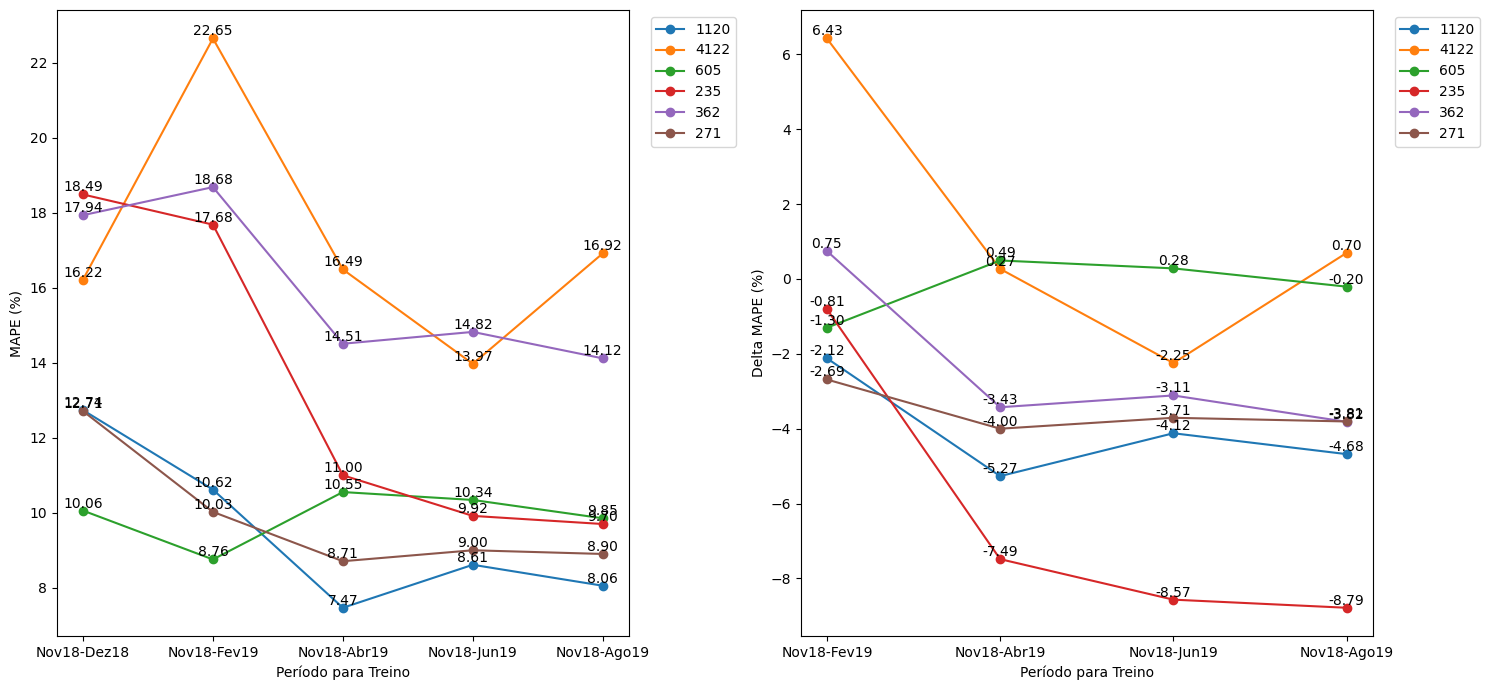

In [79]:
b = a[(a["Modelo"] == "XGBoost") & (a["Métrica"] == "MAPE") & (a["Teste"].str.contains("4.1 Teste"))].sort_values("Teste")

plt.figure(figsize=[15, 7])
plt.subplot(1,2,1)

for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Nov18-Dez18", "Nov18-Fev19", "Nov18-Abr19", "Nov18-Jun19", "Nov18-Ago19"]
    c['Valor'] = c['Valor']*100
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format(c["Valor"].iloc[i])
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.xlabel('Período para Treino')
plt.ylabel('MAPE (%)')
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.subplot(1,2,2)

for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Nov18-Dez18", "Nov18-Fev19", "Nov18-Abr19", "Nov18-Jun19", "Nov18-Ago19"]
    c["Valor"] = c["Valor"].diff()
    c["Valor"] = c["Valor"] * 100
    c.loc[c["Teste"] == "Janeiro", "Valor"] = 0
    c["Valor"] = c["Valor"].cumsum()
    
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format((c["Valor"].iloc[i]))
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.xlabel('Período para Treino')
plt.ylabel('Delta MAPE (%)')
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
# plt.show()

plt.savefig("Results/resultados_intervalo_2_treino_xgb.svg")
plt.savefig("Results/resultados_intervalo_2_treino_xgb.png")

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\4074542709.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c["Teste"] = ["Nov18-Dez18", "Nov18-Fev19", "Nov18-Abr19", "Nov18-Jun19", "Nov18-Ago19"]
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\4074542709.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['Valor'] = c['Valor']*100
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\4074542709.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

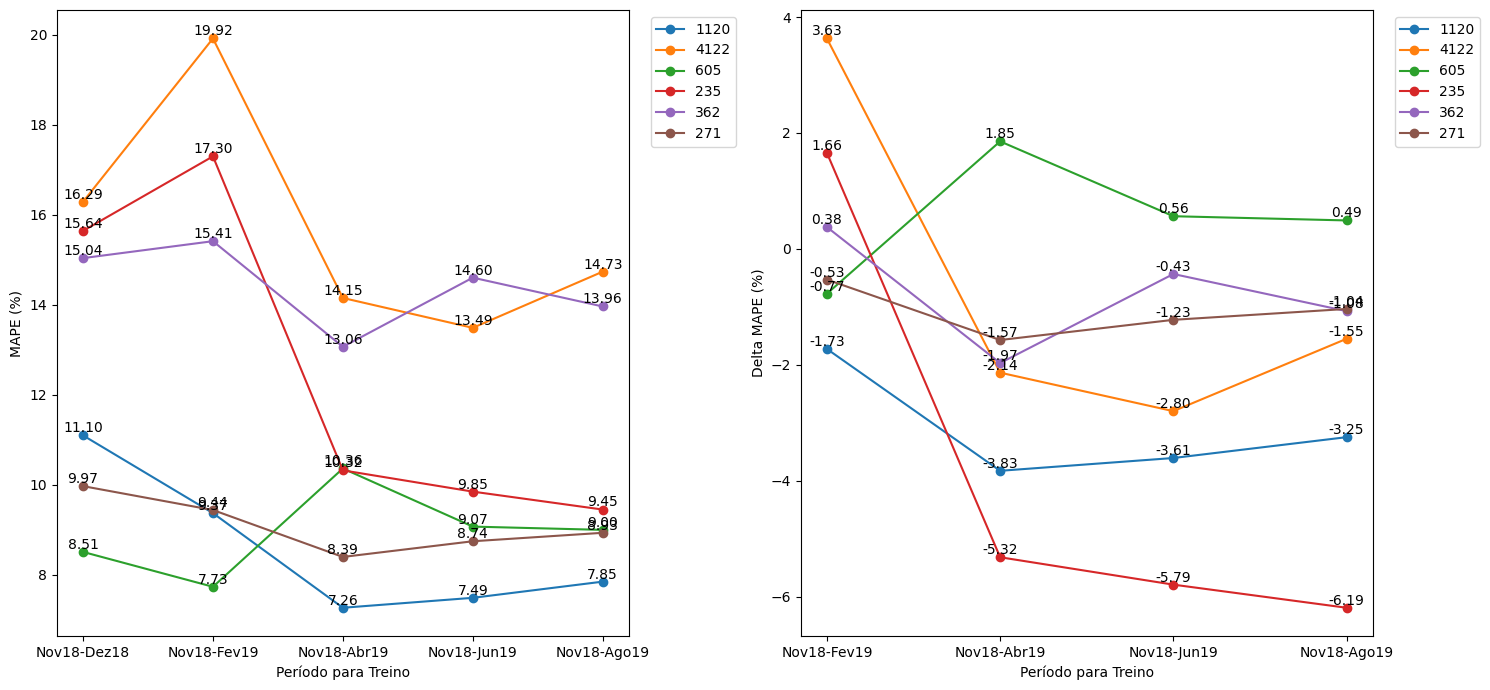

In [80]:
b = a[(a["Modelo"] == "Random Forest") & (a["Métrica"] == "MAPE") & (a["Teste"].str.contains("4.1 Teste"))].sort_values("Teste")

plt.figure(figsize=[15, 7])
plt.subplot(1,2,1)

for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Nov18-Dez18", "Nov18-Fev19", "Nov18-Abr19", "Nov18-Jun19", "Nov18-Ago19"]
    c['Valor'] = c['Valor']*100
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format(c["Valor"].iloc[i])
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.xlabel('Período para Treino')
plt.ylabel('MAPE (%)')
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.subplot(1,2,2)

for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Nov18-Dez18", "Nov18-Fev19", "Nov18-Abr19", "Nov18-Jun19", "Nov18-Ago19"]
    c["Valor"] = c["Valor"].diff()
    c["Valor"] = c["Valor"] * 100
    c.loc[c["Teste"] == "Janeiro", "Valor"] = 0
    c["Valor"] = c["Valor"].cumsum()
    
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format((c["Valor"].iloc[i]))
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.xlabel('Período para Treino')
plt.ylabel('Delta MAPE (%)')
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
# plt.show()

plt.savefig("Results/resultados_intervalo_2_treino_rf.svg")
plt.savefig("Results/resultados_intervalo_2_treino_rf.png")

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1988056675.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c["Teste"] = ["Nov18-Dez18", "Nov18-Fev19", "Nov18-Abr19", "Nov18-Jun19", "Nov18-Ago19"]
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1988056675.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['Valor'] = c['Valor']*100
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1988056675.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

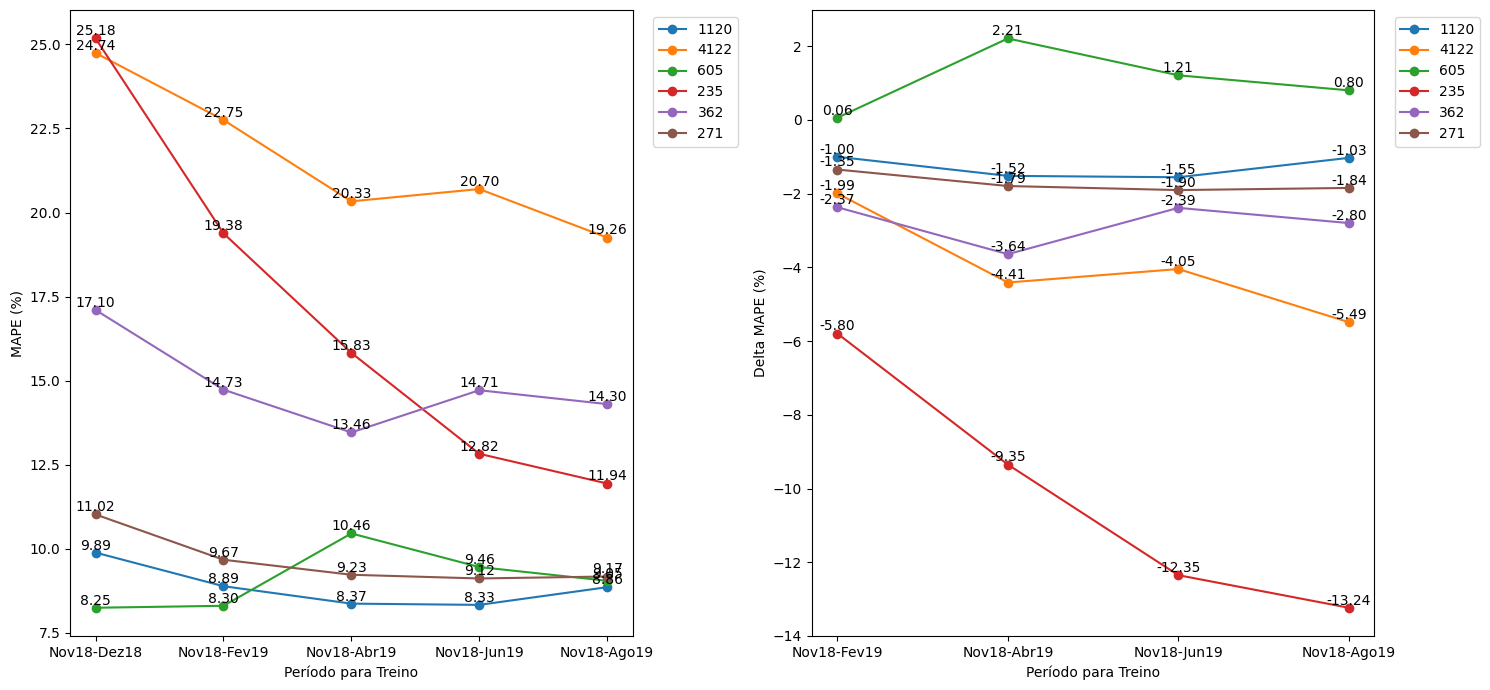

In [81]:
b = a[(a["Modelo"] == "Linear Regression") & (a["Métrica"] == "MAPE") & (a["Teste"].str.contains("4.1 Teste"))].sort_values("Teste")

plt.figure(figsize=[15, 7])
plt.subplot(1,2,1)

for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Nov18-Dez18", "Nov18-Fev19", "Nov18-Abr19", "Nov18-Jun19", "Nov18-Ago19"]
    c['Valor'] = c['Valor']*100
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format(c["Valor"].iloc[i])
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.xlabel('Período para Treino')
plt.ylabel('MAPE (%)')
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.subplot(1,2,2)

for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Nov18-Dez18", "Nov18-Fev19", "Nov18-Abr19", "Nov18-Jun19", "Nov18-Ago19"]
    c["Valor"] = c["Valor"].diff()
    c["Valor"] = c["Valor"] * 100
    c.loc[c["Teste"] == "Janeiro", "Valor"] = 0
    c["Valor"] = c["Valor"].cumsum()
    
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format((c["Valor"].iloc[i]))
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.xlabel('Período para Treino')
plt.ylabel('Delta MAPE (%)')
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
# plt.show()

plt.savefig("Results/resultados_intervalo_2_treino_lr.svg")
plt.savefig("Results/resultados_intervalo_2_treino_lr.png")

# Tunning

In [82]:
TestesNome = [
    "5 Tunning",
]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    shape = int(df_modelo.shape[0] * 0.3)
    df_teste = df_modelo[:shape]
    df_treino = df_modelo[shape:]
    for i in range(len(TestesNome)):
        teste_nome = TestesNome[i]
        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7']]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7']]
        y_treino = df_treino["DuraçãoViagem"]

        fi_xgb, fi_rf = cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome, True)
        fi_xgb["rota"], fi_rf["rota"] = rota, rota
        fi_xgb["modelo"], fi_rf["modelo"] = "XGB", "RF"

        importance = pd.concat([importance, fi_xgb, fi_rf])

Fitting 10 folds for each of 40 candidates, totalling 400 fits
[0]	validation_0-rmse:3866.86064
[1]	validation_0-rmse:3828.80950
[2]	validation_0-rmse:3791.14371
[3]	validation_0-rmse:3753.85947
[4]	validation_0-rmse:3716.95291
[5]	validation_0-rmse:3680.42040
[6]	validation_0-rmse:3644.24614
[7]	validation_0-rmse:3608.43775
[8]	validation_0-rmse:3572.99171
[9]	validation_0-rmse:3537.90444
[10]	validation_0-rmse:3503.17234
[11]	validation_0-rmse:3468.79195
[12]	validation_0-rmse:3434.70656
[13]	validation_0-rmse:3401.01890
[14]	validation_0-rmse:3367.61990
[15]	validation_0-rmse:3334.61138
[16]	validation_0-rmse:3301.88533
[17]	validation_0-rmse:3269.54267
[18]	validation_0-rmse:3237.47636
[19]	validation_0-rmse:3205.73565
[20]	validation_0-rmse:3174.37677
[21]	validation_0-rmse:3143.27615
[22]	validation_0-rmse:3112.49148
[23]	validation_0-rmse:3082.07745
[24]	validation_0-rmse:3051.91430
[25]	validation_0-rmse:3022.05788
[26]	validation_0-rmse:2992.56030
[27]	validation_0-rmse:2963.3

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Fitting 10 folds for each of 40 candidates, totalling 400 fits
[0]	validation_0-rmse:2715.09742
[1]	validation_0-rmse:2688.63550
[2]	validation_0-rmse:2662.44238
[3]	validation_0-rmse:2636.51567
[4]	validation_0-rmse:2610.85245
[5]	validation_0-rmse:2585.45311
[6]	validation_0-rmse:2560.31229
[7]	validation_0-rmse:2535.42737
[8]	validation_0-rmse:2510.79598
[9]	validation_0-rmse:2486.41553
[10]	validation_0-rmse:2462.28366
[11]	validation_0-rmse:2438.39785
[12]	validation_0-rmse:2414.75577
[13]	validation_0-rmse:2391.35506
[14]	validation_0-rmse:2368.19330
[15]	validation_0-rmse:2345.26826
[16]	validation_0-rmse:2322.58214
[17]	validation_0-rmse:2300.12019
[18]	validation_0-rmse:2277.89210
[19]	validation_0-rmse:2255.89106
[20]	validation_0-rmse:2234.10954
[21]	validation_0-rmse:2212.55558
[22]	validation_0-rmse:2191.22285
[23]	validation_0-rmse:2170.10205
[24]	validation_0-rmse:2149.20285
[25]	validation_0-rmse:2128.51775
[26]	validation_0-rmse:2108.04038
[27]	validation_0-rmse:2087.7

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Fitting 10 folds for each of 40 candidates, totalling 400 fits
[0]	validation_0-rmse:1422.58923
[1]	validation_0-rmse:1408.59928
[2]	validation_0-rmse:1394.75136
[3]	validation_0-rmse:1381.04351
[4]	validation_0-rmse:1367.47462
[5]	validation_0-rmse:1354.04331
[6]	validation_0-rmse:1340.74823
[7]	validation_0-rmse:1327.58834
[8]	validation_0-rmse:1314.56160
[9]	validation_0-rmse:1301.66704
[10]	validation_0-rmse:1288.90344
[11]	validation_0-rmse:1276.27078
[12]	validation_0-rmse:1263.76406
[13]	validation_0-rmse:1251.38692
[14]	validation_0-rmse:1239.13299
[15]	validation_0-rmse:1227.00634
[16]	validation_0-rmse:1215.00100
[17]	validation_0-rmse:1203.11717
[18]	validation_0-rmse:1191.35587
[19]	validation_0-rmse:1179.71487
[20]	validation_0-rmse:1168.19087
[21]	validation_0-rmse:1156.78758
[22]	validation_0-rmse:1145.49725
[23]	validation_0-rmse:1134.32659
[24]	validation_0-rmse:1123.26507
[25]	validation_0-rmse:1112.31988
[26]	validation_0-rmse:1101.48329
[27]	validation_0-rmse:1090.7

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Fitting 10 folds for each of 40 candidates, totalling 400 fits
[0]	validation_0-rmse:839.35920
[1]	validation_0-rmse:831.26129
[2]	validation_0-rmse:823.24695
[3]	validation_0-rmse:815.31515
[4]	validation_0-rmse:807.46538
[5]	validation_0-rmse:799.69625
[6]	validation_0-rmse:792.00791
[7]	validation_0-rmse:784.39862
[8]	validation_0-rmse:776.86824
[9]	validation_0-rmse:769.41495
[10]	validation_0-rmse:762.03853
[11]	validation_0-rmse:754.73972
[12]	validation_0-rmse:747.51551
[13]	validation_0-rmse:740.36578
[14]	validation_0-rmse:733.29186
[15]	validation_0-rmse:726.29023
[16]	validation_0-rmse:719.36086
[17]	validation_0-rmse:712.50503
[18]	validation_0-rmse:705.71847
[19]	validation_0-rmse:699.00436
[20]	validation_0-rmse:692.35810
[21]	validation_0-rmse:685.78344
[22]	validation_0-rmse:679.27558
[23]	validation_0-rmse:672.83678
[24]	validation_0-rmse:666.46409
[25]	validation_0-rmse:660.15727
[26]	validation_0-rmse:653.91822
[27]	validation_0-rmse:647.74346
[28]	validation_0-rmse:

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Fitting 10 folds for each of 40 candidates, totalling 400 fits
[0]	validation_0-rmse:3139.98102
[1]	validation_0-rmse:3109.56978
[2]	validation_0-rmse:3079.46919
[3]	validation_0-rmse:3049.67628
[4]	validation_0-rmse:3020.18798
[5]	validation_0-rmse:2991.00151
[6]	validation_0-rmse:2962.11374
[7]	validation_0-rmse:2933.52177
[8]	validation_0-rmse:2905.22241
[9]	validation_0-rmse:2877.21277
[10]	validation_0-rmse:2849.49025
[11]	validation_0-rmse:2822.05181
[12]	validation_0-rmse:2794.88641
[13]	validation_0-rmse:2767.99969
[14]	validation_0-rmse:2741.38920
[15]	validation_0-rmse:2715.05817
[16]	validation_0-rmse:2688.98761
[17]	validation_0-rmse:2663.19395
[18]	validation_0-rmse:2637.65541
[19]	validation_0-rmse:2612.38287
[20]	validation_0-rmse:2587.37184
[21]	validation_0-rmse:2562.61217
[22]	validation_0-rmse:2538.11111
[23]	validation_0-rmse:2513.86308
[24]	validation_0-rmse:2489.86043
[25]	validation_0-rmse:2466.10420
[26]	validation_0-rmse:2442.60156
[27]	validation_0-rmse:2419.3

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Fitting 10 folds for each of 40 candidates, totalling 400 fits
[0]	validation_0-rmse:3277.67380
[1]	validation_0-rmse:3245.44528
[2]	validation_0-rmse:3213.54190
[3]	validation_0-rmse:3181.96034
[4]	validation_0-rmse:3150.69758
[5]	validation_0-rmse:3119.75037
[6]	validation_0-rmse:3089.11577
[7]	validation_0-rmse:3058.79061
[8]	validation_0-rmse:3028.77158
[9]	validation_0-rmse:2999.05601
[10]	validation_0-rmse:2969.64281
[11]	validation_0-rmse:2940.52045
[12]	validation_0-rmse:2911.69607
[13]	validation_0-rmse:2883.15930
[14]	validation_0-rmse:2854.91720
[15]	validation_0-rmse:2826.95477
[16]	validation_0-rmse:2799.28124
[17]	validation_0-rmse:2771.88230
[18]	validation_0-rmse:2744.76198
[19]	validation_0-rmse:2717.91393
[20]	validation_0-rmse:2691.34107
[21]	validation_0-rmse:2665.03578
[22]	validation_0-rmse:2638.99634
[23]	validation_0-rmse:2613.22339
[24]	validation_0-rmse:2587.70688
[25]	validation_0-rmse:2562.45093
[26]	validation_0-rmse:2537.45292
[27]	validation_0-rmse:2512.7

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\1722300490.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [88]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
#a.loc[a['Métrica'] == 'RMSE'].sort_values(by='Valor')
a.to_excel("resultados.xlsx")

PermissionError: [Errno 13] Permission denied: 'Results/resultados.xlsx'

In [89]:
b = a[(a["Modelo"] != "Linear Regression") & (a["Métrica"] == "MAPE") & ((a["Teste"] == "5 Tunning") | (a["Teste"] == "2 - Teste clima - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7']"))]
b = b.pivot(index='Teste', columns=['Rota', 'Modelo'], values='Valor').sort_values("Teste")


In [90]:
b = a[(a["Modelo"] == "XGBoost") & (a["Métrica"] == "MAPE") & ((a["Teste"] == "5 Tunning") | (a["Teste"] == "2 - Teste clima - ['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva','Calor']"))]
b = b.pivot(index='Rota', columns=['Teste'], values='Valor')
b.rename(columns={"2 - Teste clima - ['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva','Calor']": "Antes do Tunning"}, inplace=True)
b["Delta"] = b["Antes do Tunning"] - b["5 Tunning"]
b[["Antes do Tunning", "5 Tunning", "Delta"]] = b[["Antes do Tunning", "5 Tunning", "Delta"]] * 100
# dfi.export(b, 'Results/tunning_xgb.svg')
# dfi.export(b, 'Results/tunning_xgb.png')
b


Teste  Antes do Tunning  5 Tunning     Delta
Rota                                        
1120           8.268823   7.570335  0.698488
235            9.282263   8.804291  0.477972
271            8.911701   8.975182 -0.063480
362           14.817191  14.023594  0.793597
4122          14.980289  12.963804  2.016485
605           10.339787   9.655636  0.684151

In [91]:
b = a[(a["Modelo"] == "Random Forest") & (a["Métrica"] == "MAPE") & ((a["Teste"] == "5 Tunning") | (a["Teste"] == "2 - Teste clima - ['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva','Calor']"))]
b = b.pivot(index='Rota', columns=['Teste'], values='Valor')
b.rename(columns={"2 - Teste clima - ['Sentido','KmPerc','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva','Calor']": "Antes do Tunning"}, inplace=True)
b["Delta"] = b["Antes do Tunning"] - b["5 Tunning"]
b[["Antes do Tunning", "5 Tunning", "Delta"]] = b[["Antes do Tunning", "5 Tunning", "Delta"]] * 100
# dfi.export(b, 'Results/tunning_rf.svg')
# dfi.export(b, 'Results/tunning_xgb.png')
b


Teste  Antes do Tunning  5 Tunning     Delta
Rota                                        
1120           7.729792   7.634660  0.095132
235            9.180273   8.906241  0.274031
271            8.999490   8.799236  0.200254
362           14.335746  14.111445  0.224301
4122          13.263043  12.954508  0.308535
605            9.037096   9.008326  0.028770

# Análise Comparativa

C:\Users\Thiago\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


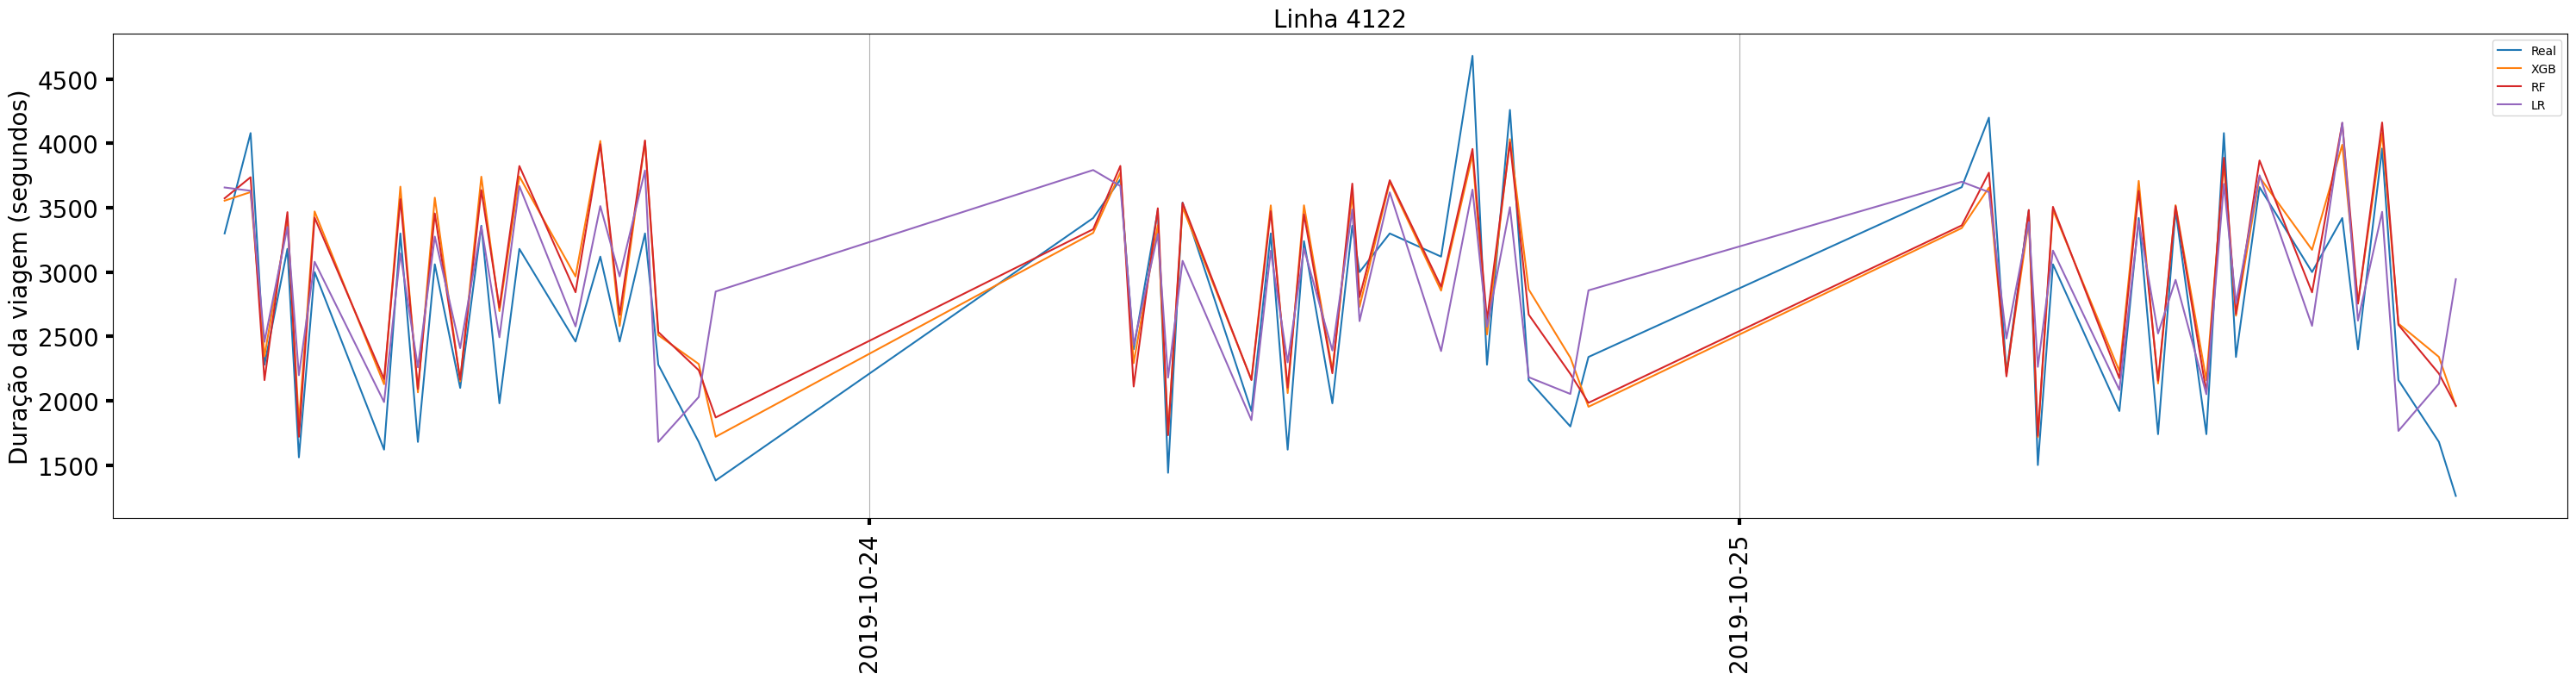

In [98]:
# Ajustar o dataframe b pq esse código foi criado quando avisa apenas um teste agora tem vários, 
# filtrar pelo teste certo que queremos
rota = '4122'

b = pd.DataFrame(predictions, columns=['Teste','Data','Rota','Modelo','Valor'])
b["Data"] = pd.to_datetime(b["Data"]) 
b = b.sort_values(by=["Data"], ascending=False)

plt.figure(figsize=(30, 8))

b = b.loc[(b["Data"] > "2019-10-20") & (b["Data"] < "2019-10-26") & (b['Rota'] == rota) & (b["Teste"].str.contains("5 Tu"))]

real_plot = b.loc[b['Modelo'] == 'Tempo real']
plt.plot(real_plot["Data"], real_plot["Valor"], color="#1f77b4", label="Real")

xgb_plot = b.loc[b['Modelo'] == 'XGBoost']
plt.plot(xgb_plot["Data"], xgb_plot["Valor"], color="#ff7f0e", label="XGB")

rf_plot = b.loc[b['Modelo'] == 'Random Forest']
plt.plot(rf_plot["Data"], rf_plot["Valor"], color="#d62728", label="RF")

lr_plot = b.loc[b['Modelo'] == 'Linear Regression']
plt.plot(lr_plot["Data"], lr_plot["Valor"], color="#9467bd", label="LR")

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.ylabel('Duração da viagem (segundos)', fontsize=20)
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=20)
plt.tick_params(axis='both', which='both', width=3, length=6, pad=6)
plt.grid(axis="x")
plt.title(f'Linha {rota}', fontsize=20)
plt.tight_layout()
plt.legend()


In [120]:
b = a[(a["Modelo"] != "Linear Regression") & (a["Teste"] == "5 Tunning")]
b = b.pivot(index='Rota', columns=['Modelo','Métrica'], values='Valor').reset_index()
c = df.groupby('Linha').agg({'KmPerc':'max'})
d = b.merge(c, left_on='Rota', right_on='Linha')
d
# Acho bom por o desvio padrão também, mas ai a gente olha na tabela que ja esta no overleaf e poe na mão por lá

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\2490261150.py:4: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  d = b.merge(c, left_on='Rota', right_on='Linha')


(Rota, )  (XGBoost, RMSE)  (XGBoost, MAPE)  (Random Forest, RMSE)  \
0     1120       368.749450         0.075703             365.885802   
1      235       360.817647         0.088043             361.592950   
2      271       173.486744         0.089752             167.135957   
3      362       152.263483         0.140236             151.615991   
4     4122       442.252897         0.129638             429.844526   
5      605       446.939961         0.096556             414.933266   

   (Random Forest, MAPE)  KmPerc  
0               0.076347  31.218  
1               0.089062  24.110  
2               0.087992  13.903  
3               0.141114   4.240  
4               0.129545  25.244  
5               0.090083  19.437

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\2381040967.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b['Teste_numero'] = b['Teste'].apply(lambda x: x[0])
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\2381040967.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c["Valor"] = c['Valor']*100
C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\2381040967.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

C:\Users\Thiago\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


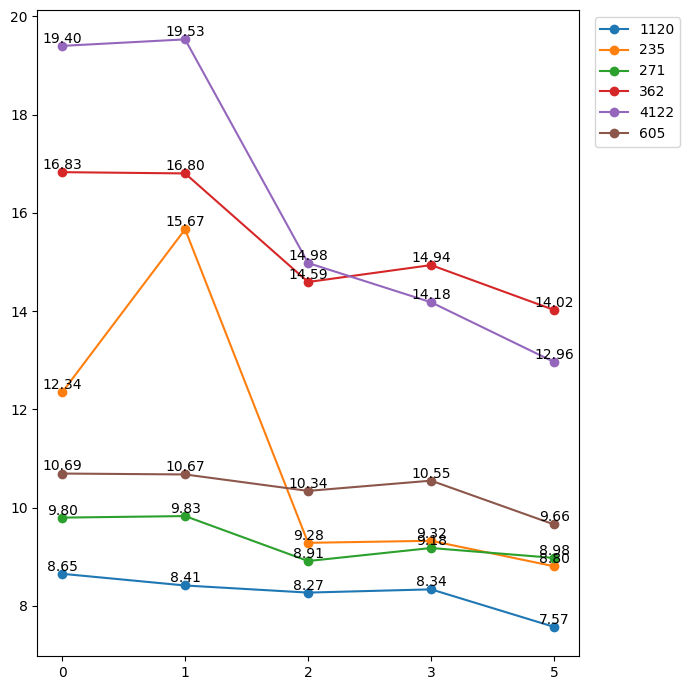

In [161]:
b = a[(a["Modelo"] == "XGBoost") & (a["Métrica"] == "MAPE") & ((~a["Teste"].str.contains("4.1")) & (~a["Teste"].str.contains("4 T")))]
b['Teste_numero'] = b['Teste'].apply(lambda x: x[0])
b = b.groupby(['Rota','Teste_numero'])['Valor'].min().reset_index()
b


plt.figure(figsize=[7, 7])
for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Valor"] = c['Valor']*100
    ax = plt.plot(c["Teste_numero"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste_numero"])):
        value_f = "{:.2f}".format(c["Valor"].iloc[i])
        plt.text(c["Teste_numero"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))


In [157]:
b = a[(a["Modelo"] == "XGBoost") & (a["Métrica"] == "MAPE") & ((~a["Teste"].str.contains("4.1")) & (~a["Teste"].str.contains("4 T")))]
b['Teste_numero'] = b['Teste'].apply(lambda x: x[0])
b = b.groupby(['Rota','Teste_numero'])['Valor'].min().reset_index()
b

C:\Users\Thiago\AppData\Local\Temp\ipykernel_12024\2369972897.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b['Teste_numero'] = b['Teste'].apply(lambda x: x[0])


Rota Teste_numero     Valor
0   1120            0  0.086519
1   1120            1  0.084134
2   1120            2  0.082688
3   1120            3  0.083350
4   1120            5  0.075703
5    235            0  0.123449
6    235            1  0.156665
7    235            2  0.092823
8    235            3  0.093239
9    235            5  0.088043
10   271            0  0.097957
11   271            1  0.098270
12   271            2  0.089117
13   271            3  0.091766
14   271            5  0.089752
15   362            0  0.168303
16   362            1  0.168044
17   362            2  0.145933
18   362            3  0.149378
19   362            5  0.140236
20  4122            0  0.194014
21  4122            1  0.195340
22  4122            2  0.149803
23  4122            3  0.141804
24  4122            5  0.129638
25   605            0  0.106932
26   605            1  0.106747
27   605            2  0.103398
28   605            3  0.105482
29   605            5  0.096556

In [153]:
b.dtypes

Teste                 object
Rota                  object
Modelo                object
Métrica               object
Valor                float64
Tempo de treino      float64
Tempo de previsão    float64
Teste_numero          object
dtype: object